<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/33_Timeseries_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 10가지 방식 — 시계열에서 어떻게 쓰나?

1. **Linear Regression (회귀)**
   마지막 L개의 값(혹은 특징)으로 다음 값을 선형 결합해 예측. 빠르고 해석 쉬움. 추세/계절을 더미나 사인/코사인으로 넣어도 좋음.

2. **Logistic Regression (분류)**
   “내일 오를까(↑)/내릴까(↓)”처럼 **방향**이나 이벤트 발생 여부 분류. 최근 수익률/변동성/요일 등을 특징으로 사용.

3. **Decision Tree (회귀)**
   비선형/상호작용을 규칙으로 나눠 다음 값을 회귀. 과적합 쉬워서 `min_samples_leaf`로 가지치기 필요.

4. **Random Forest (회귀)**
   여러 트리 앙상블로 강건한 비선형 예측. 특징 중요도 확인에 유용.

5. **SVM (분류; SVC)**
   마진을 최대화해 **상태/방향** 분류. 스케일링 필수. 커널로 비선형 경계 학습.

6. **k-NN (분류)**
   최근 패턴과 **가까운 과거 패턴** k개를 찾아 다수결로 방향 결정. 단순하지만 패턴이 반복되는 시계열에 꽤 강함.

7. **K-Means (클러스터링)**
   “창(rolling window)”로 잘라 낸 **패턴 조각**들을 군집화. 대표 패턴(centroid)을 보면 시계열 regime을 감 잡을 수 있음.

8. **Naive Bayes (분류)**
   특징을 조건부 독립이라 가정해 **방향 분류**. 가볍고 빠르며 기준선으로 좋음.

9. **Neural Networks (MLPRegressor; 회귀)**
   다층 퍼셉트론으로 비선형 회귀. 시계열 전용 RNN/LSTM까지는 아니어도, 랙 특징만으로도 강력해질 때가 있음.

10. **GBM (Gradient Boosting Regressor; 회귀)**
    잔차를 단계적으로 보완하는 앙상블. 트리 기반이라 비선형/상호작용 포착이 좋고, 튜닝 대비 성능이 안정적.


## 팁 (현업/응용용)

* **특징 엔지니어링**: 랙(lag), 이동평균/표준편차, RSI·MACD 같은 기술지표, 요일/월 더미, 사인/코사인(계절)을 적극 활용하세요.
* **시계열 분할**: `train/test`는 **시간순**으로 나누고, 가능하면 **워크포워드(rolling/expanding)** 백테스트를 추가하세요.
* **안정성**: SVM/NN/k-NN은 **스케일링** 필수. 트리/GBM은 스케일링 불필요.
* **과적합 방지**: 트리·RF는 `min_samples_leaf`, GBM은 `n_estimators / learning_rate / max_depth`, MLP는 `hidden_layer_sizes / alpha` 등을 튜닝.
* **클러스터링 활용**: K-Means로 구간 패턴을 라벨링한 뒤, 이 라벨을 **메타 특징**으로 추가하면 예측력이 오를 때가 많아요.

필요하면 위 스크립트를 **실제 종목 데이터(yfinance)** 버전으로도 바꿔서 줄게. 원하는 자산/기간만 알려줘!



[Regression] Metrics
                          Model     RMSE      MAE        R2
              Linear Regression 1.151239 0.940295  0.605896
      Neural Net (MLPRegressor) 1.191777 0.968970  0.577652
                  Random Forest 2.236042 1.866431 -0.486757
GBM (GradientBoostingRegressor) 2.543543 2.157087 -0.923794
                  Decision Tree 2.932197 2.484713 -1.556623

[Classification] Metrics
              Model  Accuracy  Precision  Recall       F1
          SVM (SVC)  0.820225   0.868421    0.75 0.804878
  k-NN (Classifier)  0.786517   0.804878    0.75 0.776471
        Naive Bayes  0.786517   0.804878    0.75 0.776471
Logistic Regression  0.780899   0.795181    0.75 0.771930


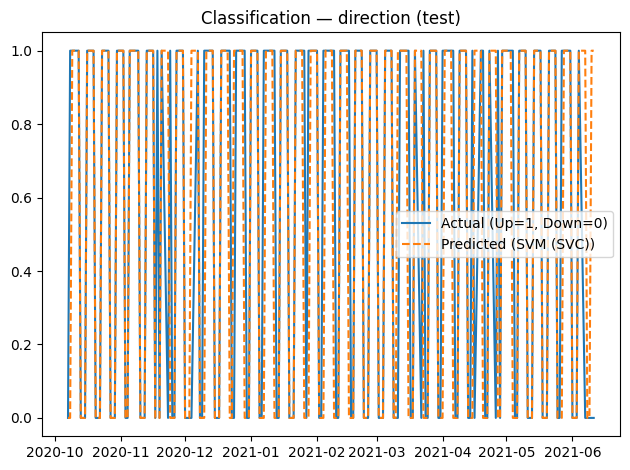


[KMeans] Cluster counts: {0: np.int64(336), 1: np.int64(206), 2: np.int64(344)}


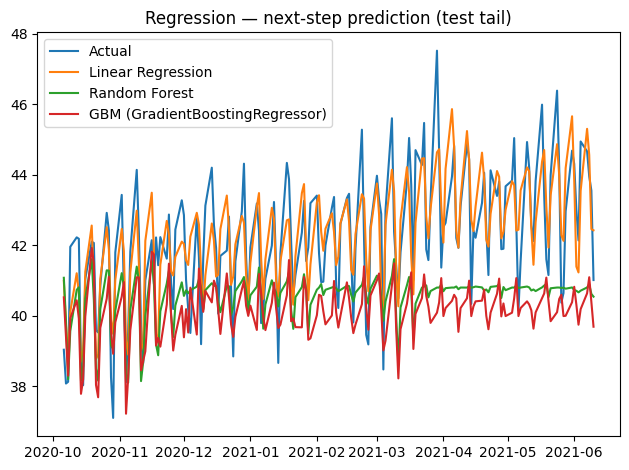

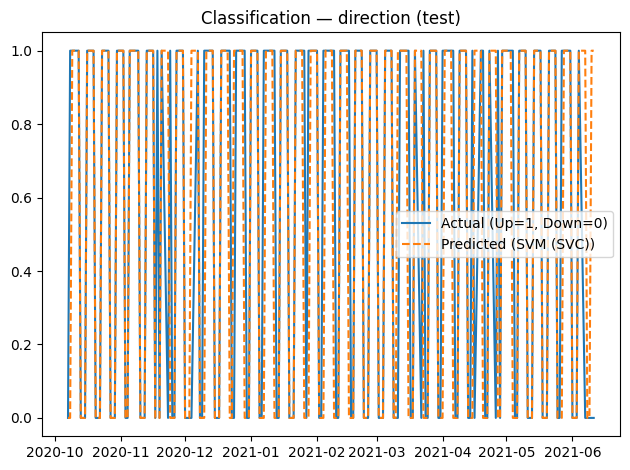

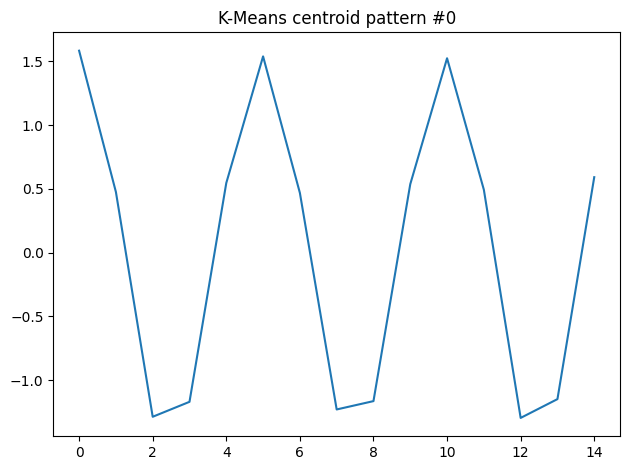

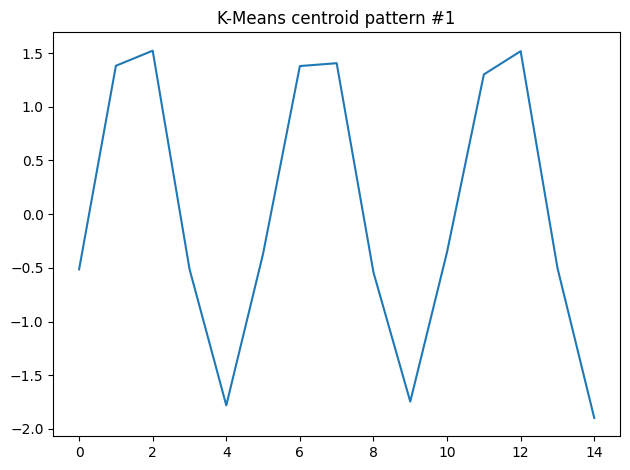

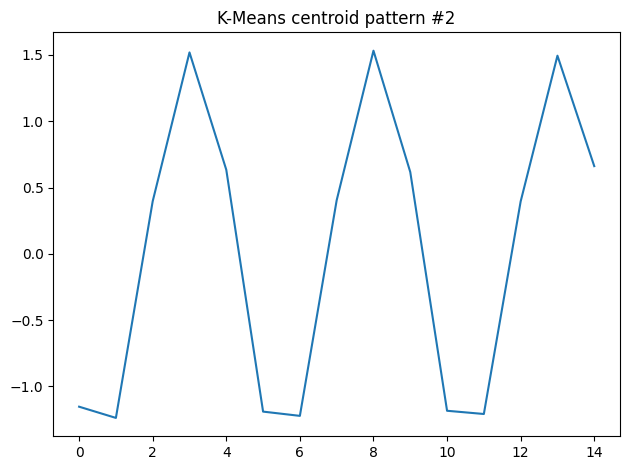

In [7]:
# timeseries_10_algos.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans


# -----------------------------
# 0) 합성 시계열 만들기 (추세 + 주기 + 레짐 + 잡음)
# -----------------------------
def make_series(n=900, seed=42):
    rng = np.random.default_rng(seed)
    dates = pd.bdate_range("2018-01-01", periods=n)
    t = np.arange(n)
    trend  = 0.02 * t
    season = 1.5 * np.sin(2*np.pi*t/5)          # 근무일 기준 주간 시즌성
    regime = np.where(t > n*0.6, 6.0, 0.0)      # 레벨 시프트
    noise  = rng.normal(0, 1.0, size=n)
    y = 20 + trend + season + regime + noise
    return pd.Series(y, index=dates, name="y")

# 랙 특징 만들기
def make_lag_features(s: pd.Series, L: int = 10, horizon: int = 1) -> pd.DataFrame:
    df = pd.DataFrame({"y": s})
    for i in range(1, L+1):
        df[f"lag{i}"] = s.shift(i)
    df["y_next"] = s.shift(-horizon)
    return df.dropna()

# -----------------------------
# 1) 데이터/특징
# -----------------------------
series = make_series()
ret = series.diff().fillna(0.0)
up_next = (ret.shift(-1) > 0).astype(int).iloc[:-1]

# 회귀용: 다음 값 y_{t+1} 예측
L = 10
reg_df = make_lag_features(series, L=L, horizon=1)
X_reg = reg_df[[f"lag{i}" for i in range(1, L+1)]].values
y_reg = reg_df["y_next"].values
dates_reg = reg_df.index

# 분류용: 다음 수익률 방향 (Up=1/Down=0)
L_cls = 10
cls_base = make_lag_features(ret, L=L_cls, horizon=1)
X_cls = cls_base[[f"lag{i}" for i in range(1, L_cls+1)]].values[1:]  # up_next 길이 맞추기
y_cls = up_next.values
dates_cls = cls_base.index[1:]

# 시간순 학습/테스트 분할 (백테스트 느낌)
split_idx_reg = int(0.8 * len(X_reg))
X_reg_tr, X_reg_te = X_reg[:split_idx_reg], X_reg[split_idx_reg:]
y_reg_tr, y_reg_te = y_reg[:split_idx_reg], y_reg[split_idx_reg:]
dates_reg_te = dates_reg[split_idx_reg:]

split_idx_cls = int(0.8 * len(X_cls))
X_cls_tr, X_cls_te = X_cls[:split_idx_cls], X_cls[split_idx_cls:]
y_cls_tr, y_cls_te = y_cls[:split_idx_cls], y_cls[split_idx_cls:]
dates_cls_te = dates_cls[split_idx_cls:]

# -----------------------------
# 2) 회귀 모델 5종
# -----------------------------
reg_models = {
    "Linear Regression": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Decision Tree": DecisionTreeRegressor(random_state=0, min_samples_leaf=5),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=0, min_samples_leaf=3, n_jobs=-1),
    "Neural Net (MLPRegressor)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=700, random_state=0))
    ]),
    "GBM (GradientBoostingRegressor)": GradientBoostingRegressor(random_state=0),
}

reg_results, preds_reg = [], {}
for name, mdl in reg_models.items():
    mdl.fit(X_reg_tr, y_reg_tr)
    yhat = mdl.predict(X_reg_te)
    preds_reg[name] = yhat
    reg_results.append({
        "Model": name,
        "RMSE": float(np.sqrt(mean_squared_error(y_reg_te, yhat))),
        "MAE": float(np.mean(np.abs(y_reg_te - yhat))),
        "R2": float(r2_score(y_reg_te, yhat)),
    })
reg_table = pd.DataFrame(reg_results).sort_values("RMSE").reset_index(drop=True)
print("\n[Regression] Metrics")
print(reg_table.to_string(index=False))


# -----------------------------
# 3) 분류 모델 4종
# -----------------------------
# 다음 수익률 방향(Up=1/Down=0)을 라벨로, 입력은 수익률의 랙들
L_cls = 10

df_cls = pd.DataFrame(index=ret.index)
for i in range(1, L_cls + 1):
    df_cls[f"lag{i}"] = ret.shift(i)

# 라벨: 다음 시점 수익률이 양(상승)인가?
df_cls["label"] = (ret.shift(-1) > 0).astype(int)

# 결측 제거로 길이/인덱스 정렬 동시 해결
df_cls = df_cls.dropna()

X_cls = df_cls[[f"lag{i}" for i in range(1, L_cls + 1)]].values
y_cls = df_cls["label"].values
dates_cls = df_cls.index

# 시간순 분할 (백테스트 느낌 유지)
split_idx_cls = int(0.8 * len(X_cls))
X_cls_tr, X_cls_te = X_cls[:split_idx_cls], X_cls[split_idx_cls:]
y_cls_tr, y_cls_te = y_cls[:split_idx_cls], y_cls[split_idx_cls:]
dates_cls_tr, dates_cls_te = dates_cls[:split_idx_cls], dates_cls[split_idx_cls:]

# ----------------- (기존) 분류 모델 학습/평가 그대로 사용 -----------------
cls_models = {
    "Logistic Regression": Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(max_iter=1000))]),
    "SVM (SVC)": Pipeline([("scaler", StandardScaler()), ("model", SVC(probability=True, random_state=0))]),
    "k-NN (Classifier)": Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier(n_neighbors=15))]),
    "Naive Bayes": GaussianNB(),
}

cls_results, preds_cls = [], {}
for name, mdl in cls_models.items():
    mdl.fit(X_cls_tr, y_cls_tr)
    yhat = mdl.predict(X_cls_te)
    preds_cls[name] = yhat
    cls_results.append({
        "Model": name,
        "Accuracy": float(accuracy_score(y_cls_te, yhat)),
        "Precision": float(precision_score(y_cls_te, yhat, zero_division=0)),
        "Recall": float(recall_score(y_cls_te, yhat, zero_division=0)),
        "F1": float(f1_score(y_cls_te, yhat, zero_division=0)),
    })

cls_table = pd.DataFrame(cls_results).sort_values("F1", ascending=False).reset_index(drop=True)
print("\n[Classification] Metrics")
print(cls_table.to_string(index=False))

# (그래프) 최고 F1 모델만 오버레이
best_cls = cls_table.iloc[0]["Model"]
plt.figure()
plt.plot(dates_cls_te, y_cls_te, label="Actual (Up=1, Down=0)")
plt.plot(dates_cls_te, preds_cls[best_cls], label=f"Predicted ({best_cls})", linestyle="--")
plt.title("Classification — direction (test)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 4) K-Means (패턴 클러스터링)
# -----------------------------
win = 15
X_pat = np.array([ret.values[i:i+win] for i in range(len(ret)-win+1)])
dates_pat = ret.index[win-1:]
split_pat = int(0.8 * len(X_pat))
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(X_pat[:split_pat])
labels_all = kmeans.predict(X_pat)
cluster_counts = pd.Series(labels_all).value_counts().sort_index()
print("\n[KMeans] Cluster counts:", dict(cluster_counts))

# -----------------------------
# 5) 시각화 (각각 독립 Figure; 색상 지정 X)
# -----------------------------
# 회귀: 실제 vs 예측(대표 3개)
lookback = 200
plt.figure()
plt.plot(dates_reg_te[-lookback:], y_reg_te[-lookback:], label="Actual")
for name in ["Linear Regression", "Random Forest", "GBM (GradientBoostingRegressor)"]:
    plt.plot(dates_reg_te[-lookback:], preds_reg[name][-lookback:], label=name)
plt.title("Regression — next-step prediction (test tail)")
plt.legend(); plt.tight_layout(); plt.show()

# 분류: 실제(0/1) vs 예측(최고 F1모델)
best_cls_name = cls_table.iloc[0]["Model"]
plt.figure()
plt.plot(dates_cls_te, y_cls_te, label="Actual (Up=1, Down=0)")
plt.plot(dates_cls_te, preds_cls[best_cls_name], label=f"Predicted ({best_cls_name})", linestyle="--")
plt.title("Classification — direction (test)")
plt.legend(); plt.tight_layout(); plt.show()

# KMeans: 각 클러스터 중심 패턴 (한 차트씩)
for i, c in enumerate(kmeans.cluster_centers_):
    plt.figure()
    plt.plot(range(win), c)
    plt.title(f"K-Means centroid pattern #{i}")
    plt.tight_layout(); plt.show()


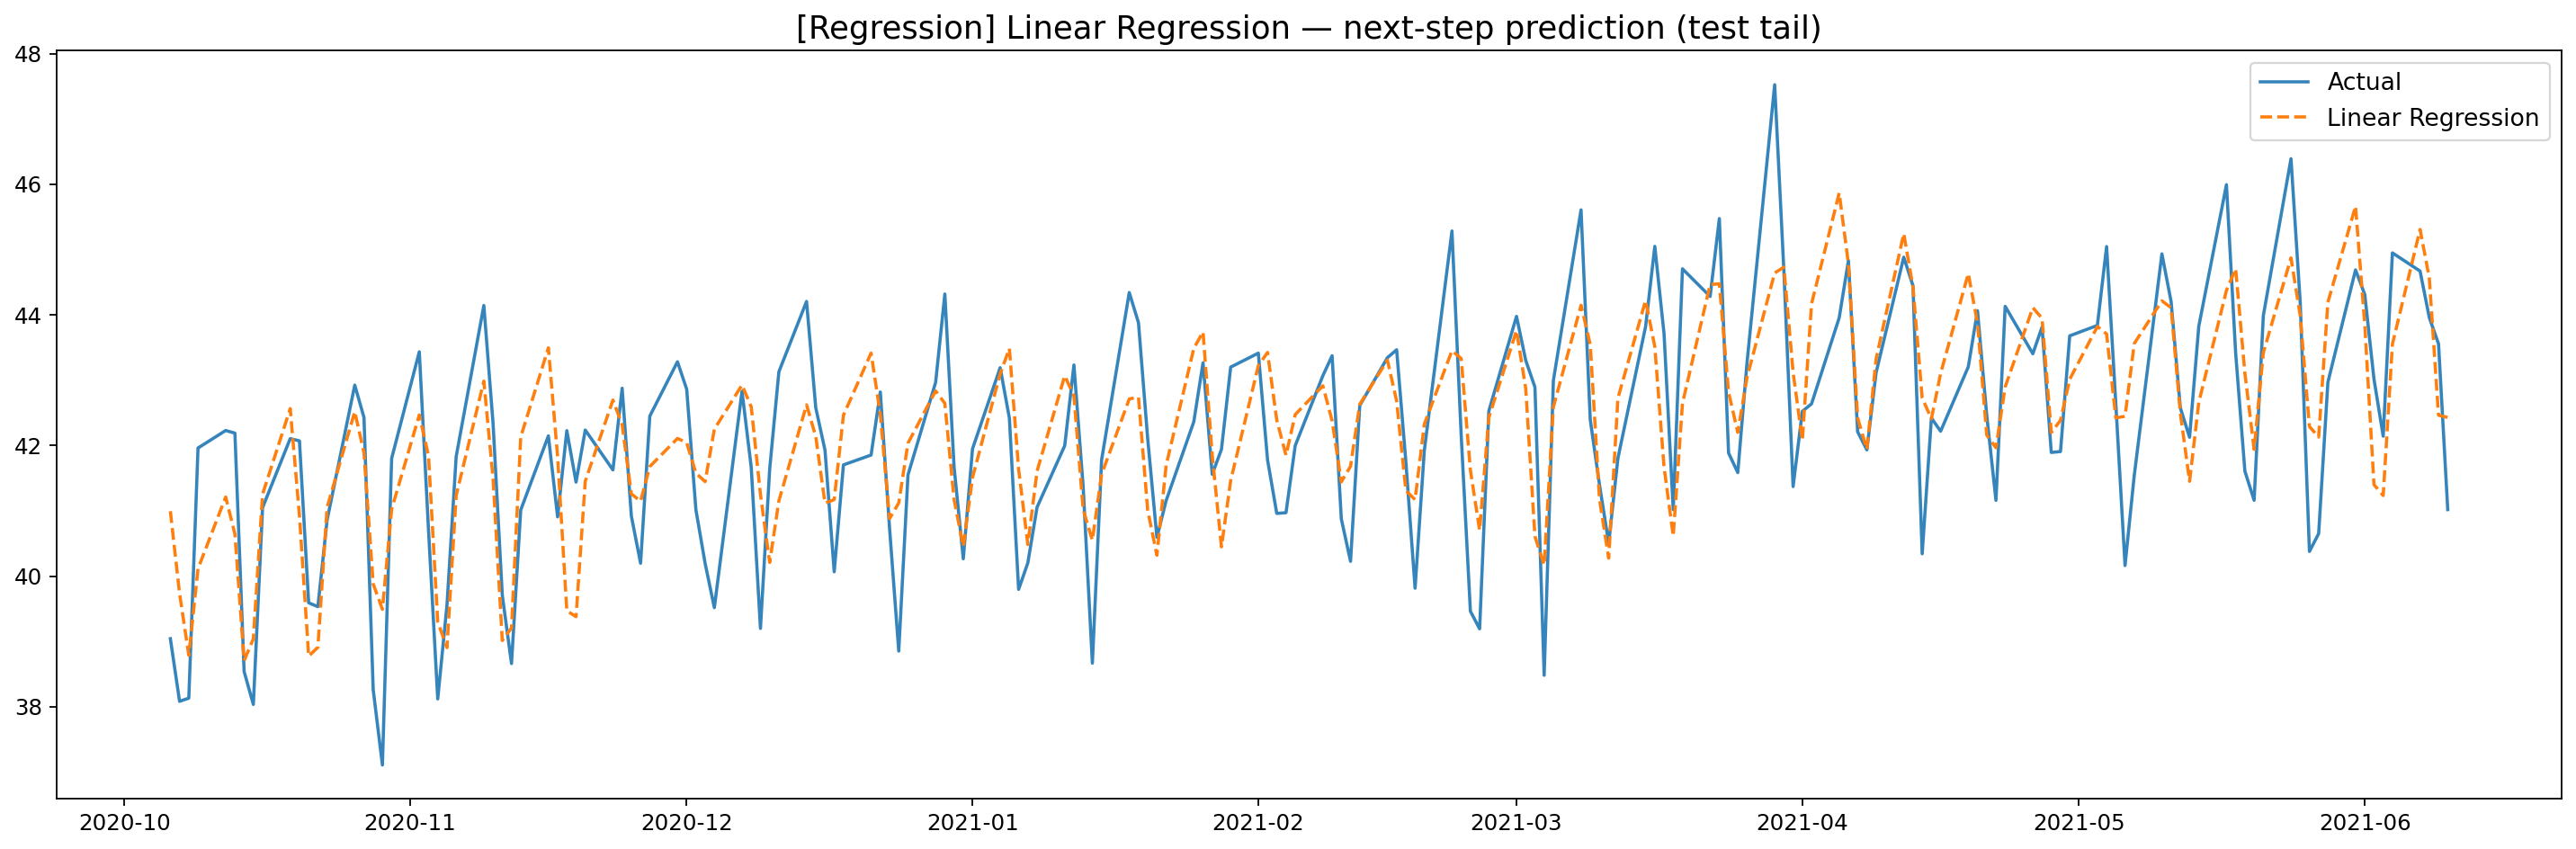

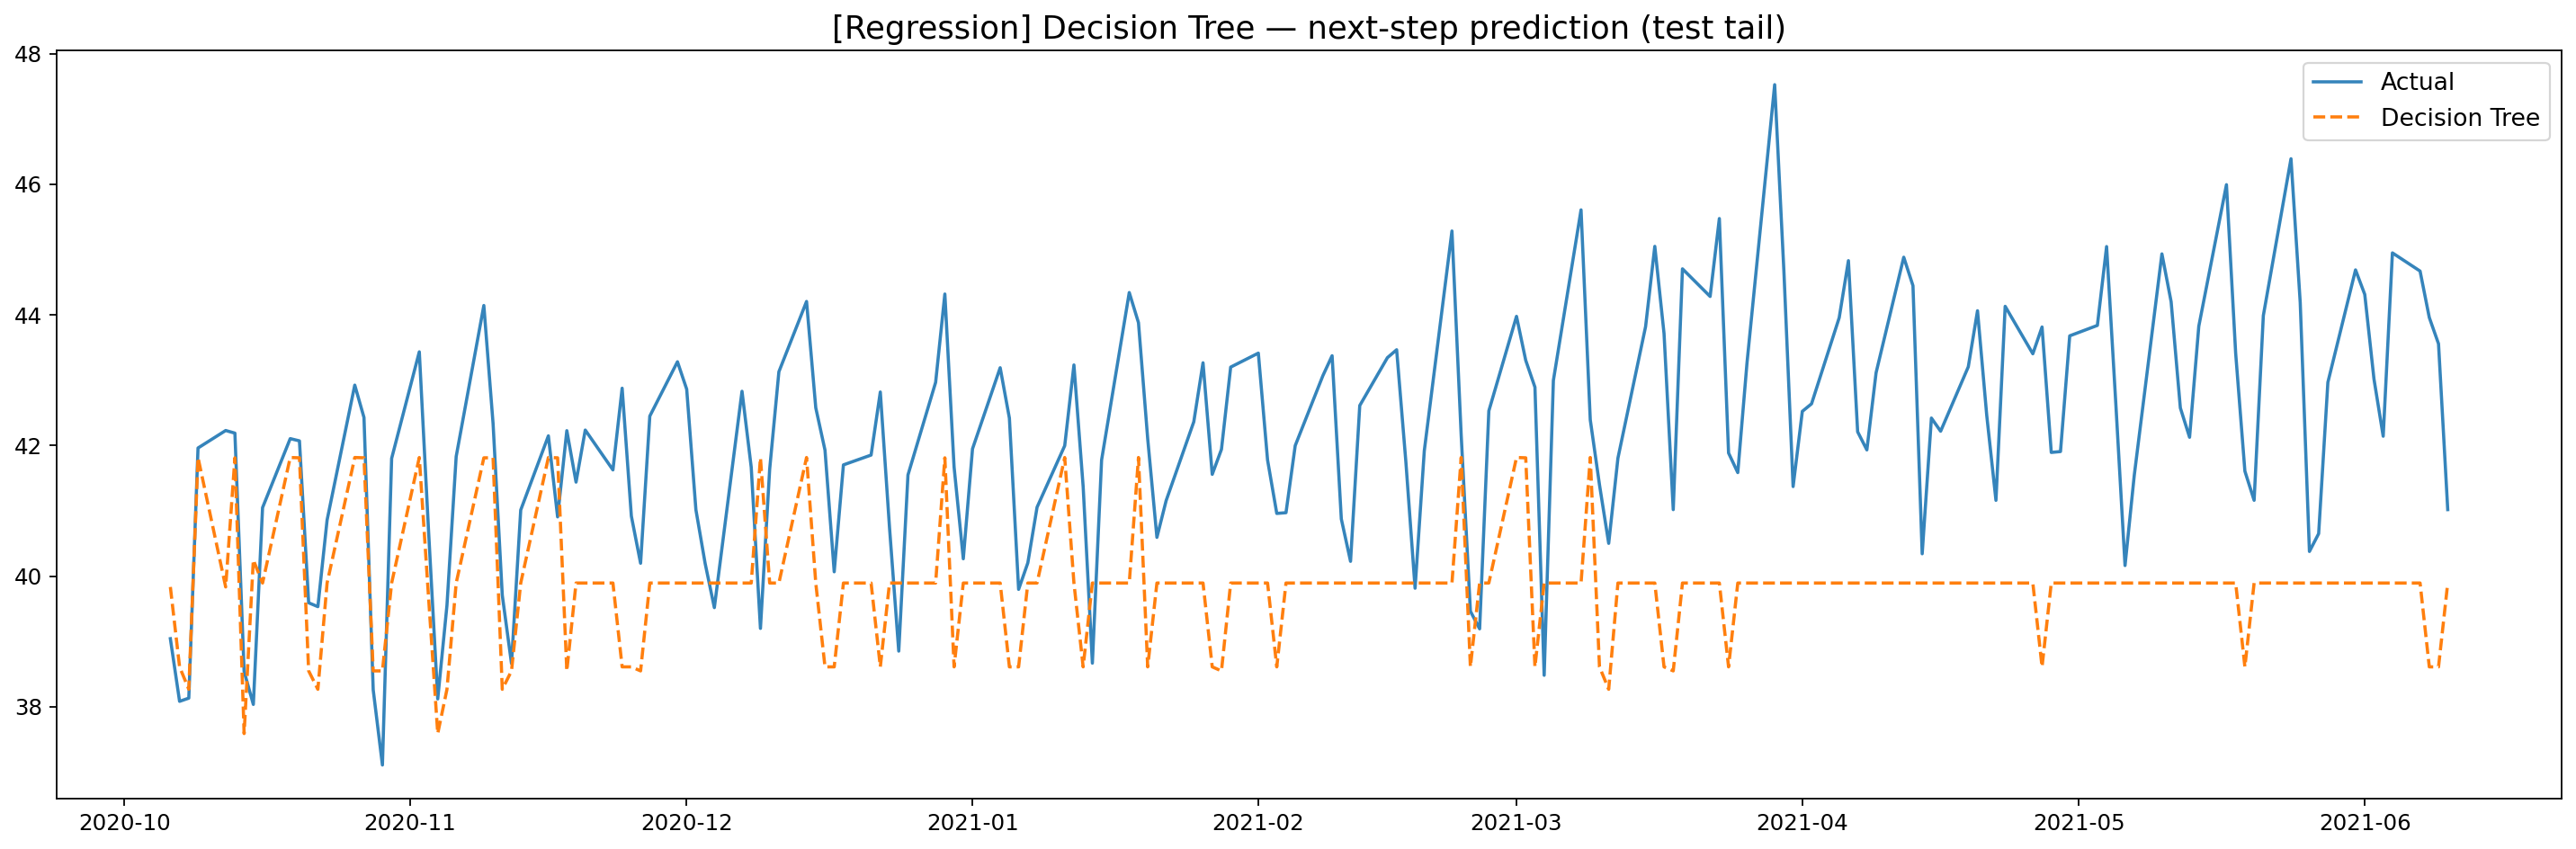

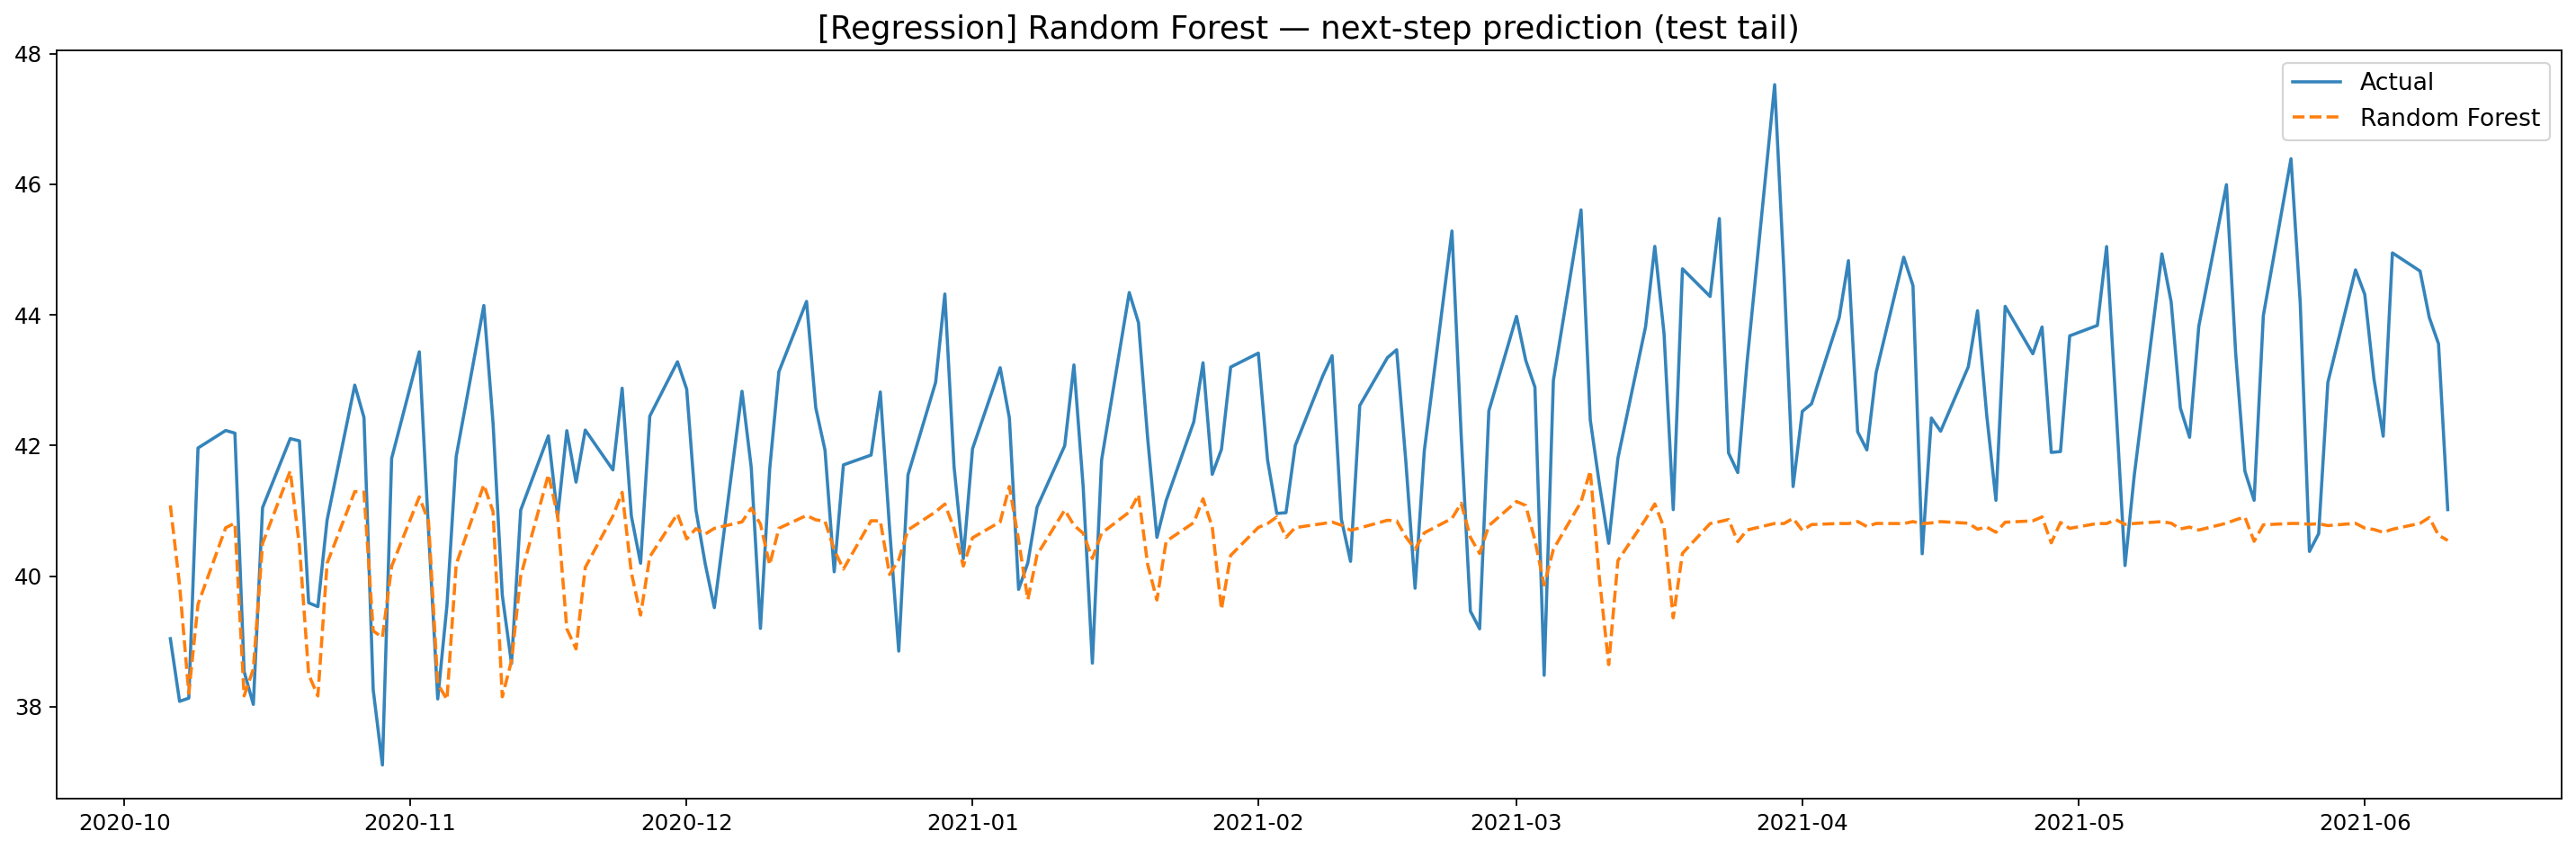

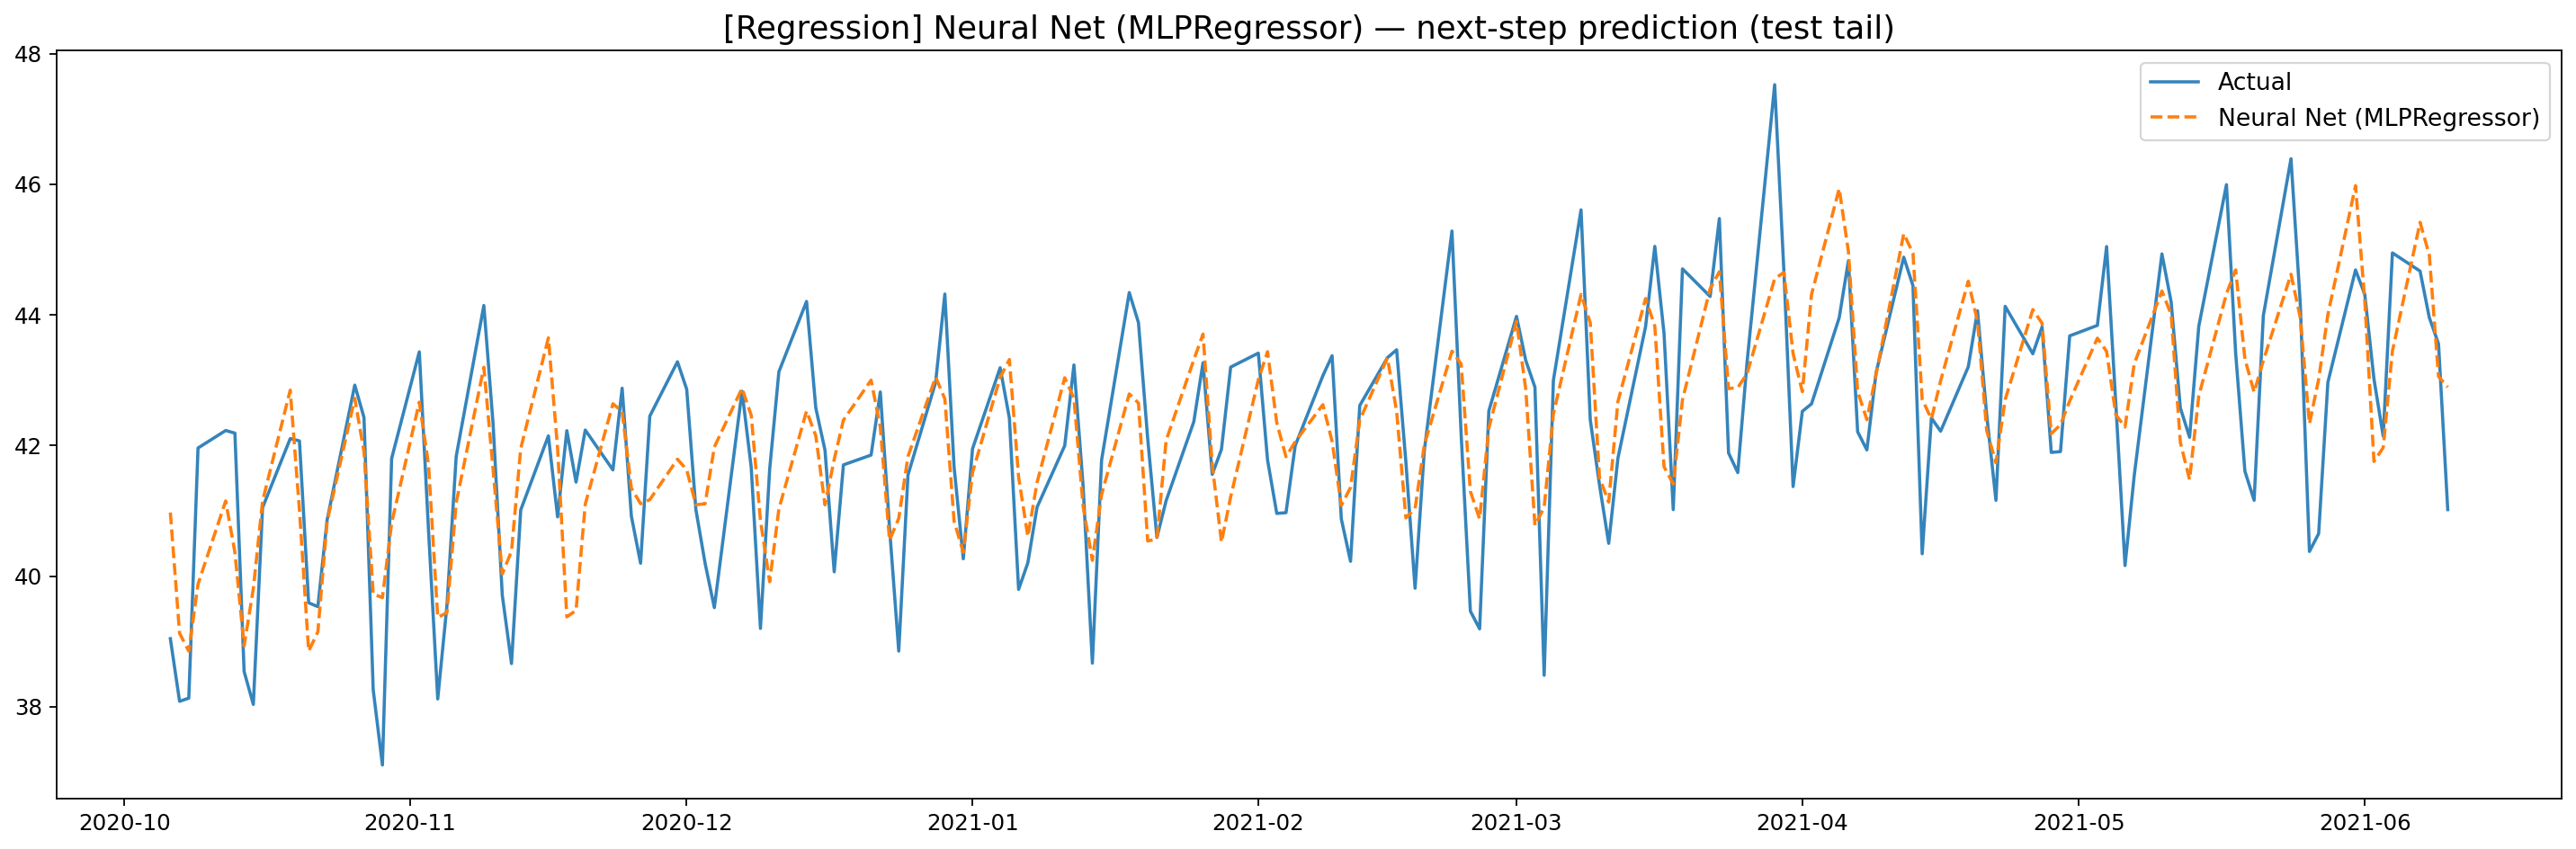

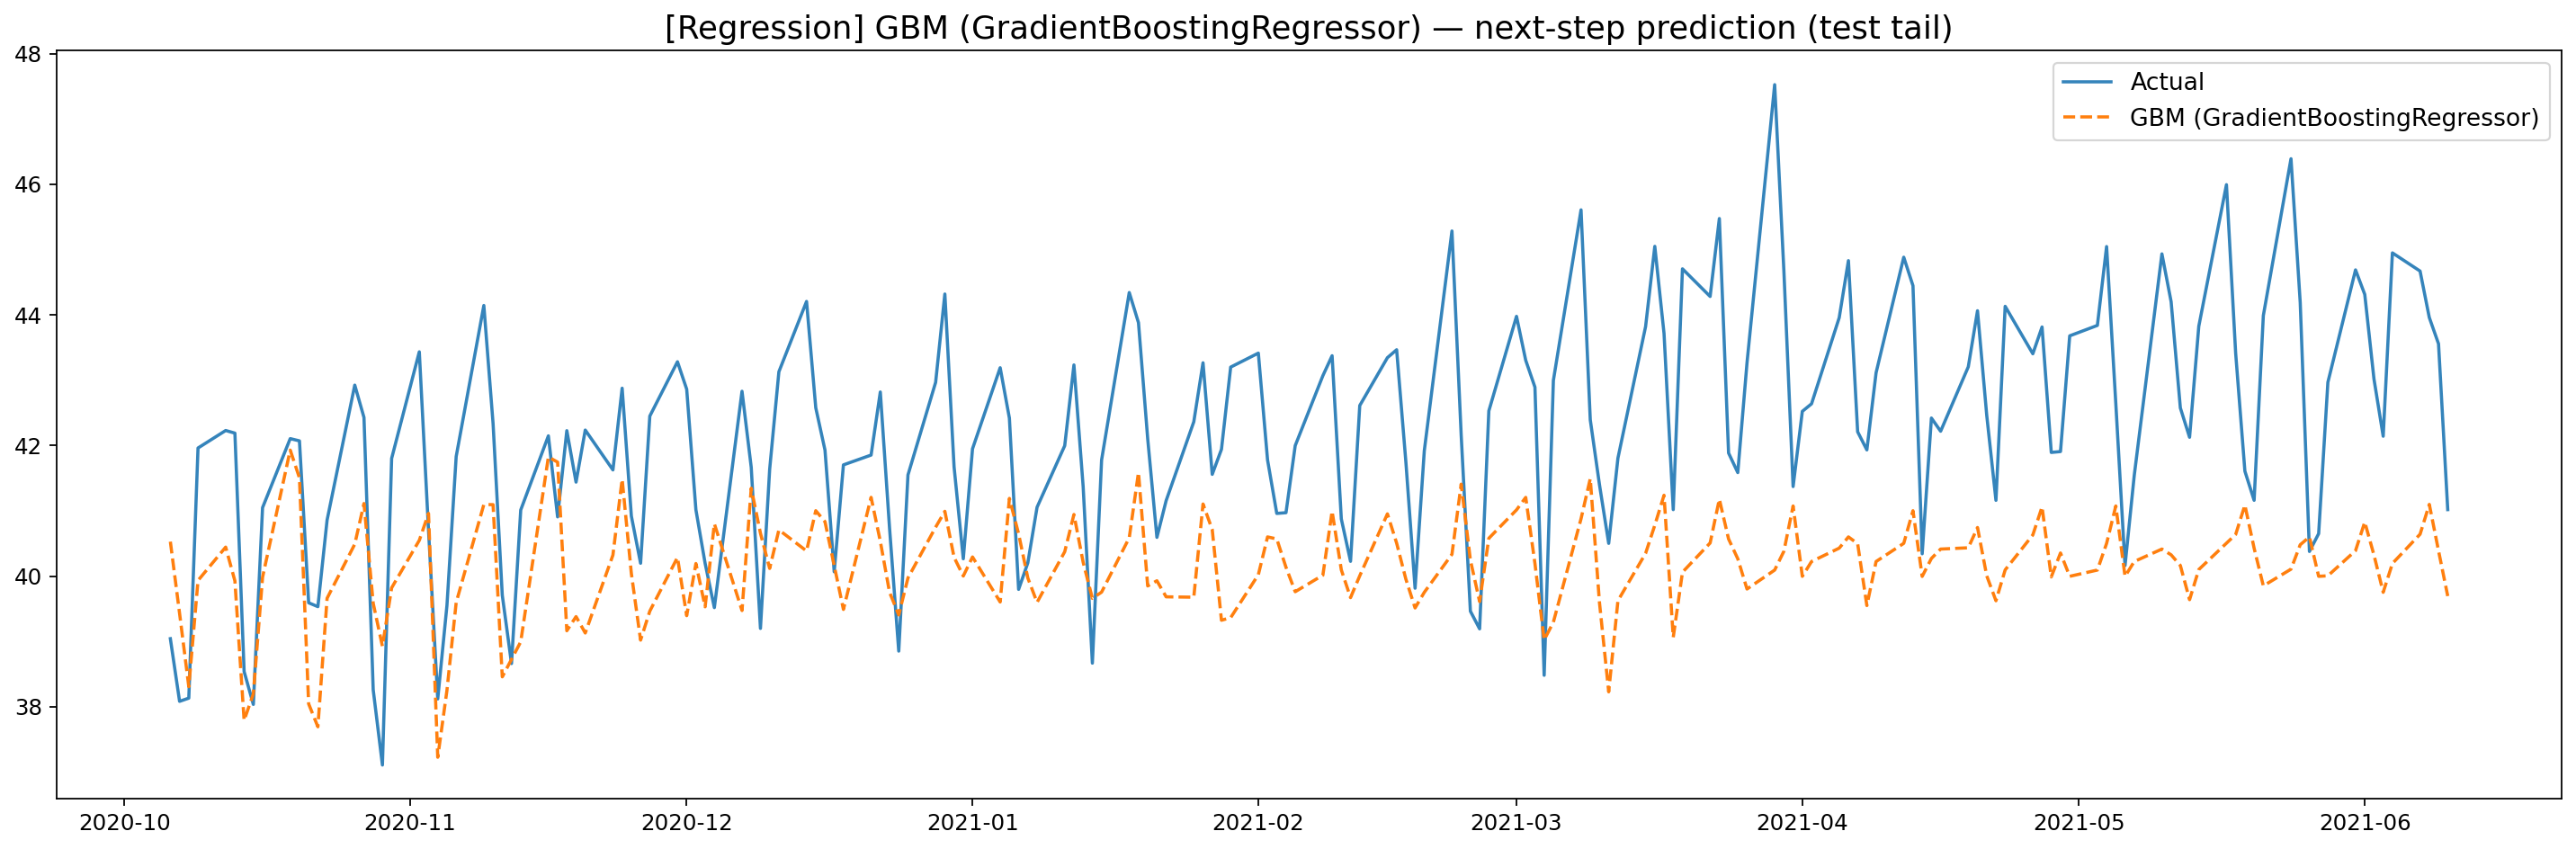

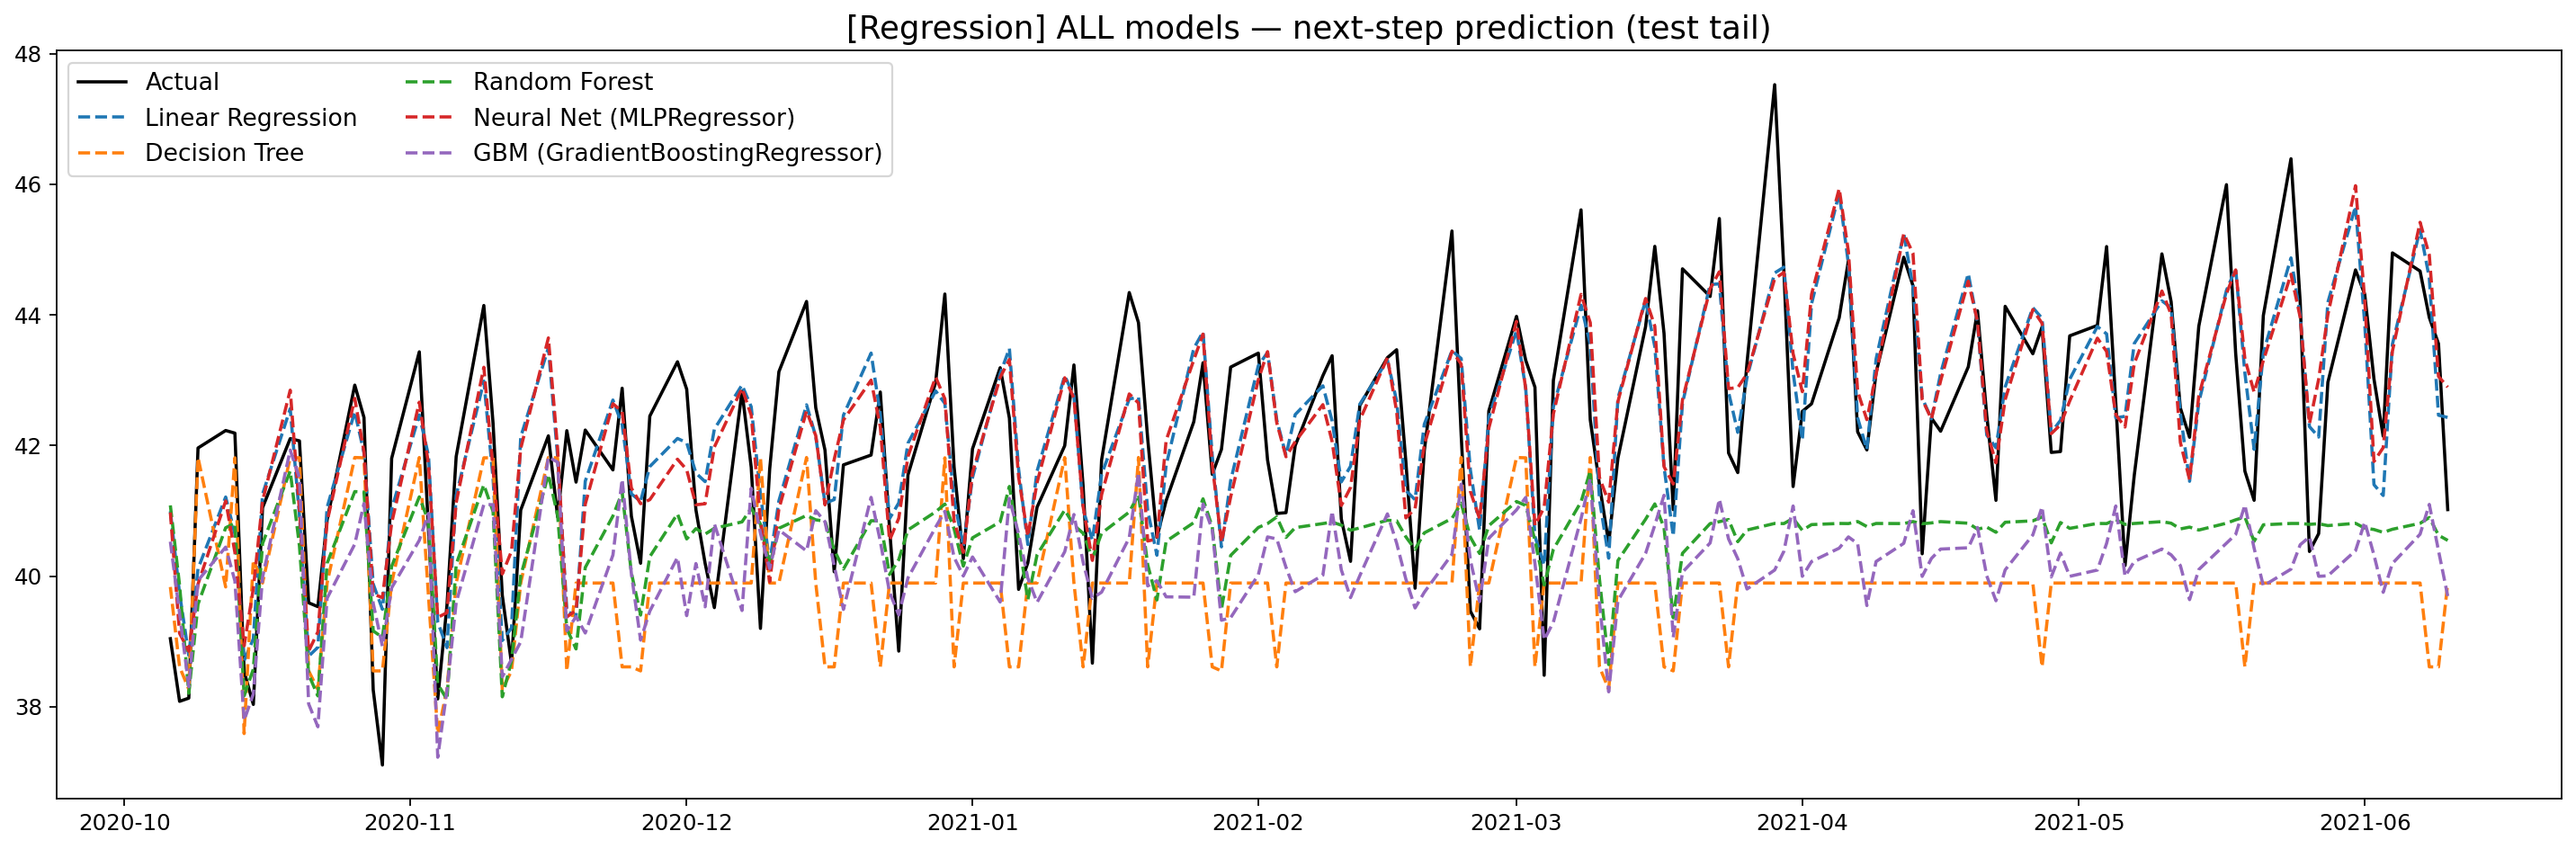

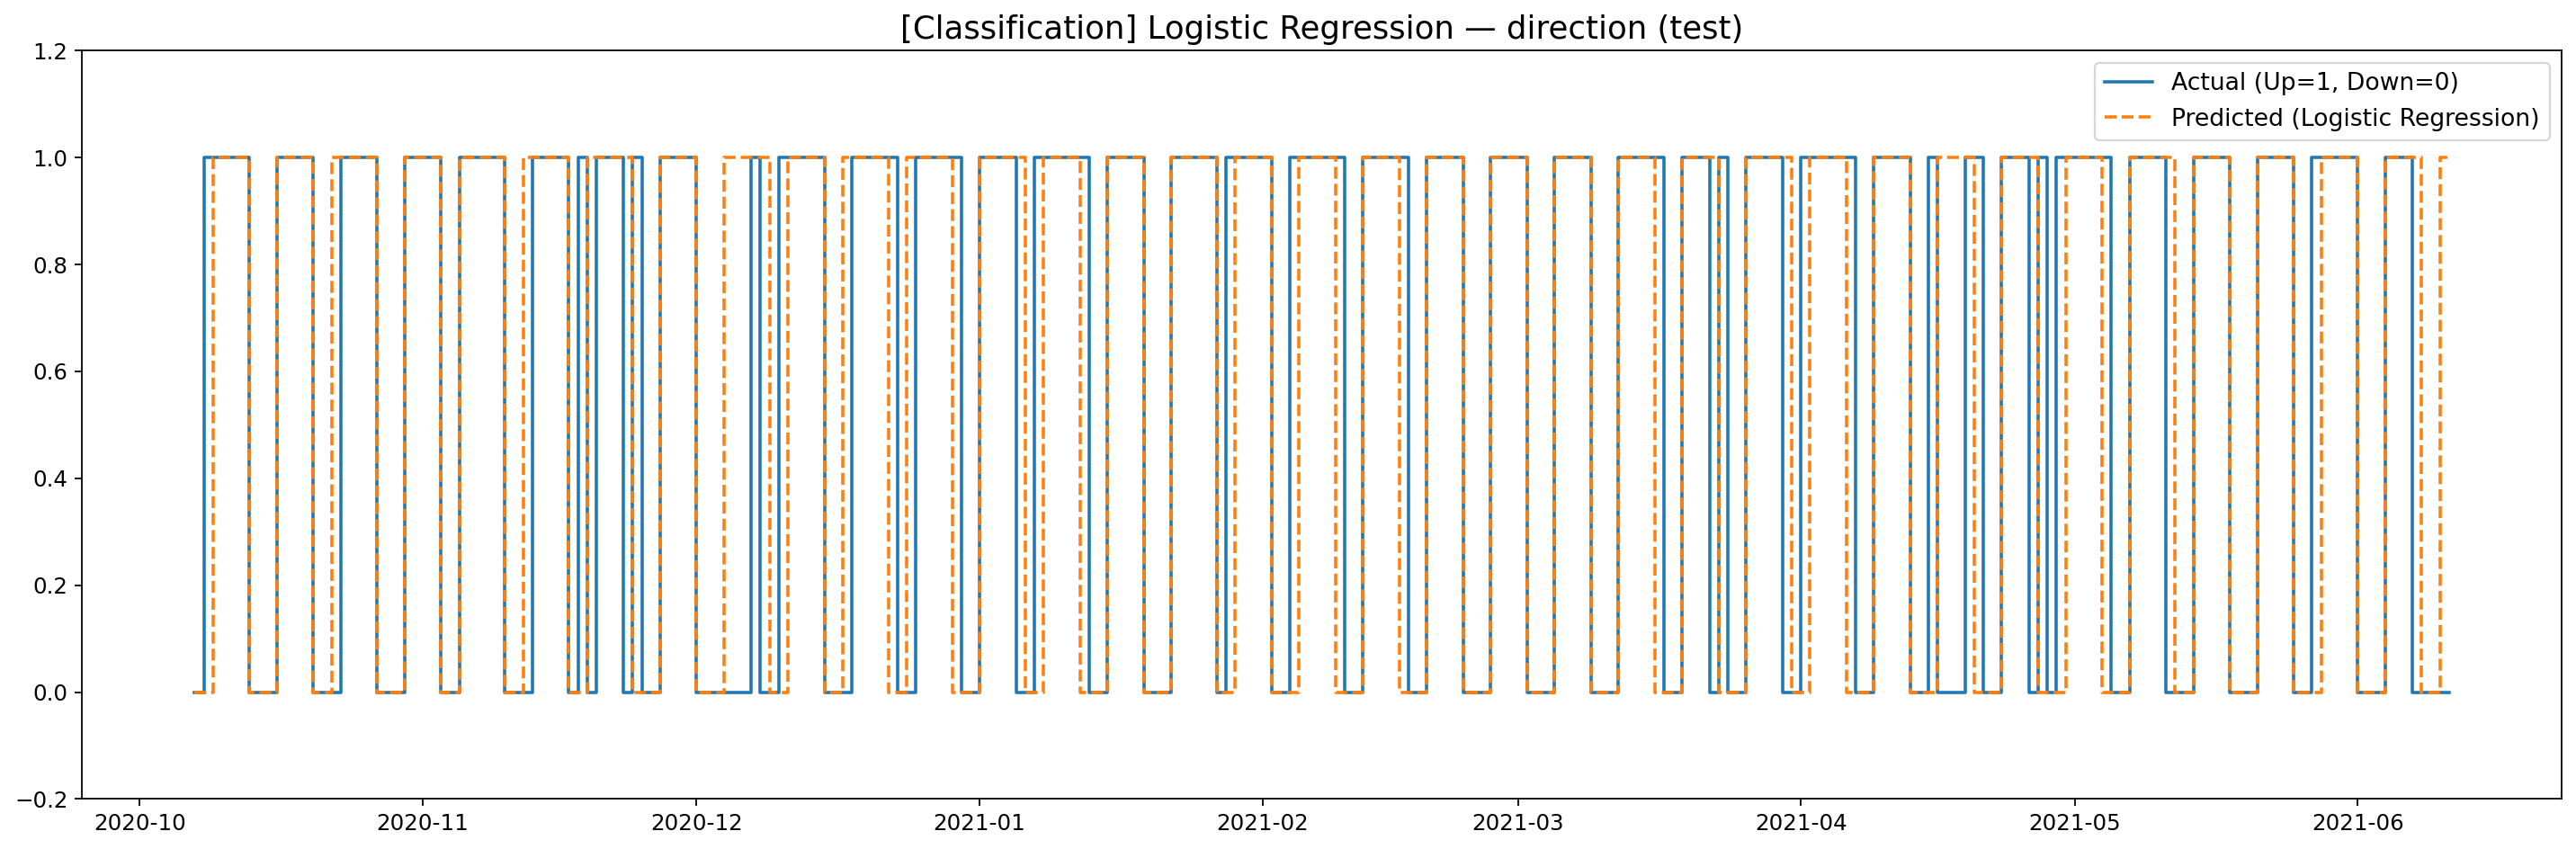

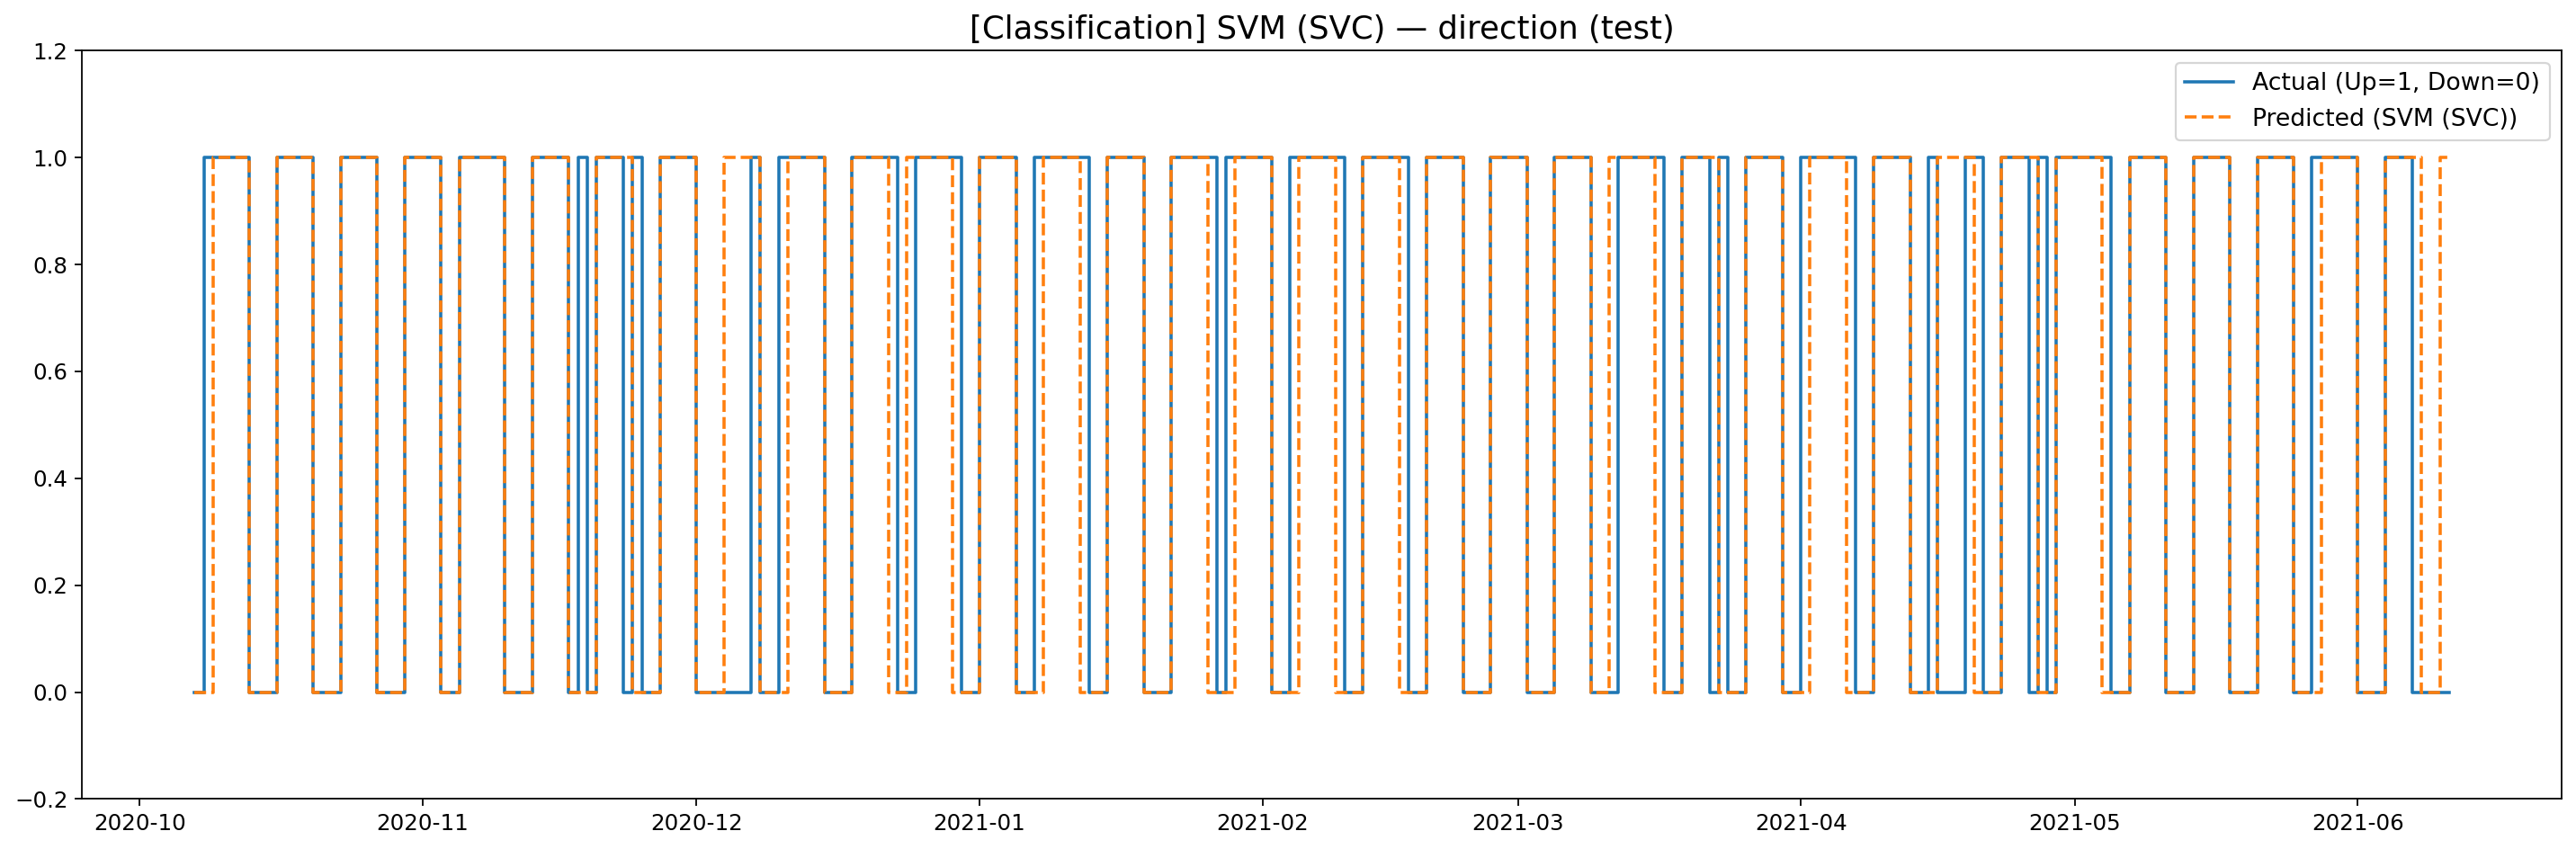

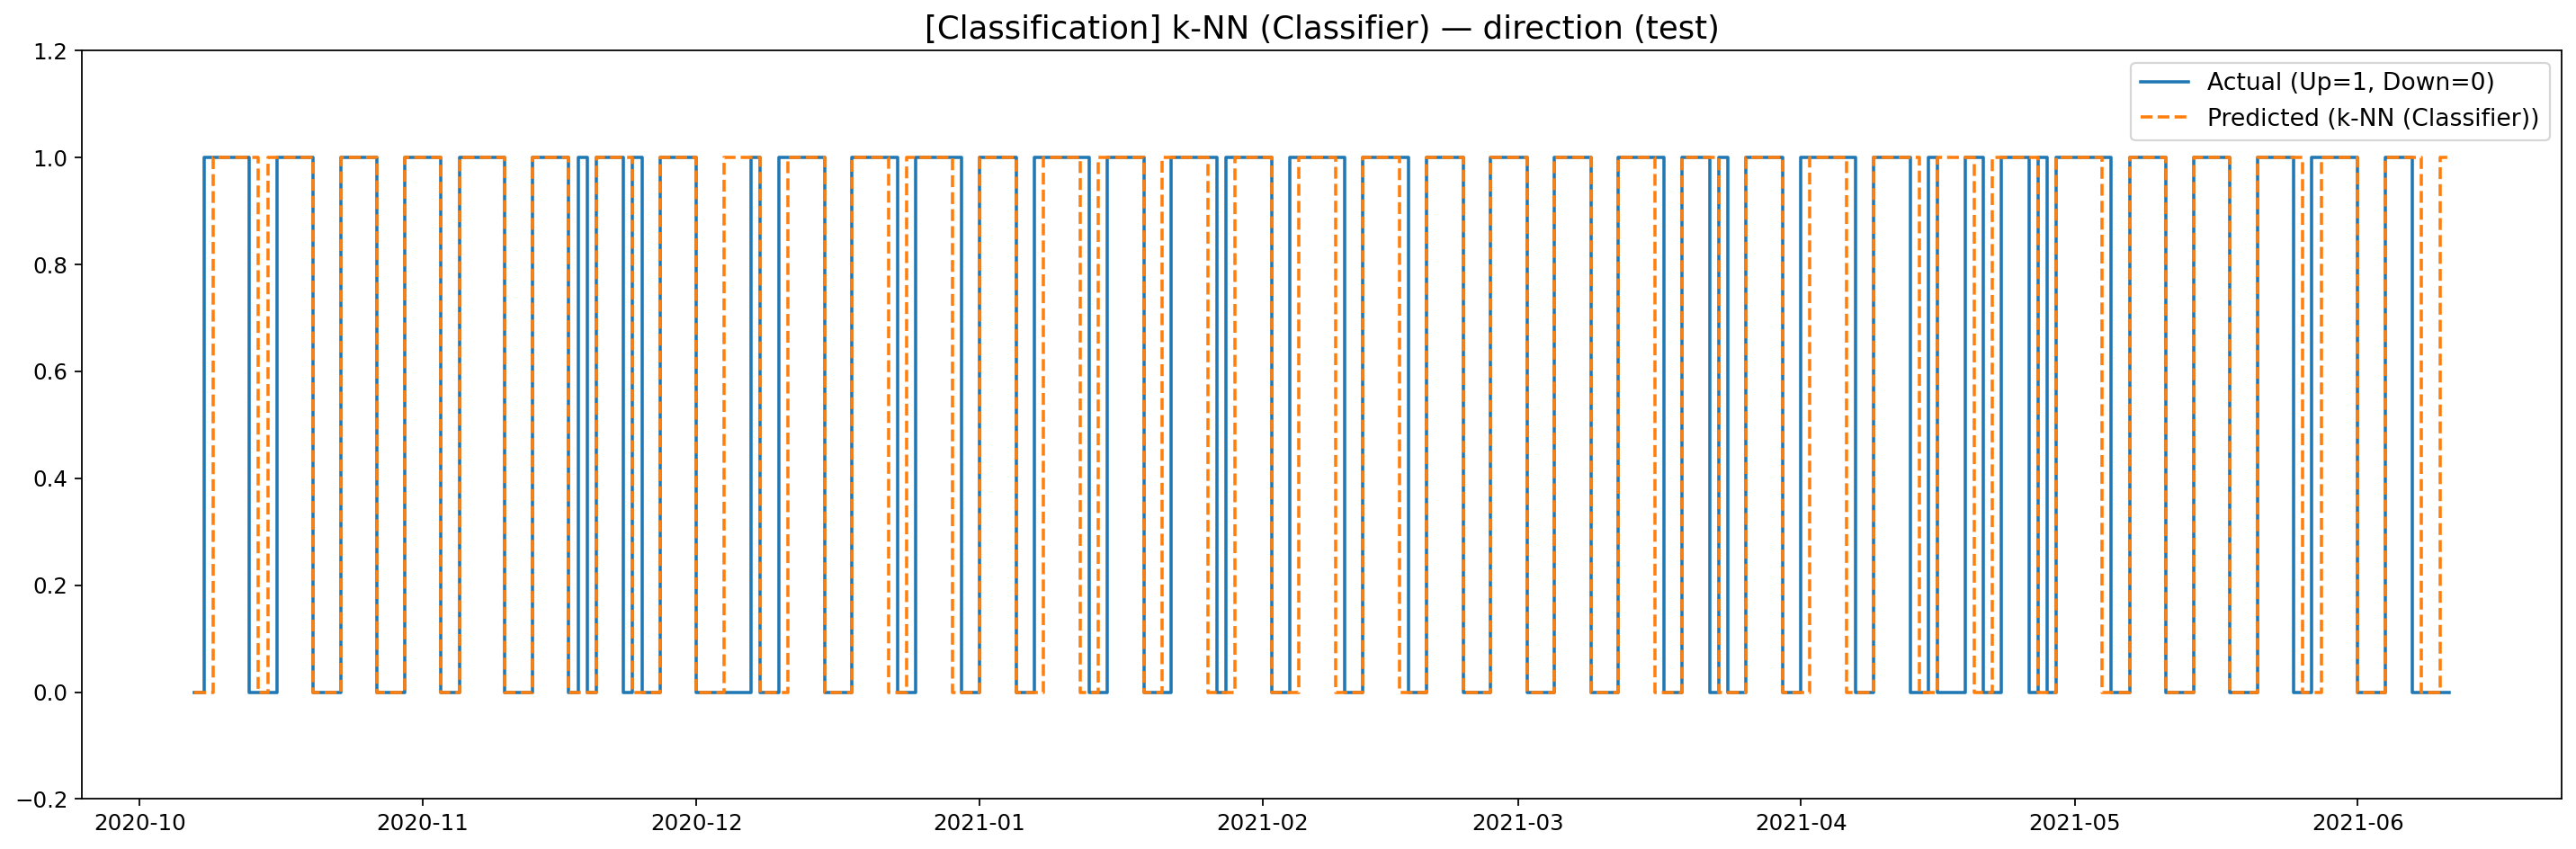

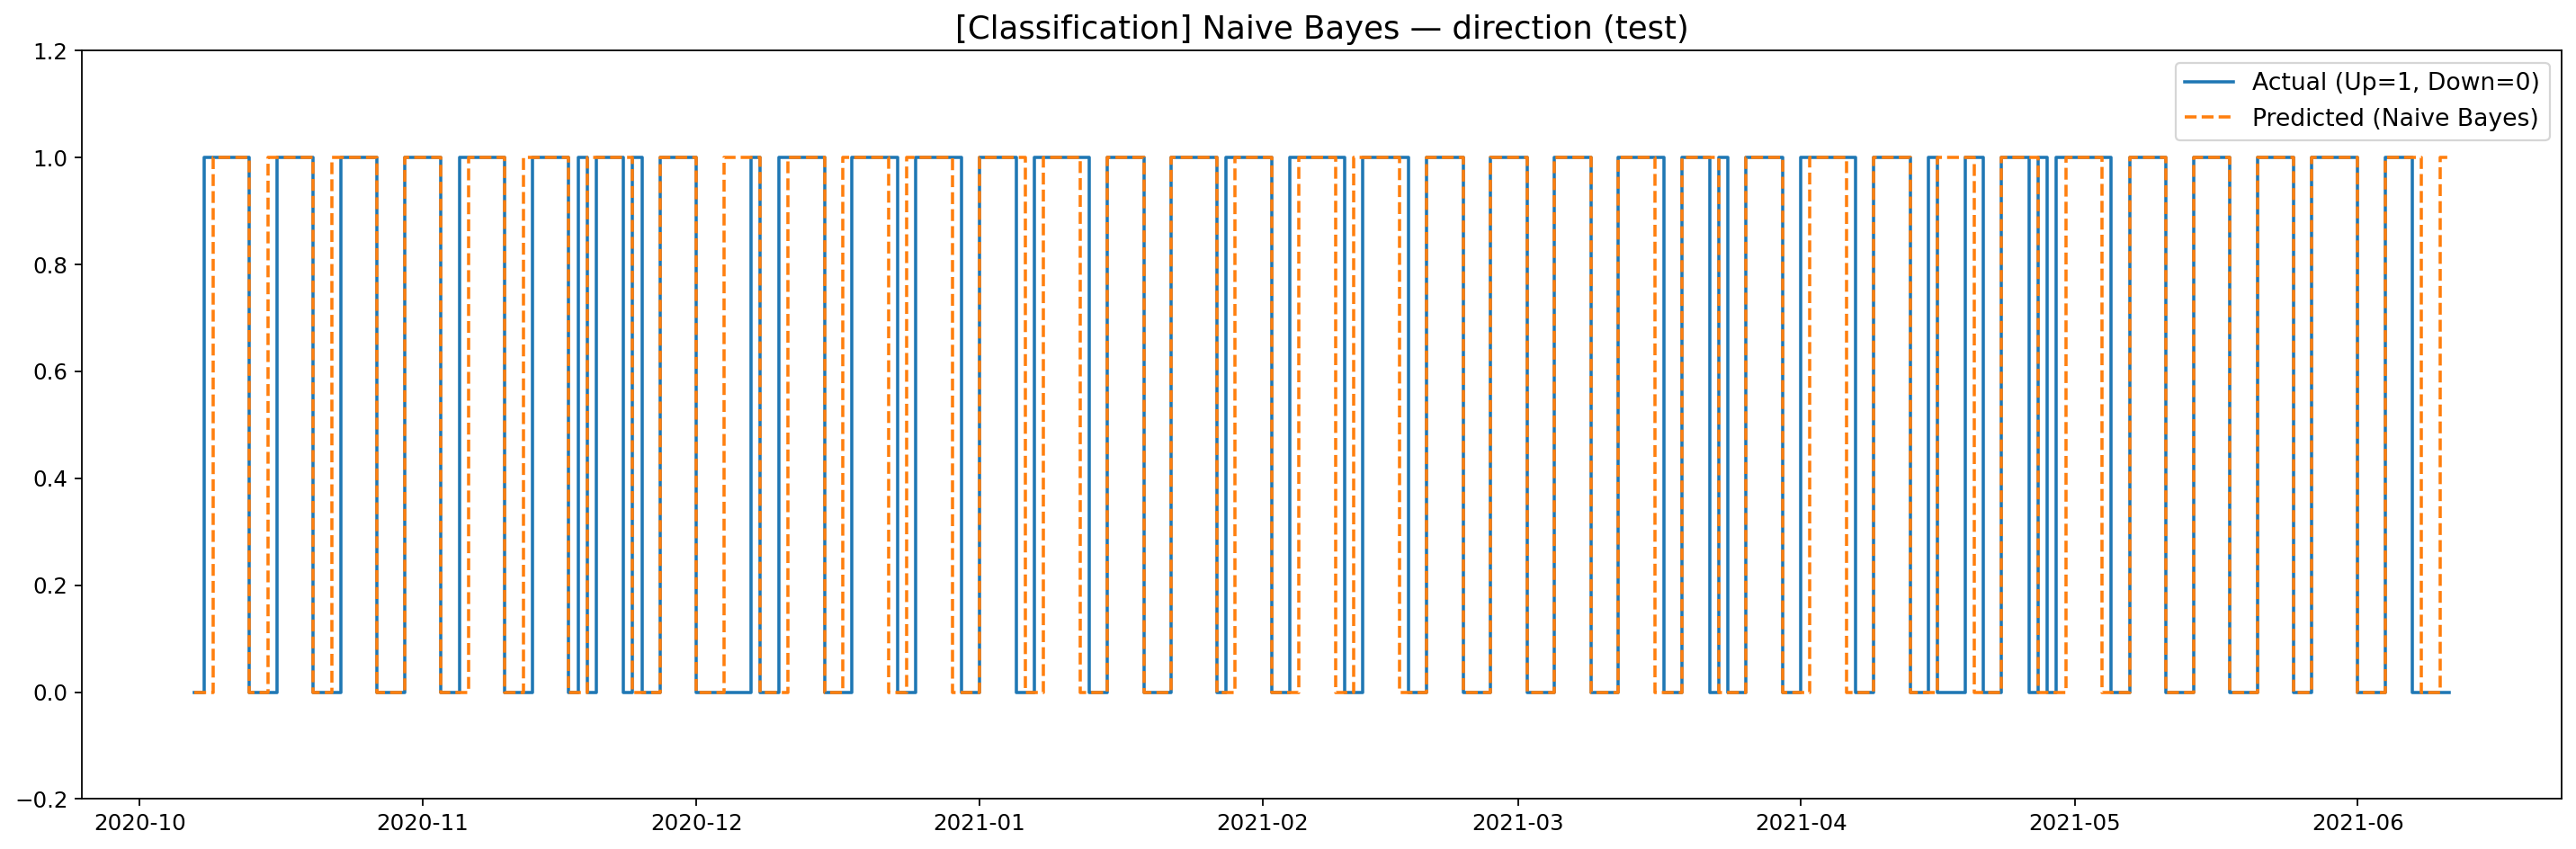

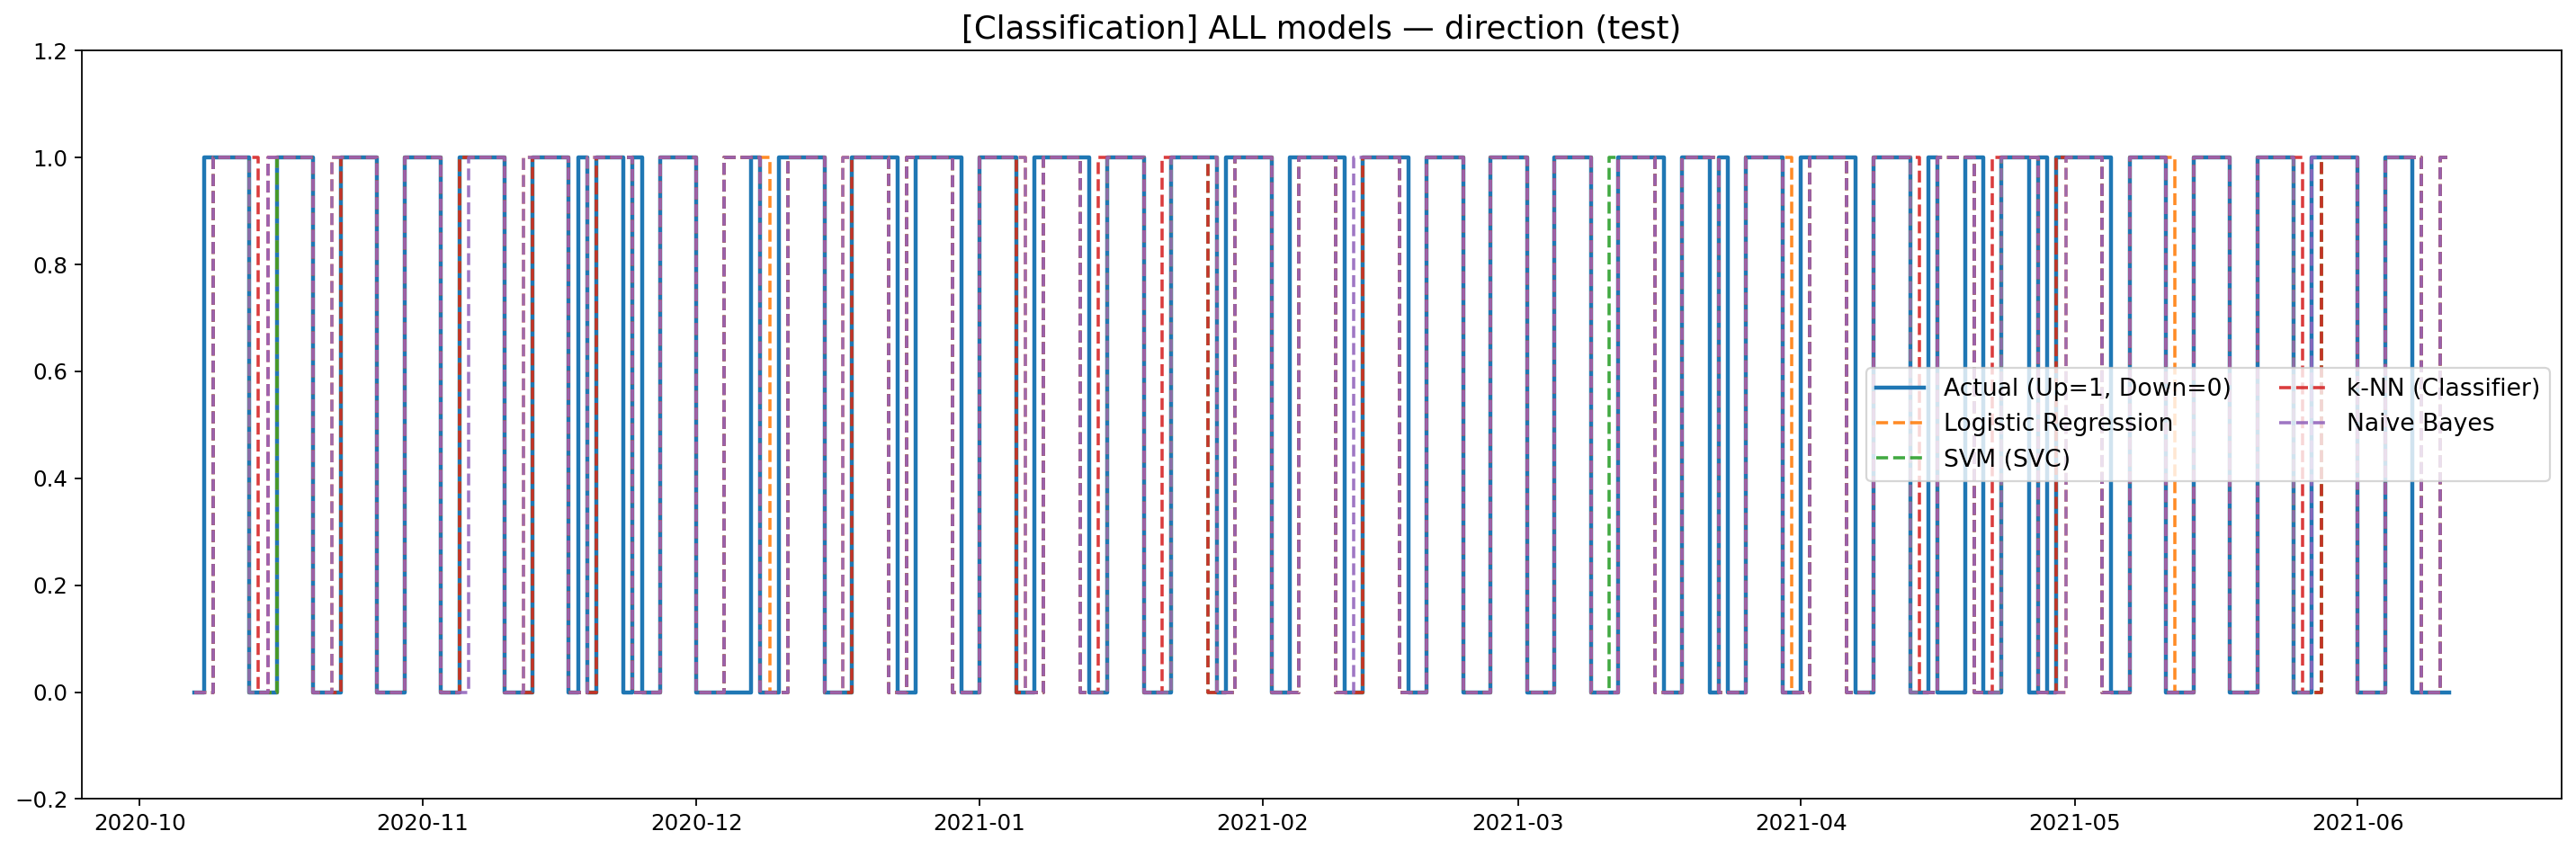

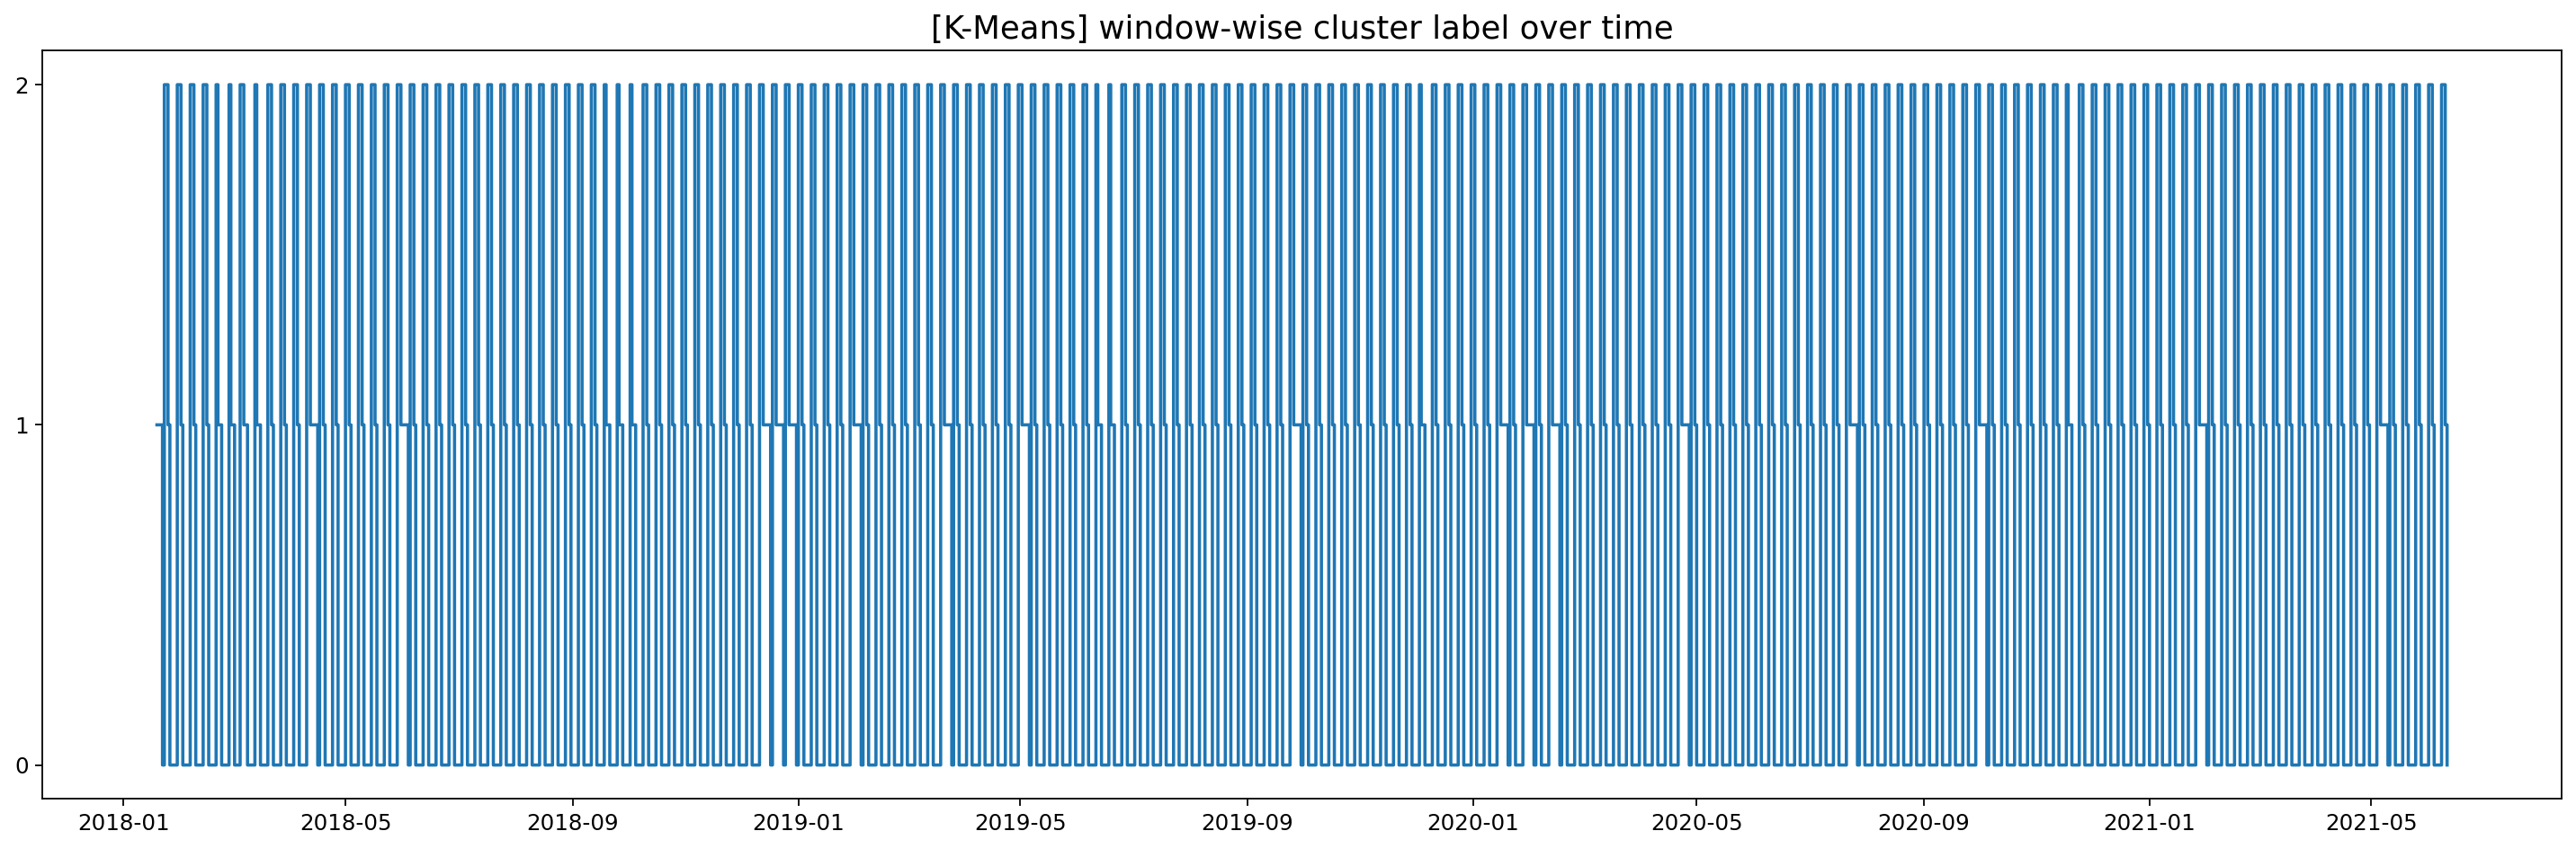

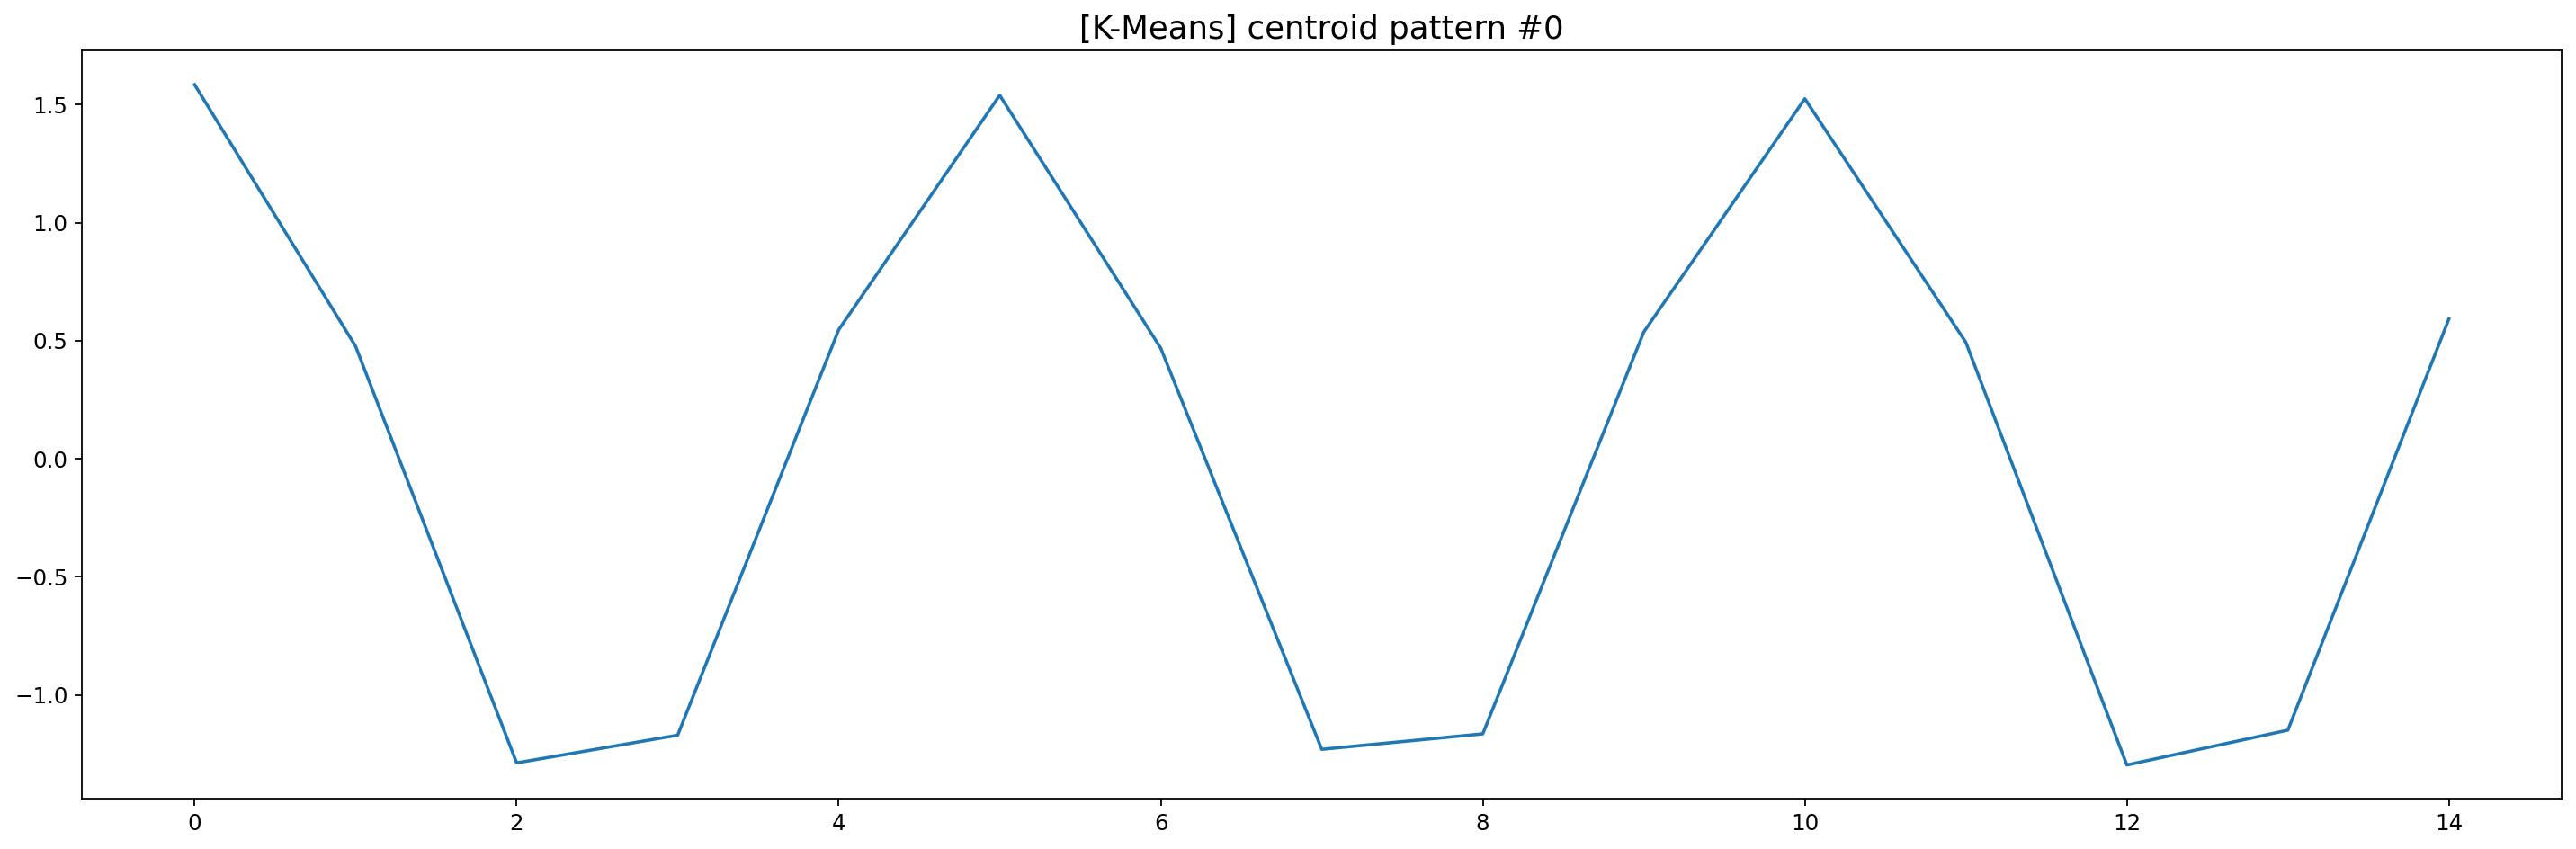

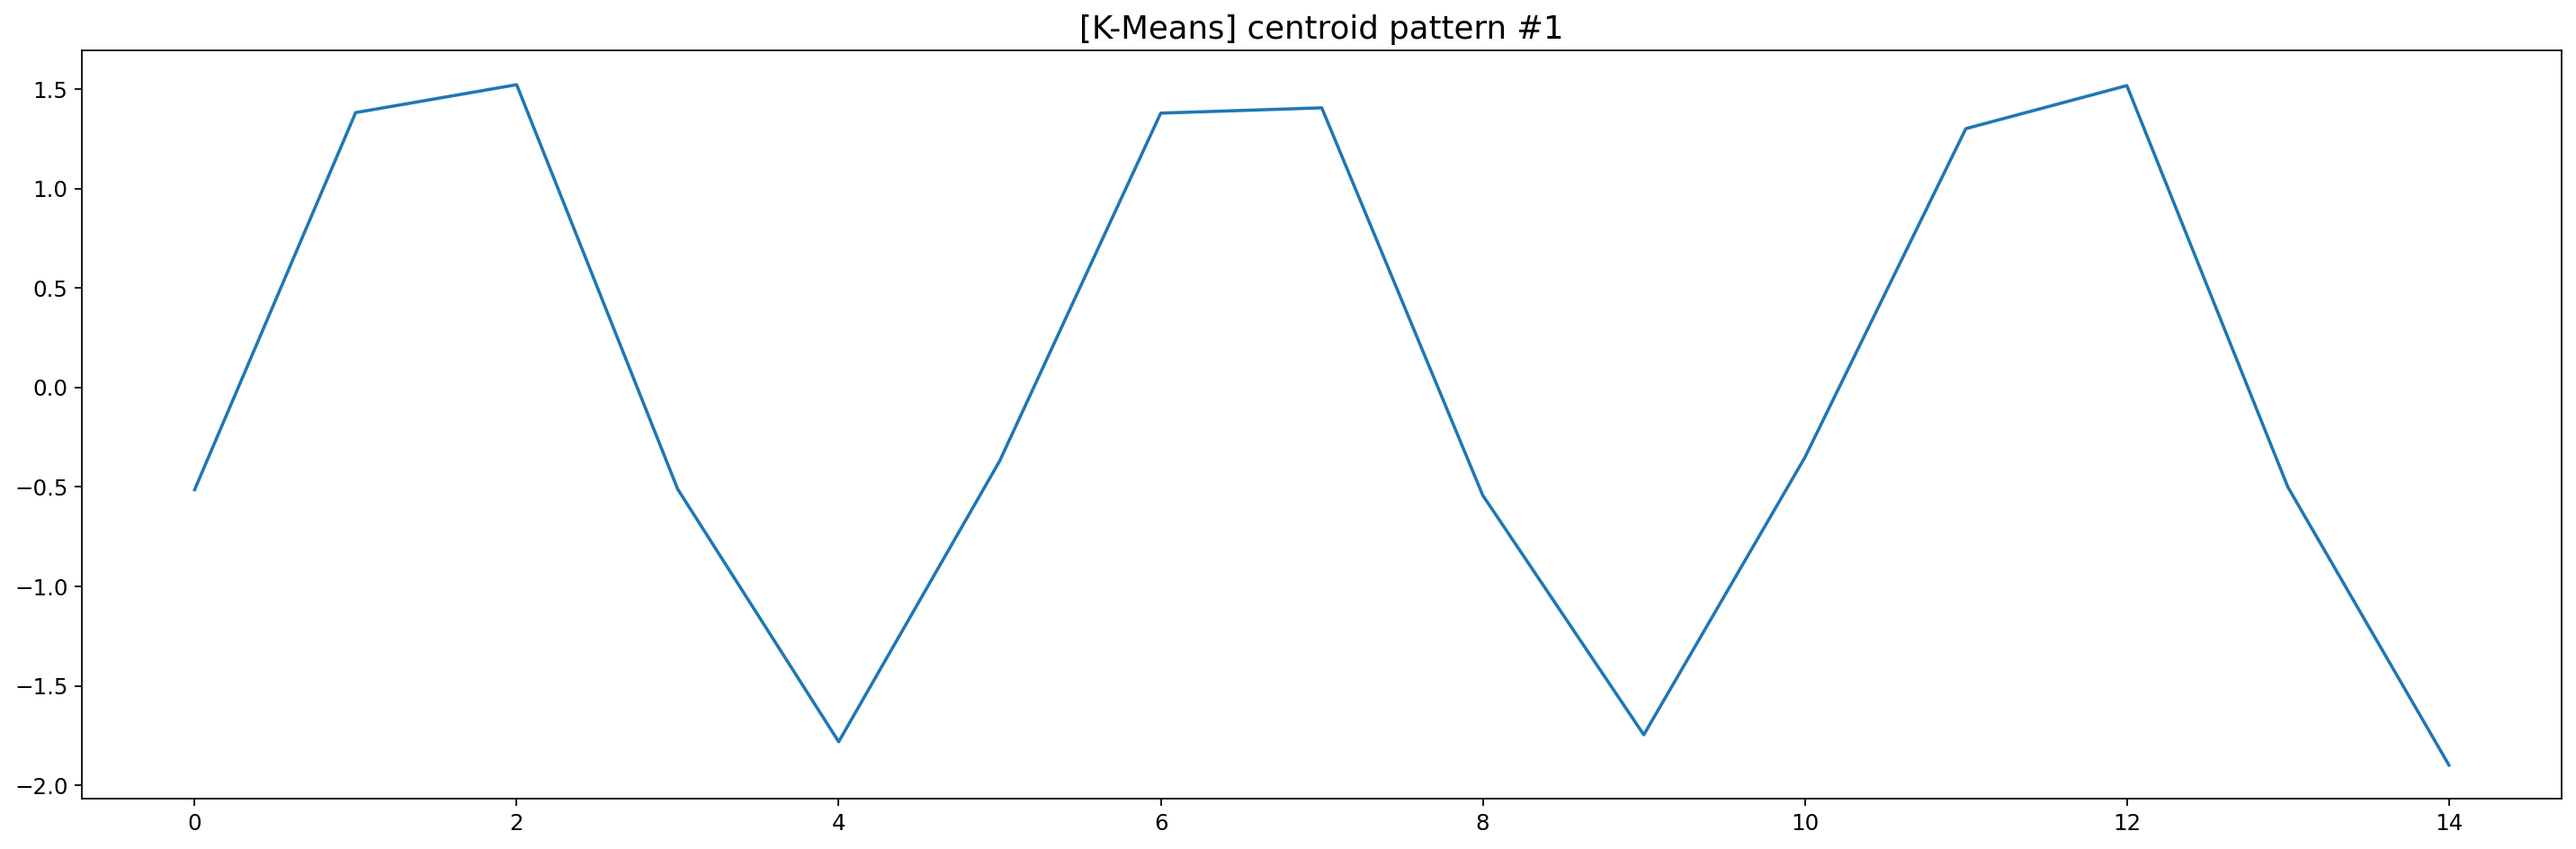

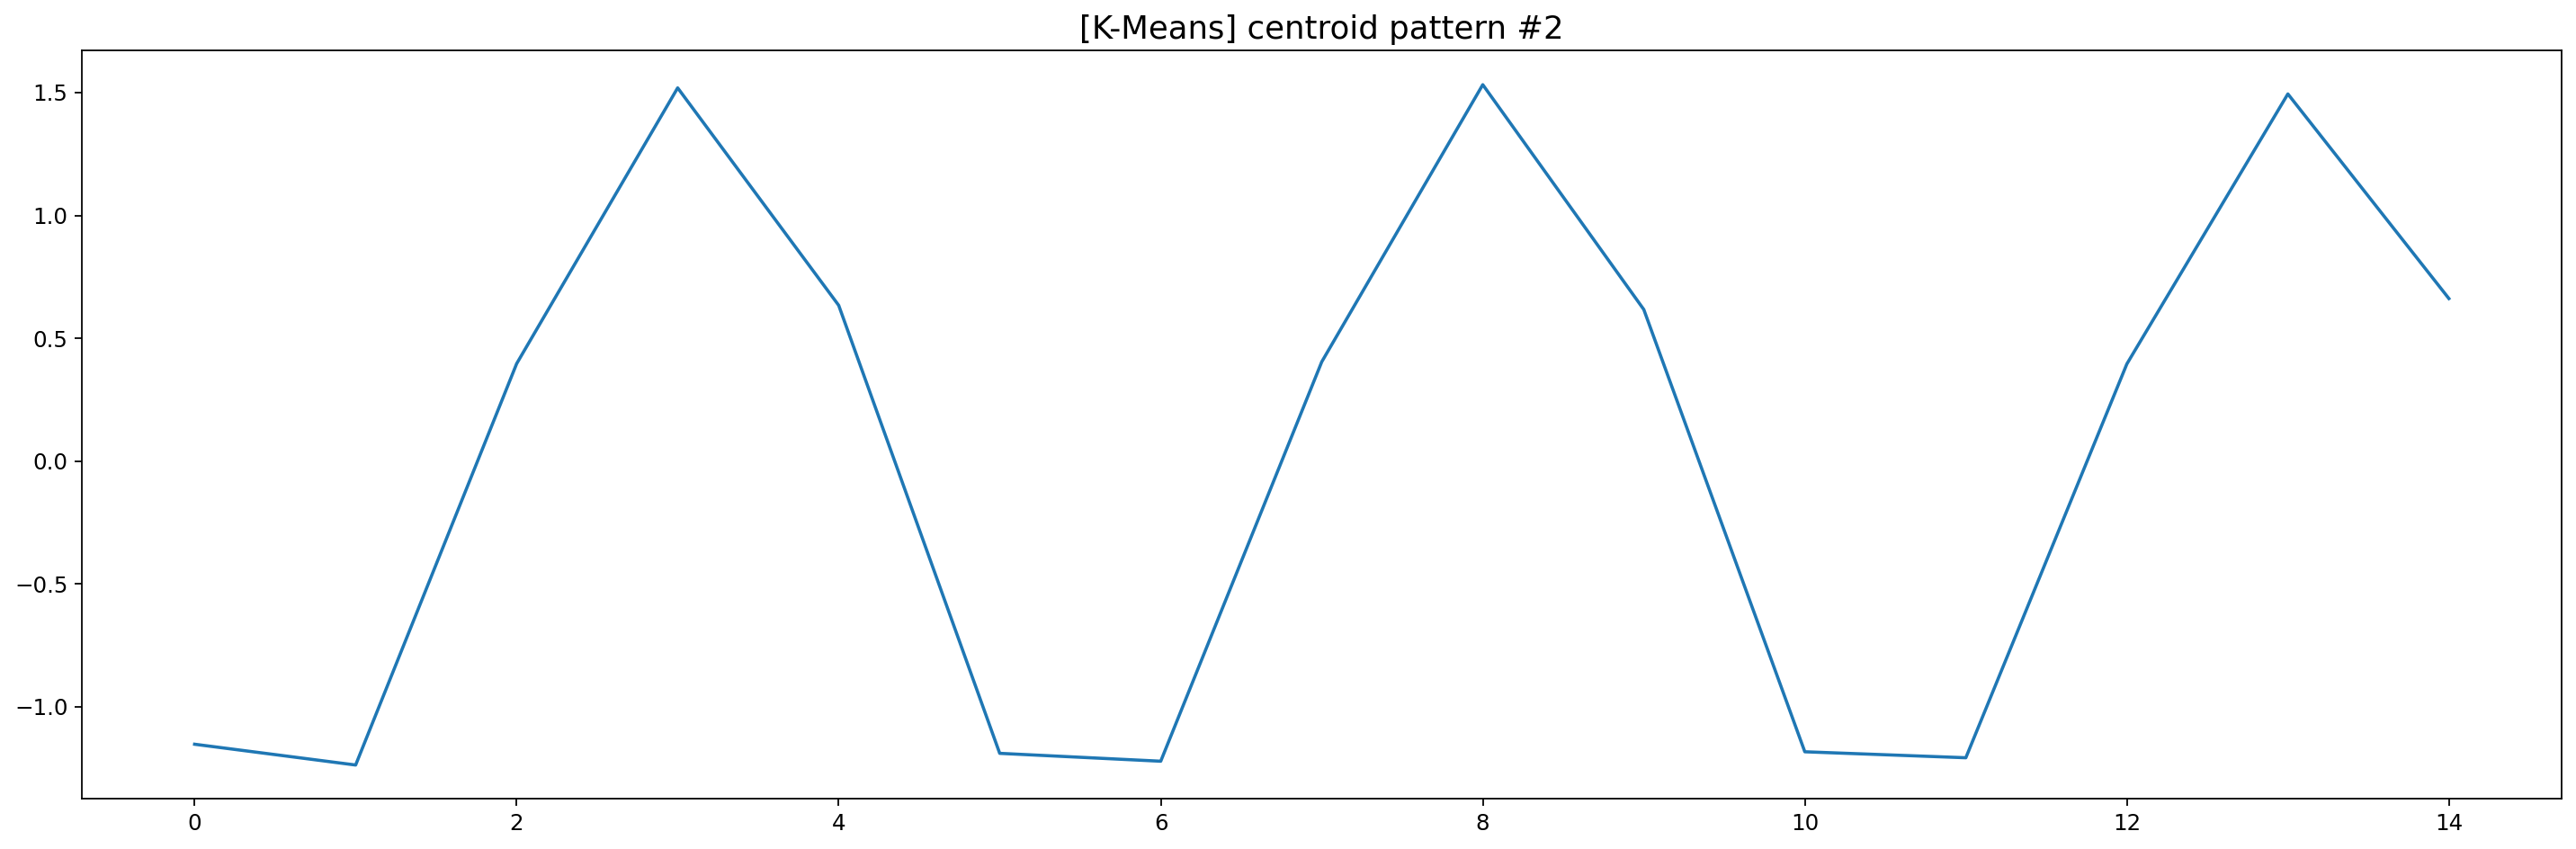

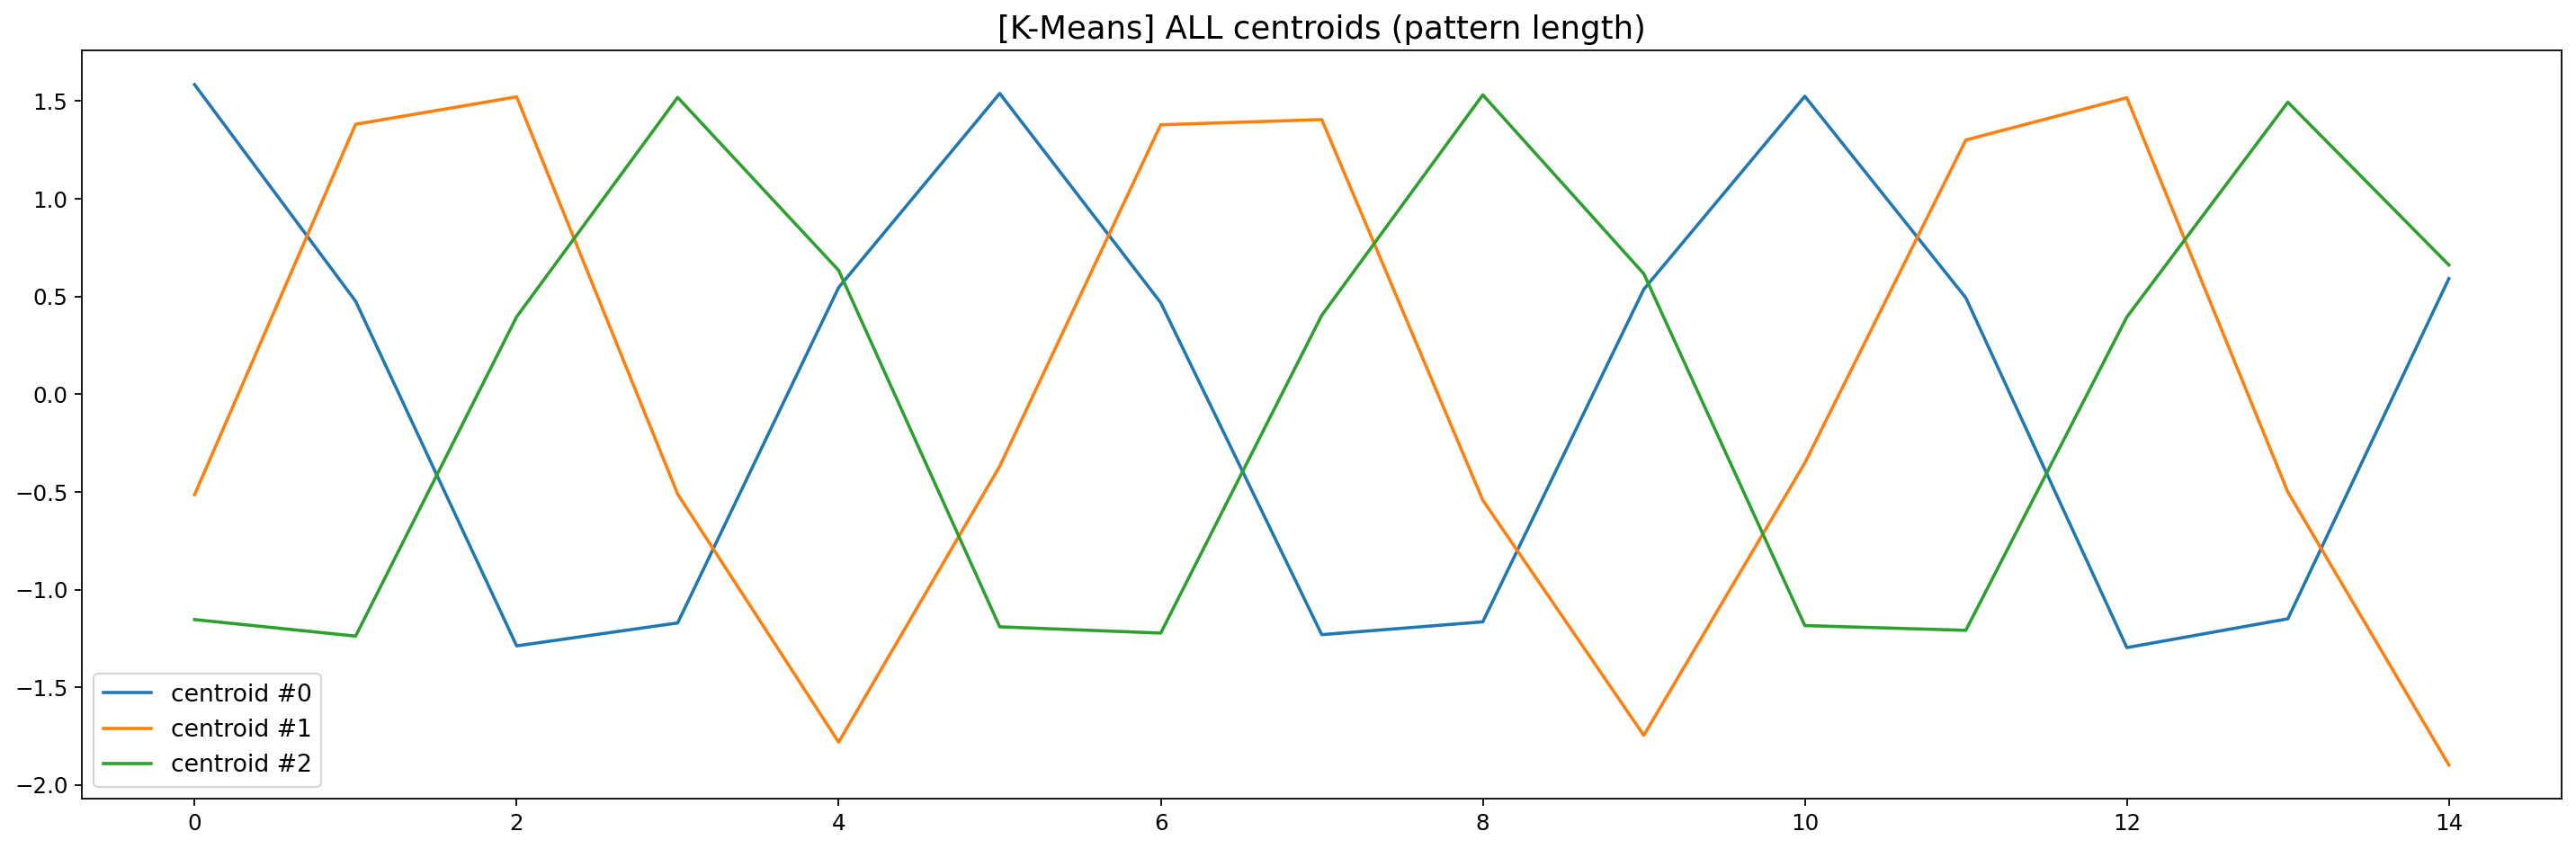

In [8]:
# =============================
# (추가) 전역 그림 설정 – 노트북 맨 위쪽 한 번만
# =============================
import matplotlib as mpl
mpl.rcParams.update({
    "figure.figsize": (18, 6),
    "figure.dpi": 160,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,
    "lines.linewidth": 1.6,
})

# =========================================================
# 5) 시각화: 각 모델 “개별” 그래프 + “합쳐서” 그래프까지
# =========================================================

# ---------- 회귀(5종): 개별 ----------
lookback = 200  # 테스트 테일에서 몇 개만 보기 (너무 길면 겹침)
for name, yhat in preds_reg.items():
    plt.figure()
    plt.plot(dates_reg_te[-lookback:], y_reg_te[-lookback:], label="Actual", alpha=0.9)
    plt.plot(dates_reg_te[-lookback:], yhat[-lookback:], label=name, linestyle="--")
    plt.title(f"[Regression] {name} — next-step prediction (test tail)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- 회귀(5종): 합쳐서 ----------
plt.figure()
plt.plot(dates_reg_te[-lookback:], y_reg_te[-lookback:], label="Actual", color="black")
for name, yhat in preds_reg.items():
    plt.plot(dates_reg_te[-lookback:], yhat[-lookback:], label=name, linestyle="--")
plt.title("[Regression] ALL models — next-step prediction (test tail)")
plt.legend(ncol=2); plt.tight_layout(); plt.show()


# ---------- 분류(4종): 개별 ----------
# y_cls_te ∈ {0,1}, 각 모델의 예측도 0/1
for name, yhat in preds_cls.items():
    plt.figure()
    plt.step(dates_cls_te, y_cls_te, where="post", label="Actual (Up=1, Down=0)")
    plt.step(dates_cls_te, yhat, where="post", label=f"Predicted ({name})", linestyle="--")
    plt.ylim(-0.2, 1.2)
    plt.title(f"[Classification] {name} — direction (test)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- 분류(4종): 합쳐서 ----------
plt.figure()
plt.step(dates_cls_te, y_cls_te, where="post", label="Actual (Up=1, Down=0)", linewidth=2)
for name, yhat in preds_cls.items():
    plt.step(dates_cls_te, yhat, where="post", label=name, linestyle="--", alpha=0.9)
plt.ylim(-0.2, 1.2)
plt.title("[Classification] ALL models — direction (test)")
plt.legend(ncol=2); plt.tight_layout(); plt.show()


# ---------- K-Means(1종): 개별 ----------
# 1) 윈도우별 군집 라벨의 시간 전개(예측 라벨)
plt.figure()
plt.step(dates_pat, labels_all, where="post")
plt.yticks(sorted(np.unique(labels_all)))
plt.title("[K-Means] window-wise cluster label over time")
plt.tight_layout(); plt.show()

# 2) 각 클러스터 중심 패턴(centroid) – 개별
for i, c in enumerate(kmeans.cluster_centers_):
    plt.figure()
    plt.plot(range(len(c)), c)
    plt.title(f"[K-Means] centroid pattern #{i}")
    plt.tight_layout(); plt.show()

# ---------- K-Means: 합쳐서(centroid들 한 장에) ----------
plt.figure()
for i, c in enumerate(kmeans.cluster_centers_):
    plt.plot(range(len(c)), c, label=f"centroid #{i}")
plt.title("[K-Means] ALL centroids (pattern length)")
plt.legend(); plt.tight_layout(); plt.show()


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1958251401.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p0 = float(price.loc[:dates_te[0]].iloc[-1])   # ★ 스칼라로 안전 추출 (FutureWarning 회피)


TSLA: 1954 prices | 2018-01-02 ~ 2025-10-09

[Regression] Metrics (return % and price)
                          Model  RMSE(ret%)  MAE(ret%)  R2(ret%)  Price RMSE  Price MAE
              Linear Regression    4.219965   3.095495 -0.014974   78.205506  56.713751
      Neural Net (MLPRegressor)    4.223818   3.090019 -0.016829  151.651530 126.127389
                  Random Forest    4.297437   3.186380 -0.052583   94.269455  72.559399
GBM (GradientBoostingRegressor)    4.467579   3.259330 -0.137580  109.352978  83.779862
                  Decision Tree    5.432662   4.271755 -0.682142  110.889861  83.208039

[KMeans] Cluster counts: {0: np.int64(664), 1: np.int64(694), 2: np.int64(581)}


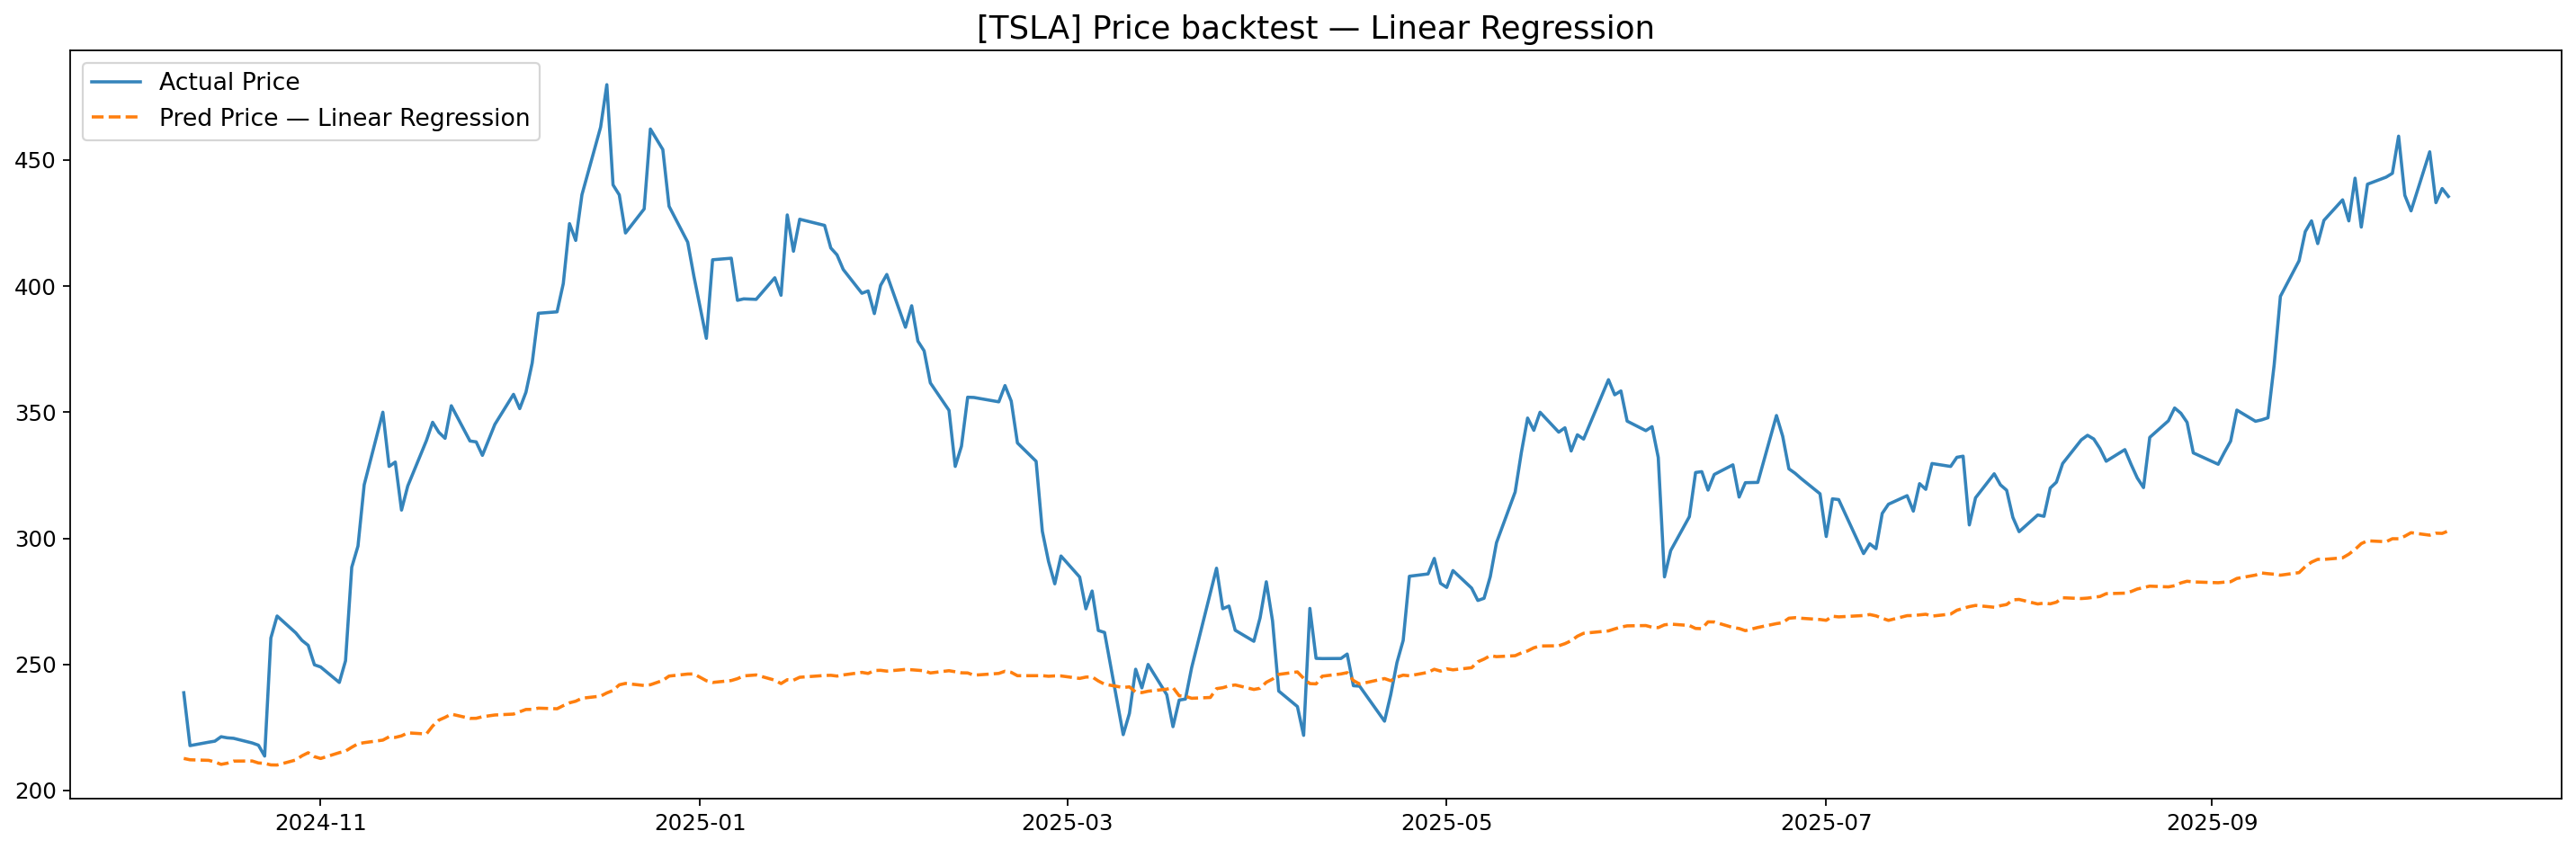

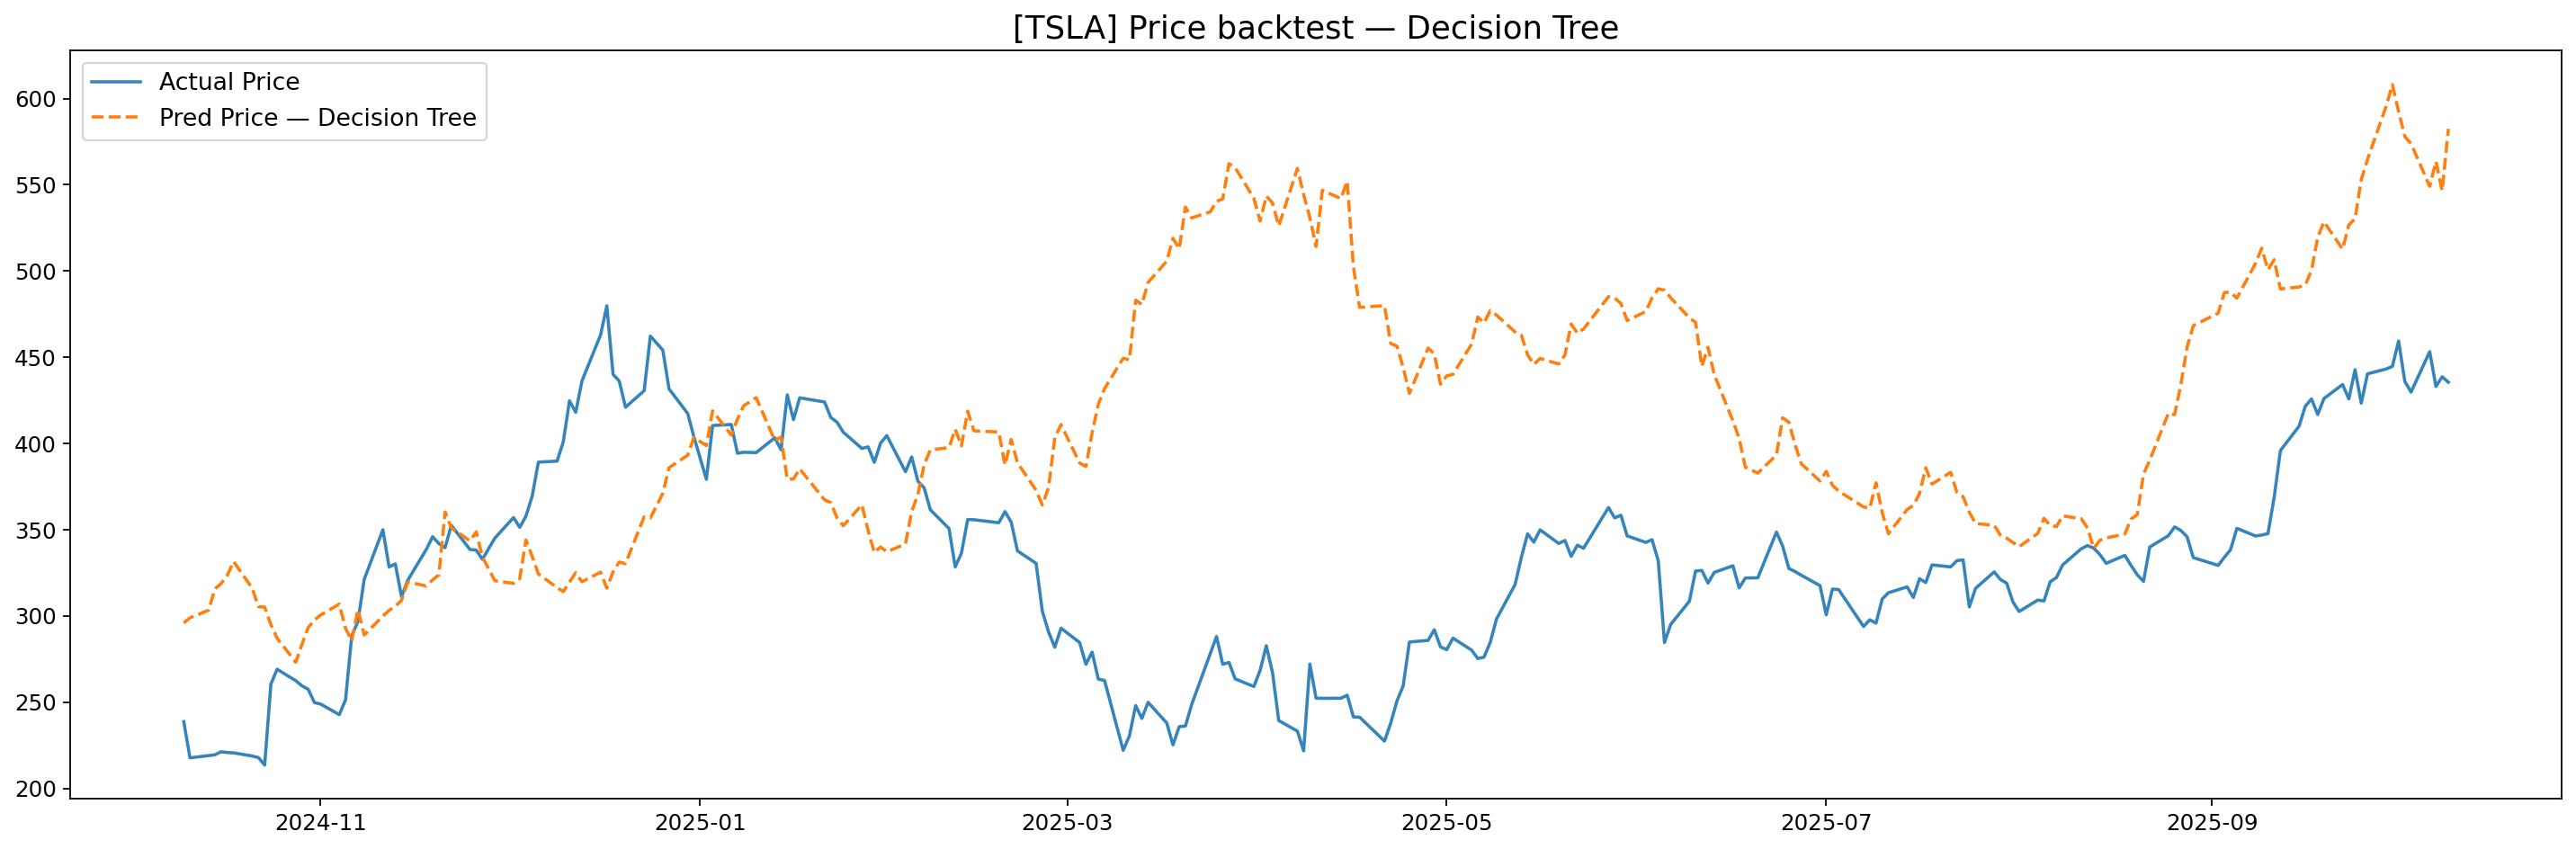

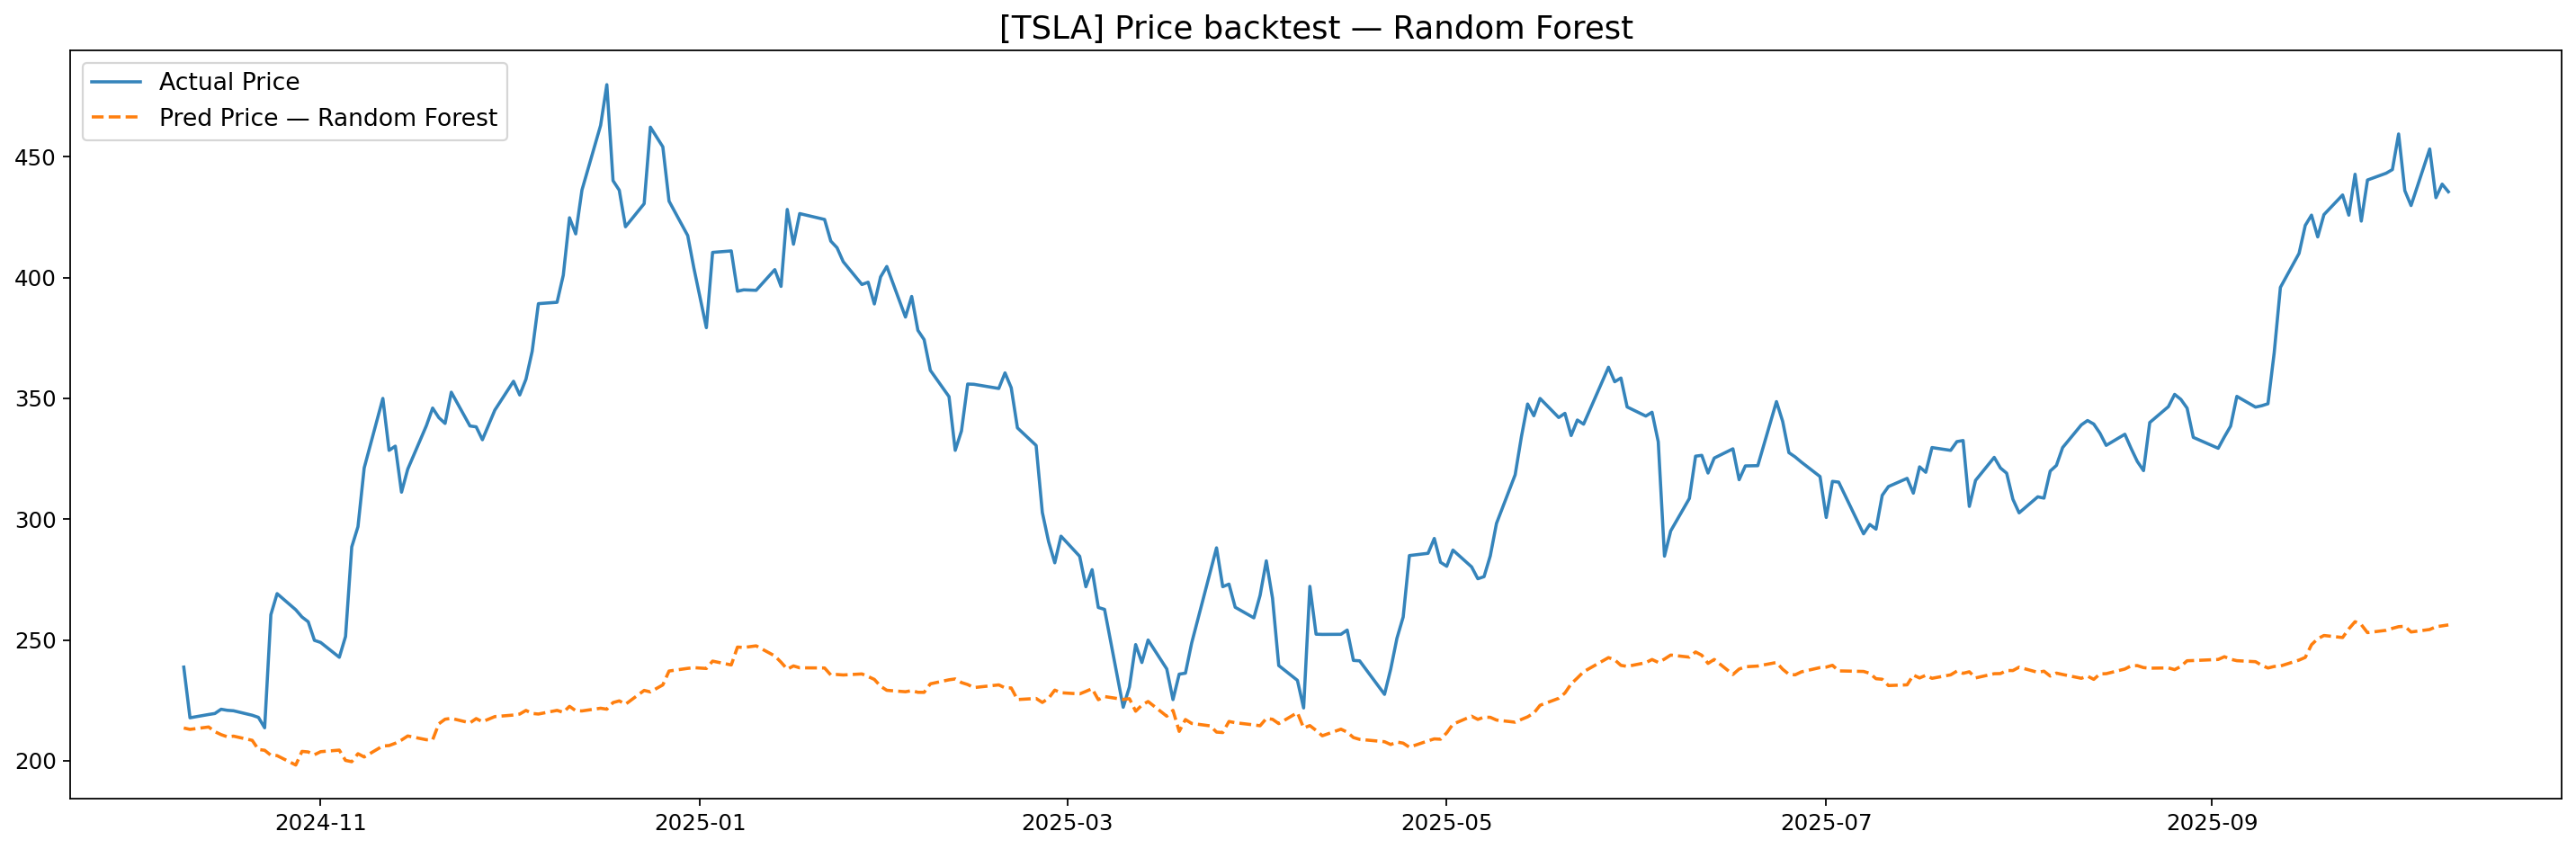

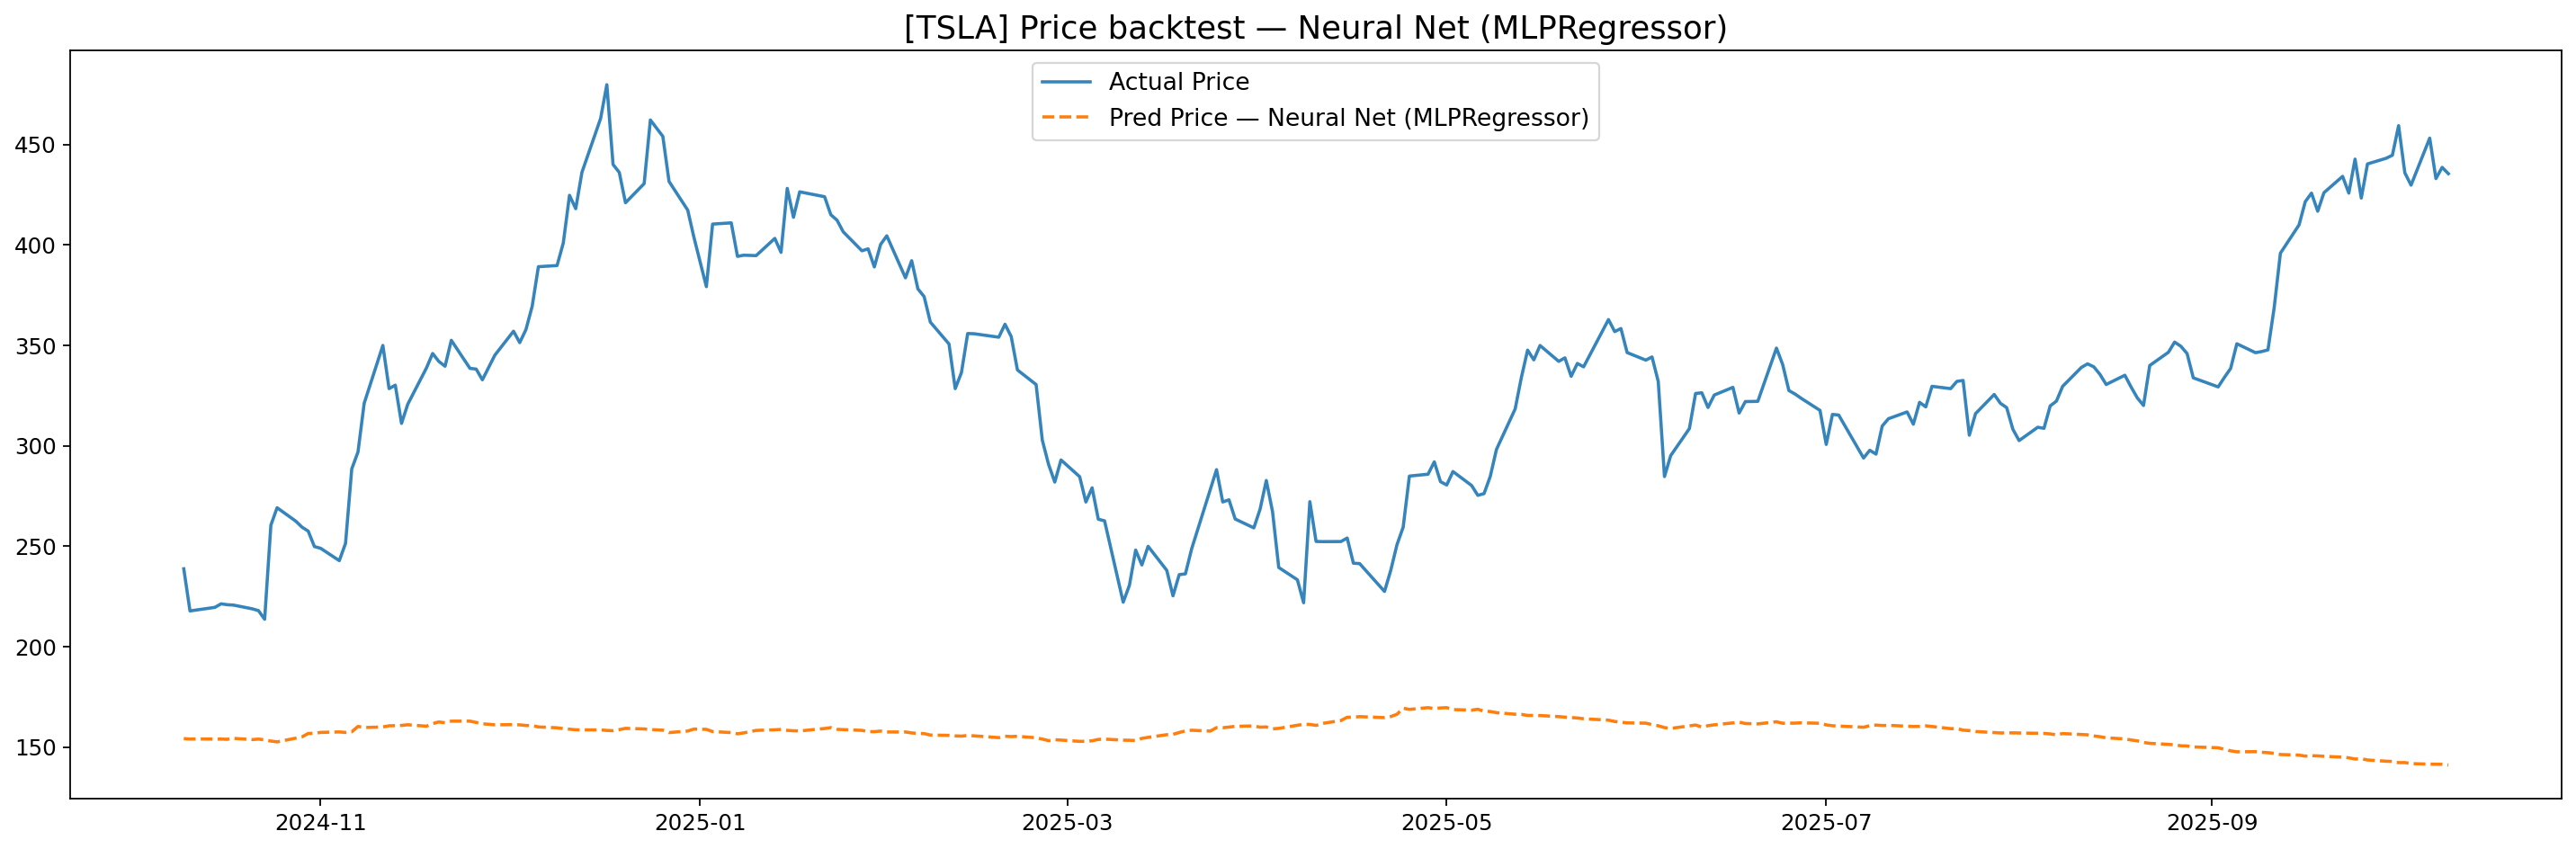

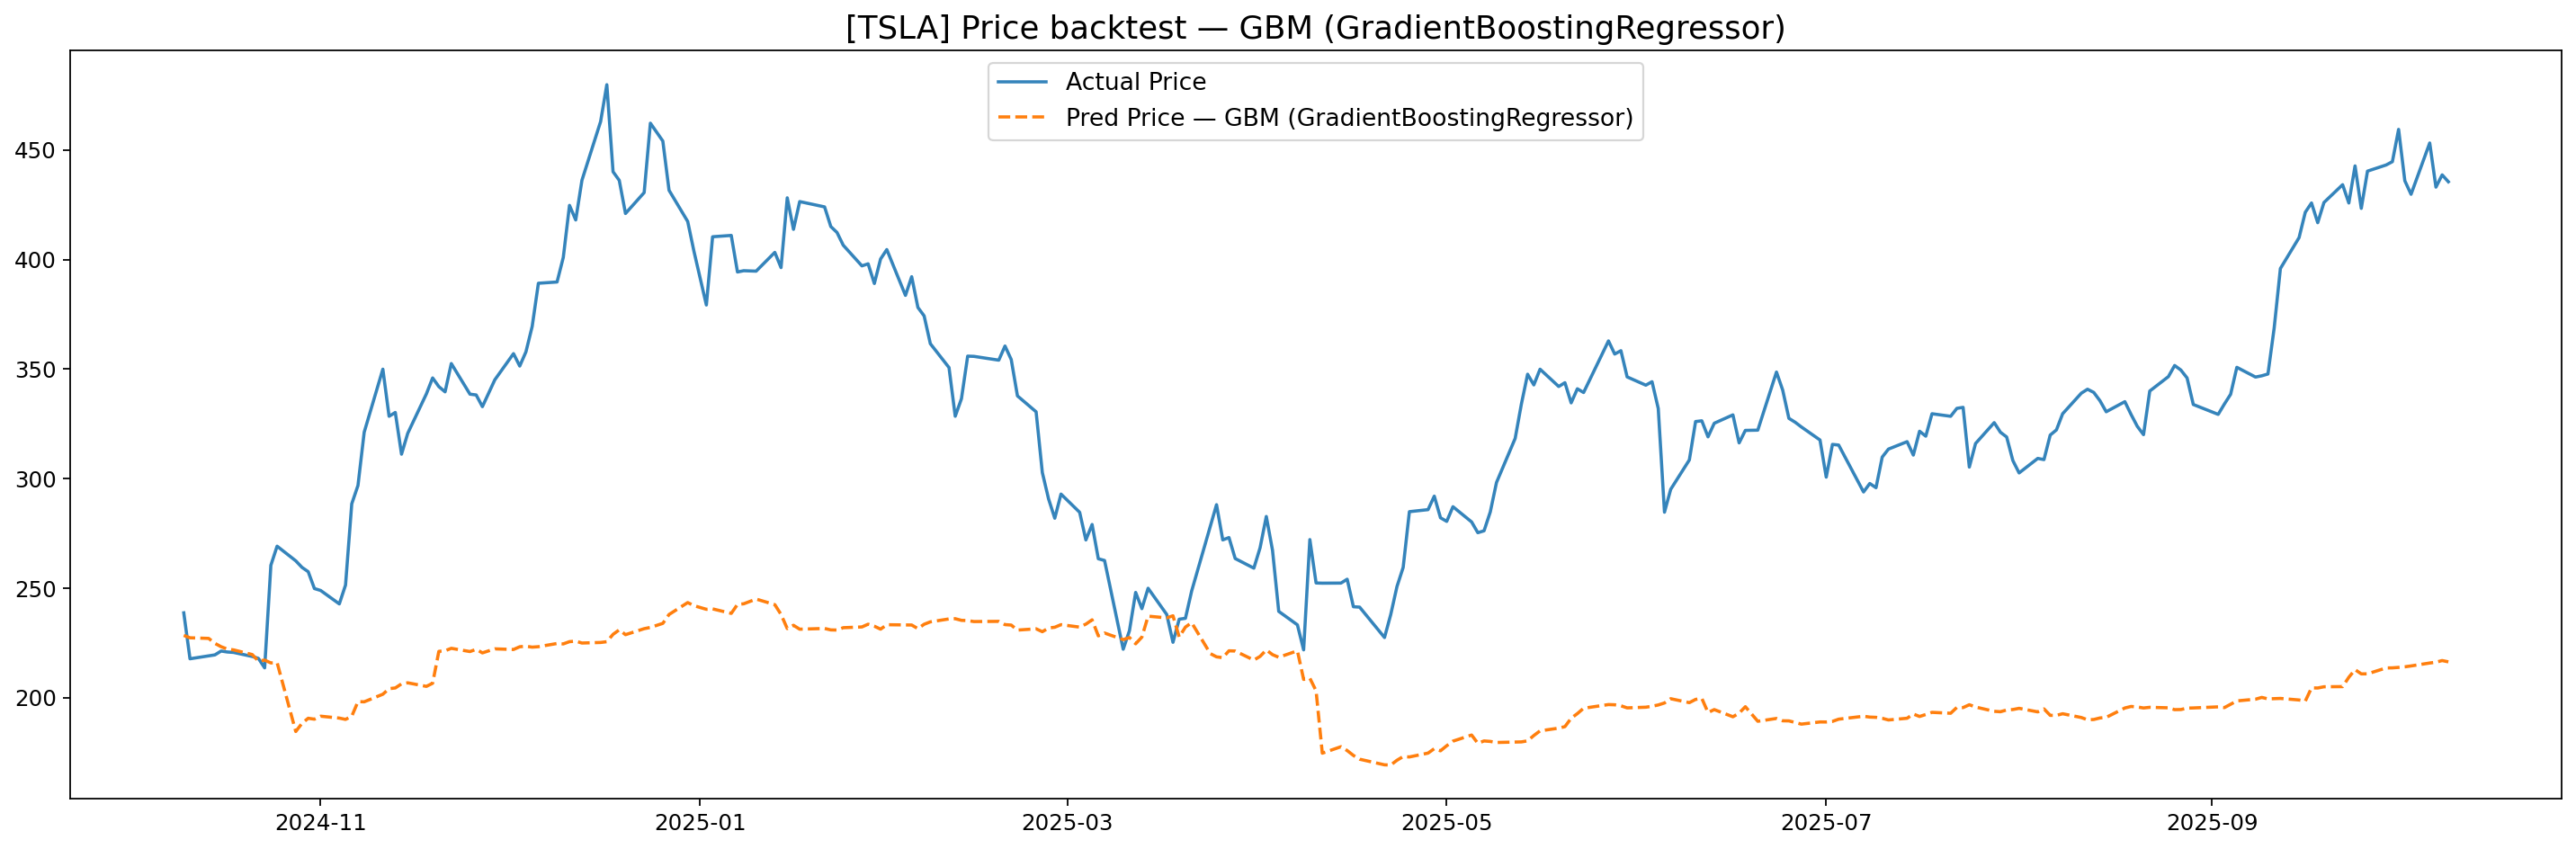

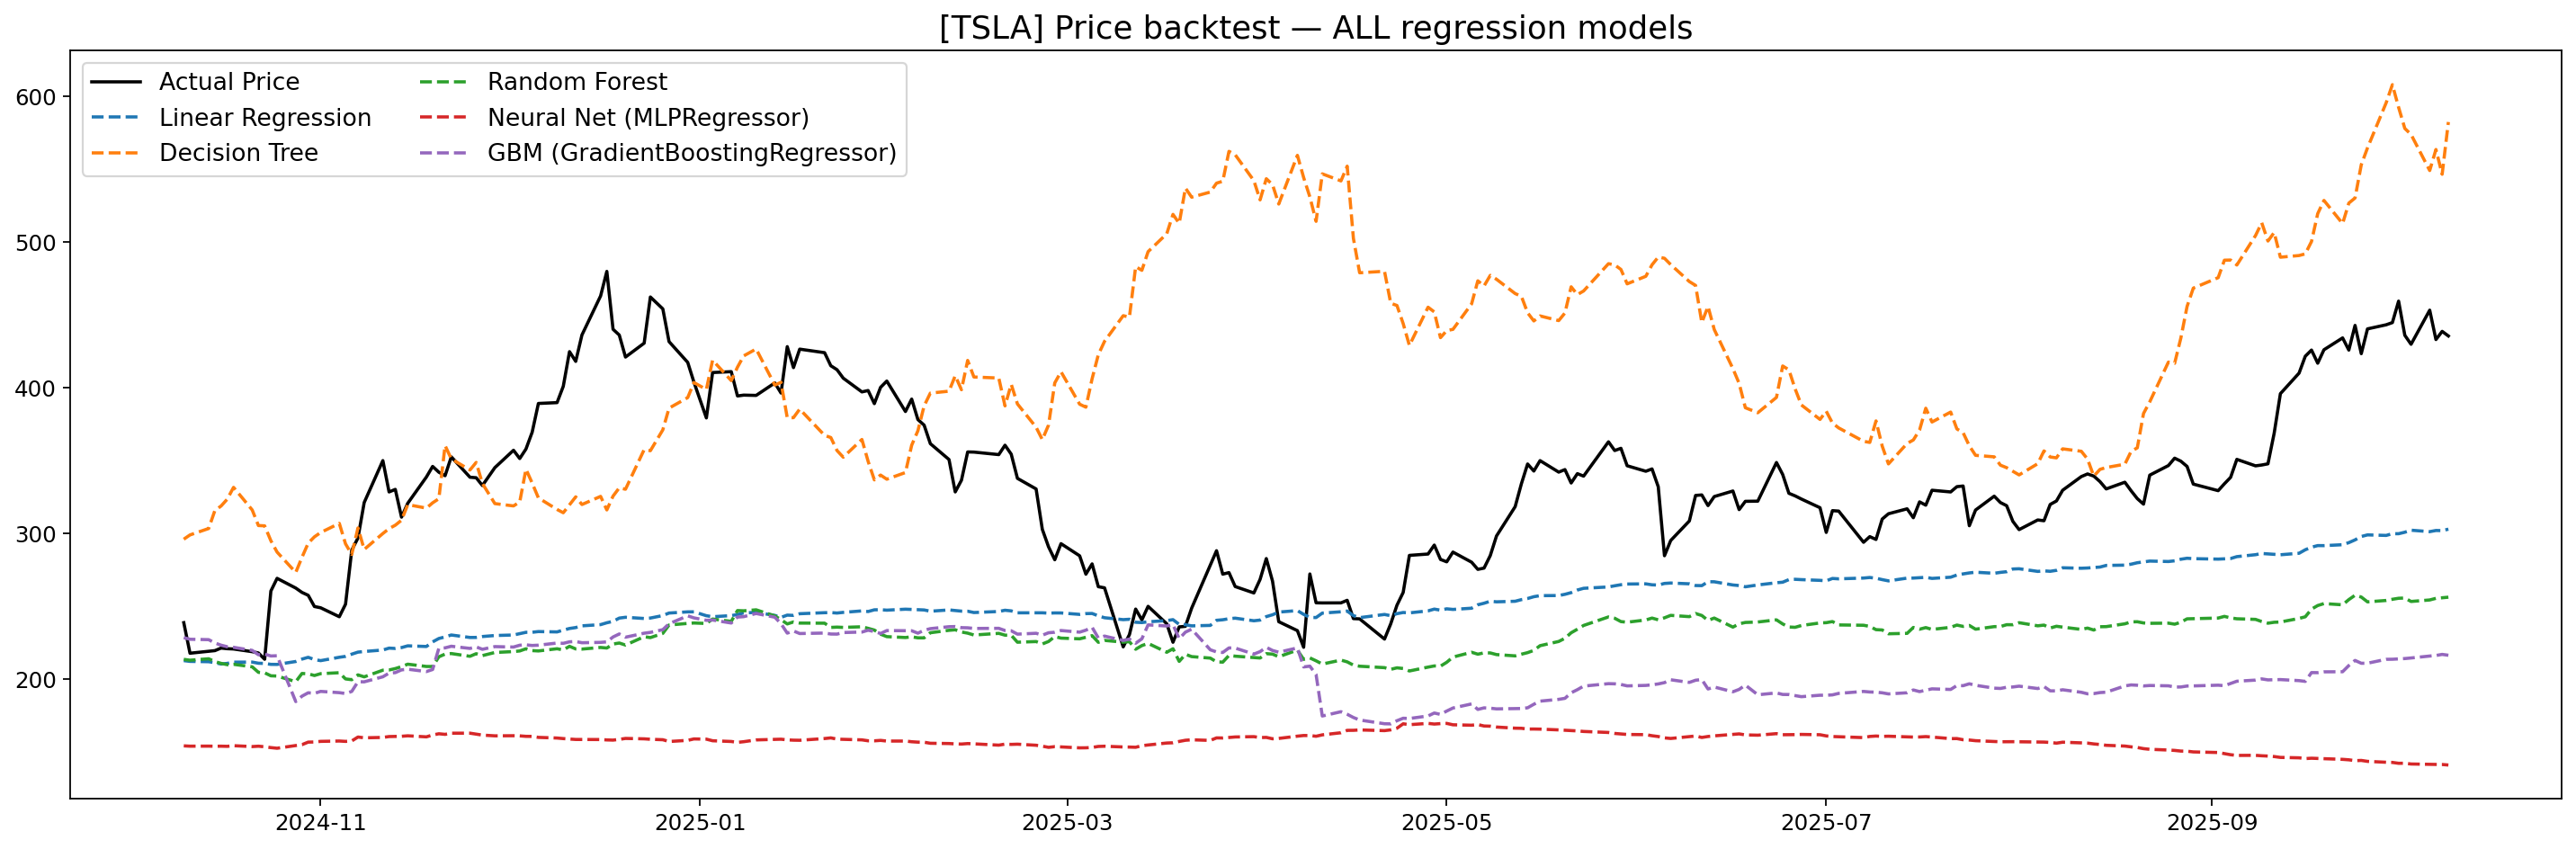

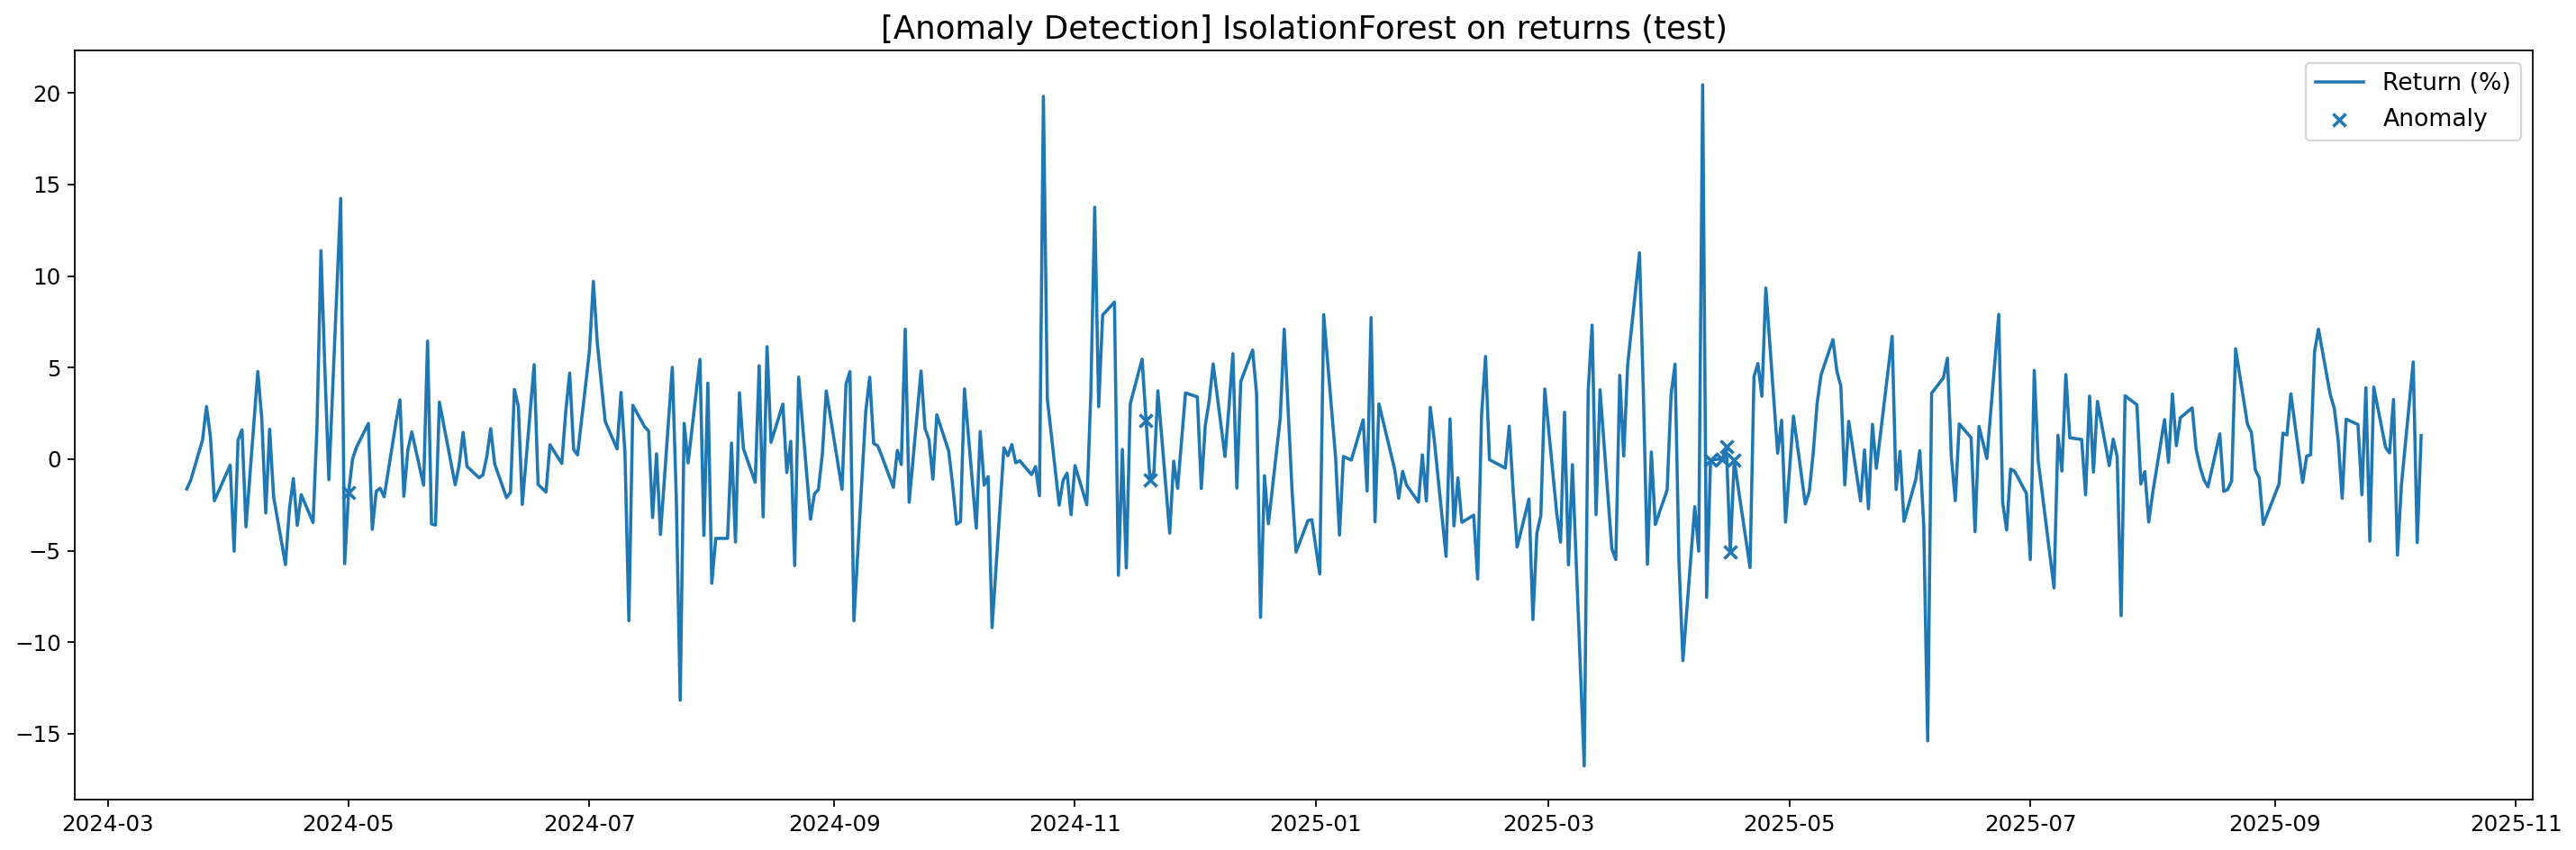

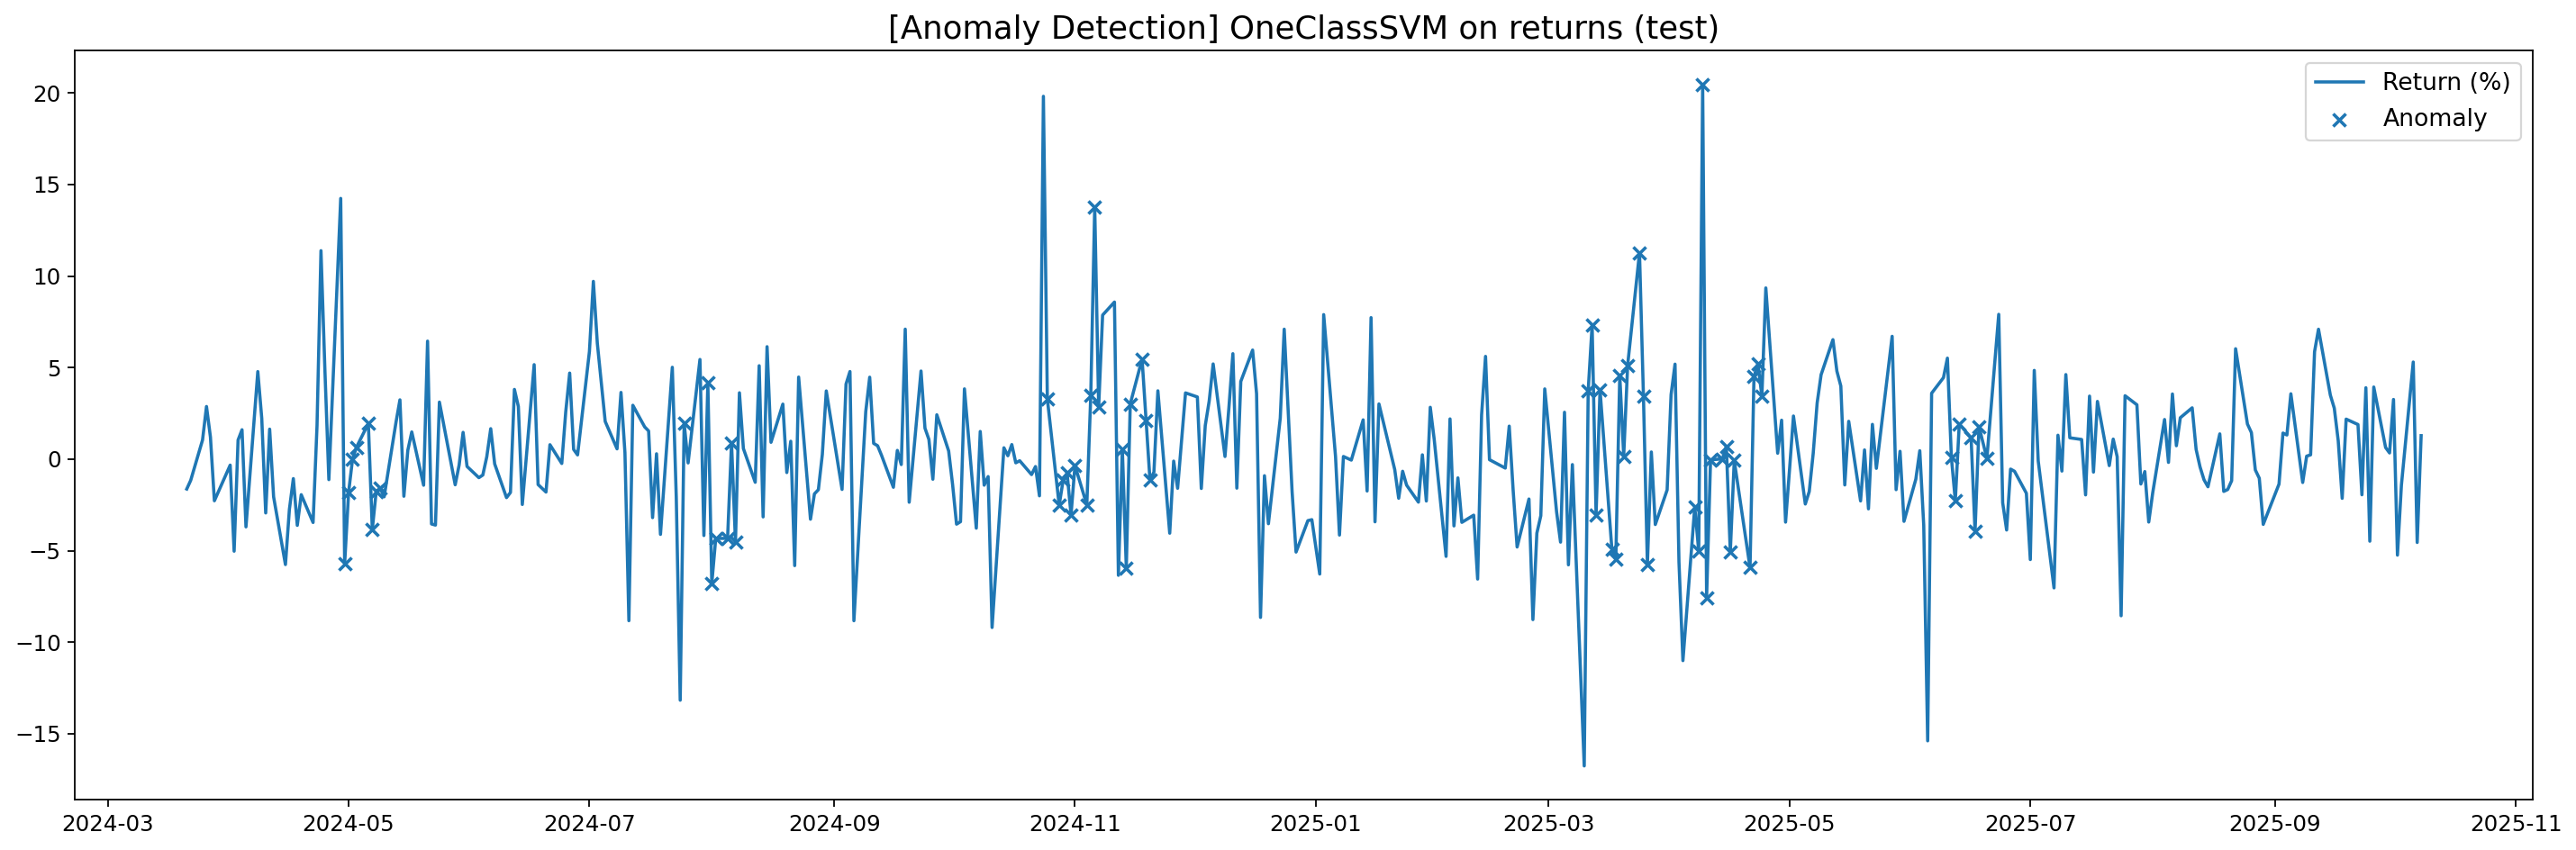

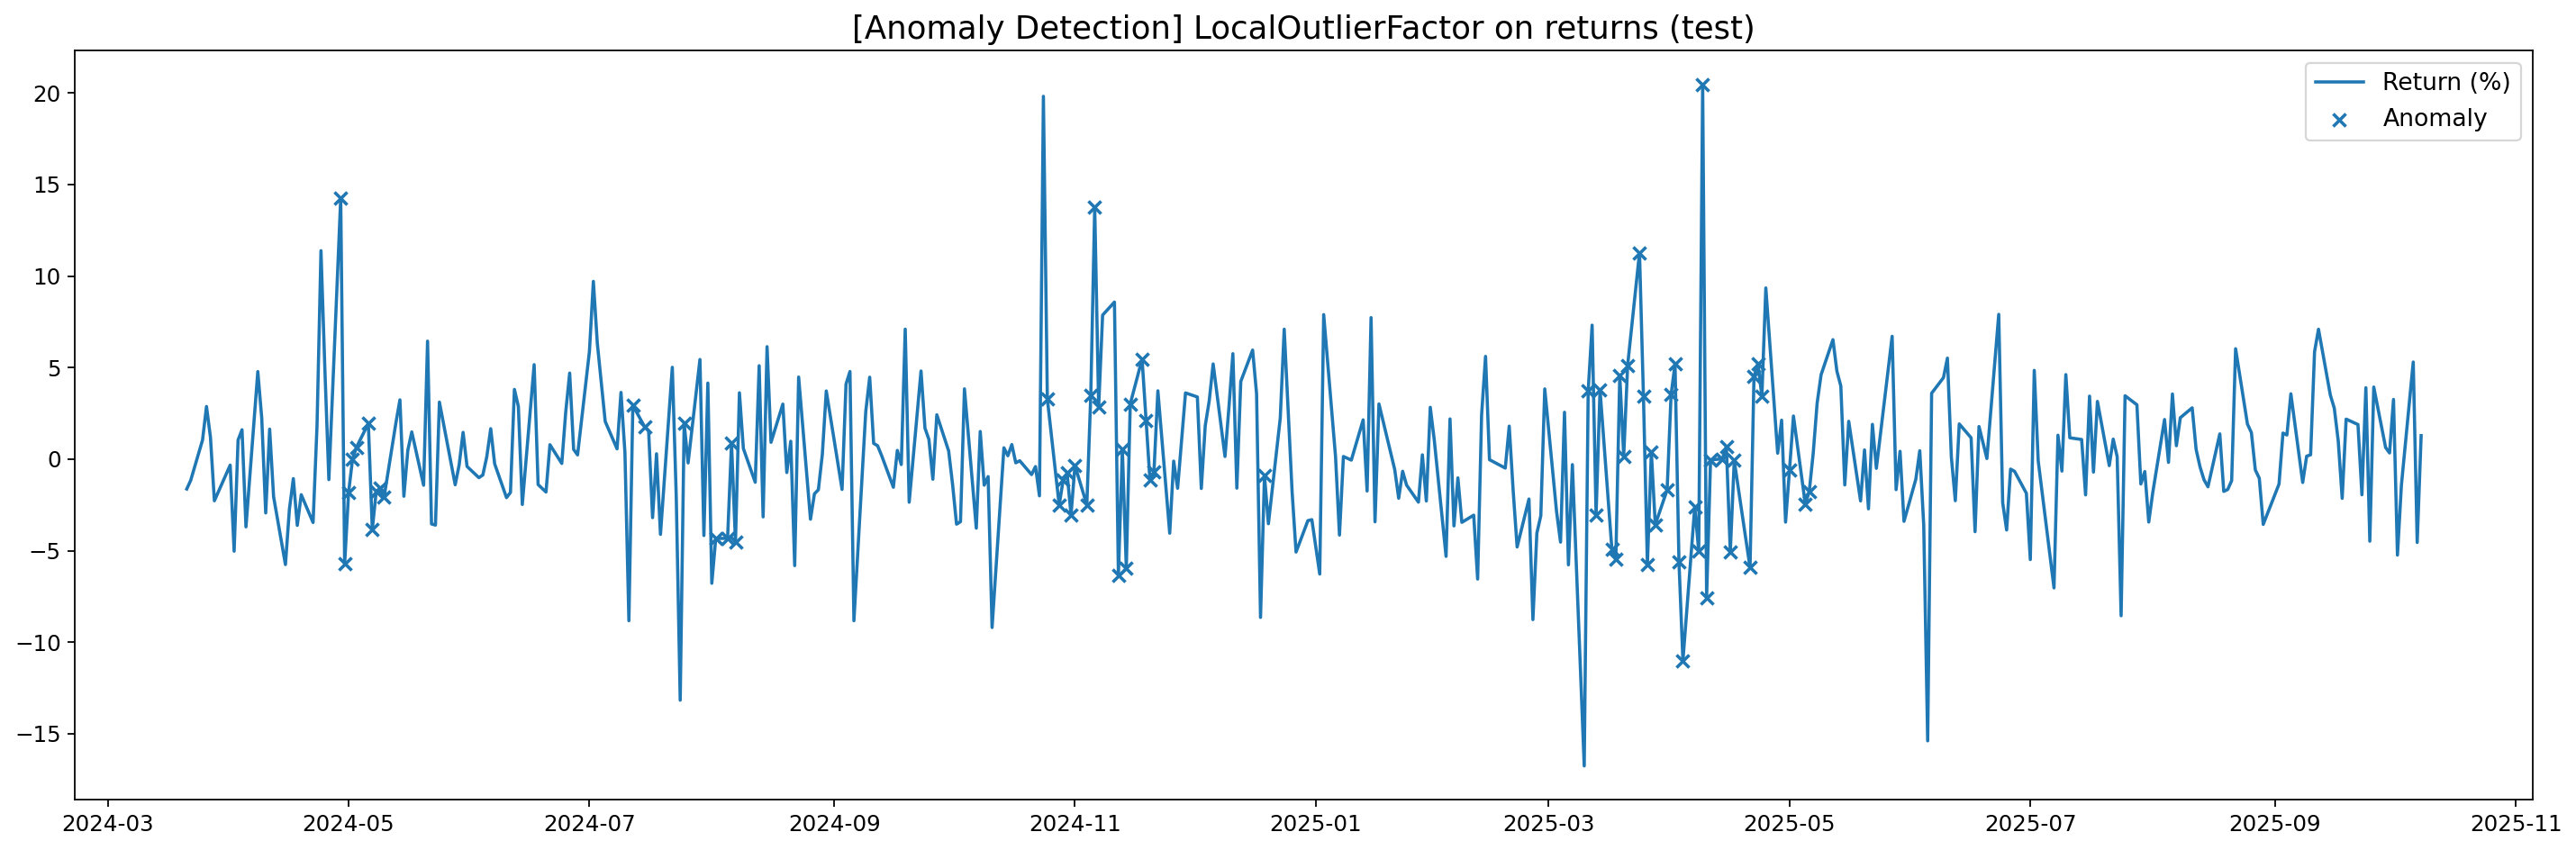

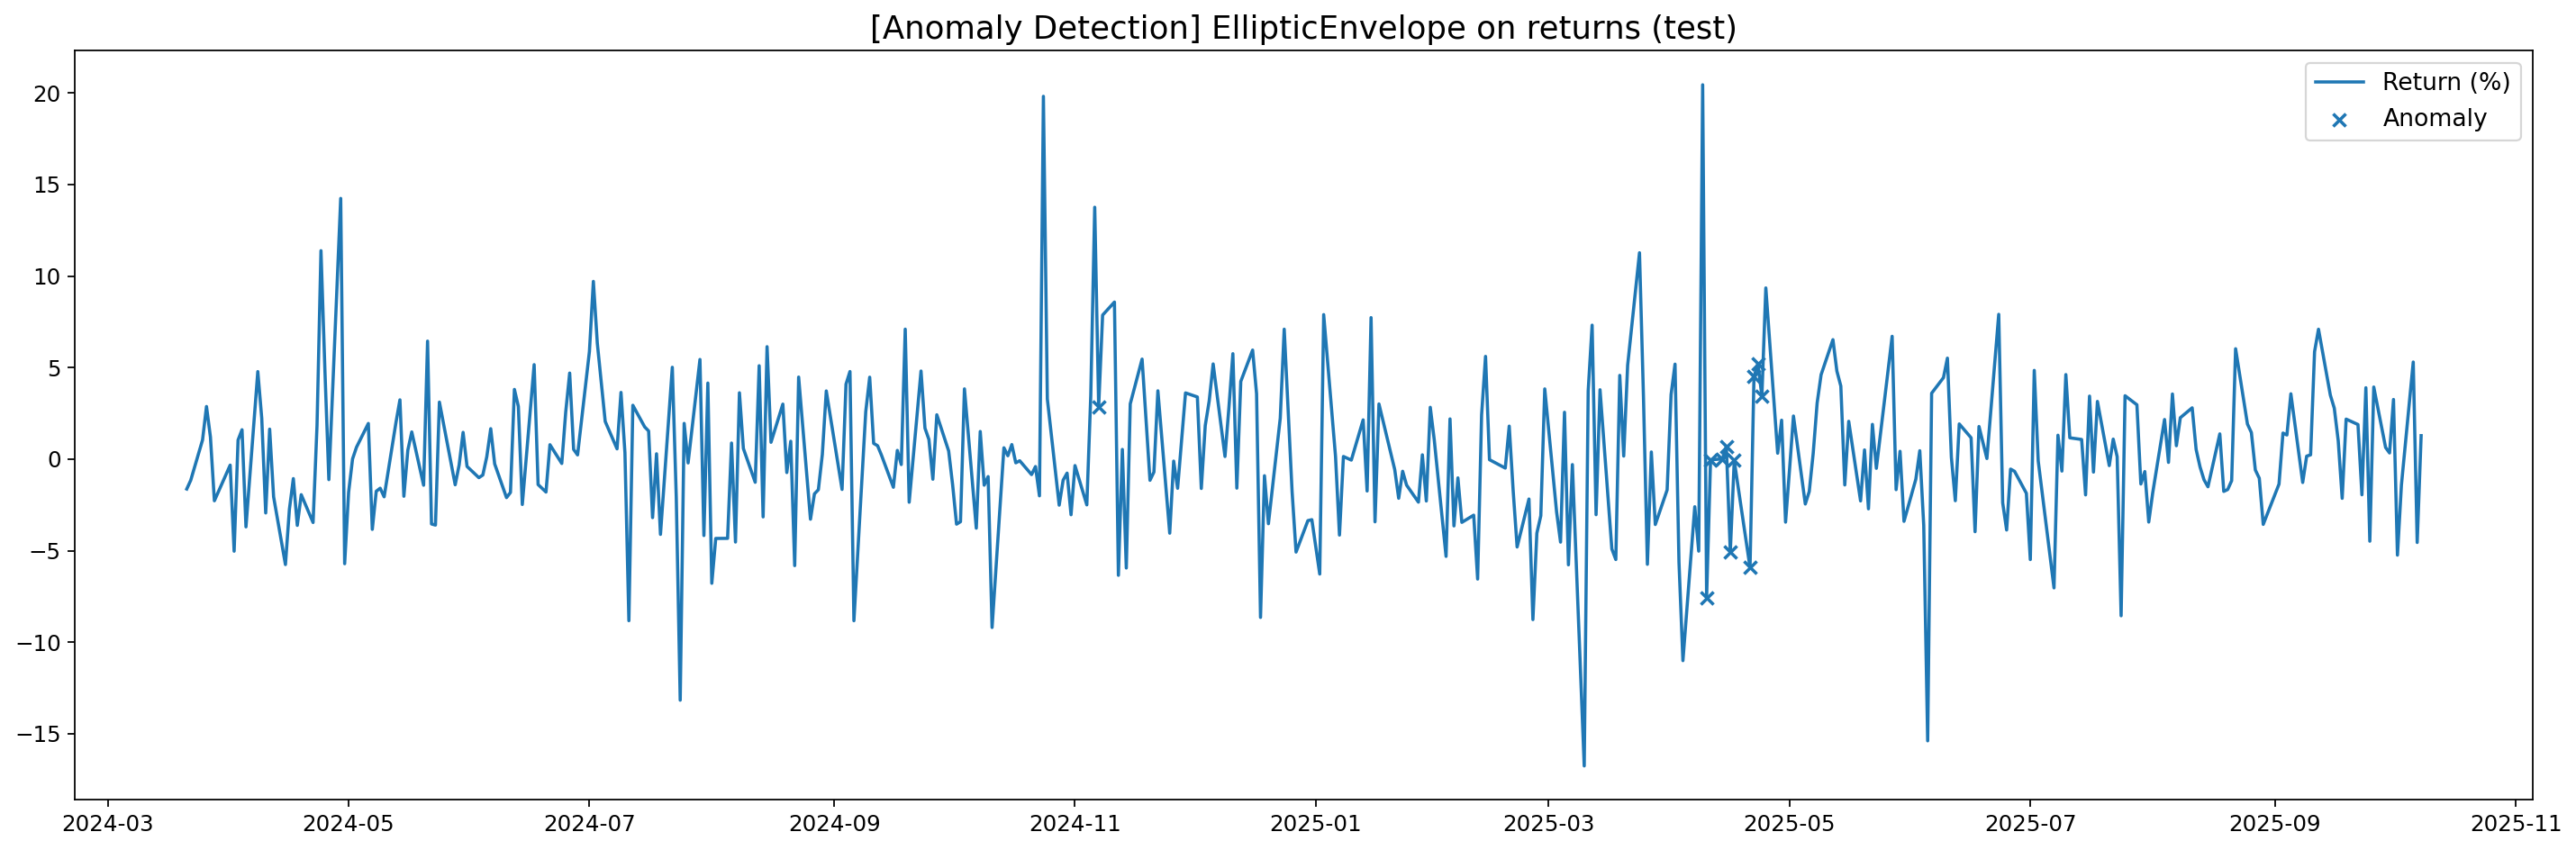

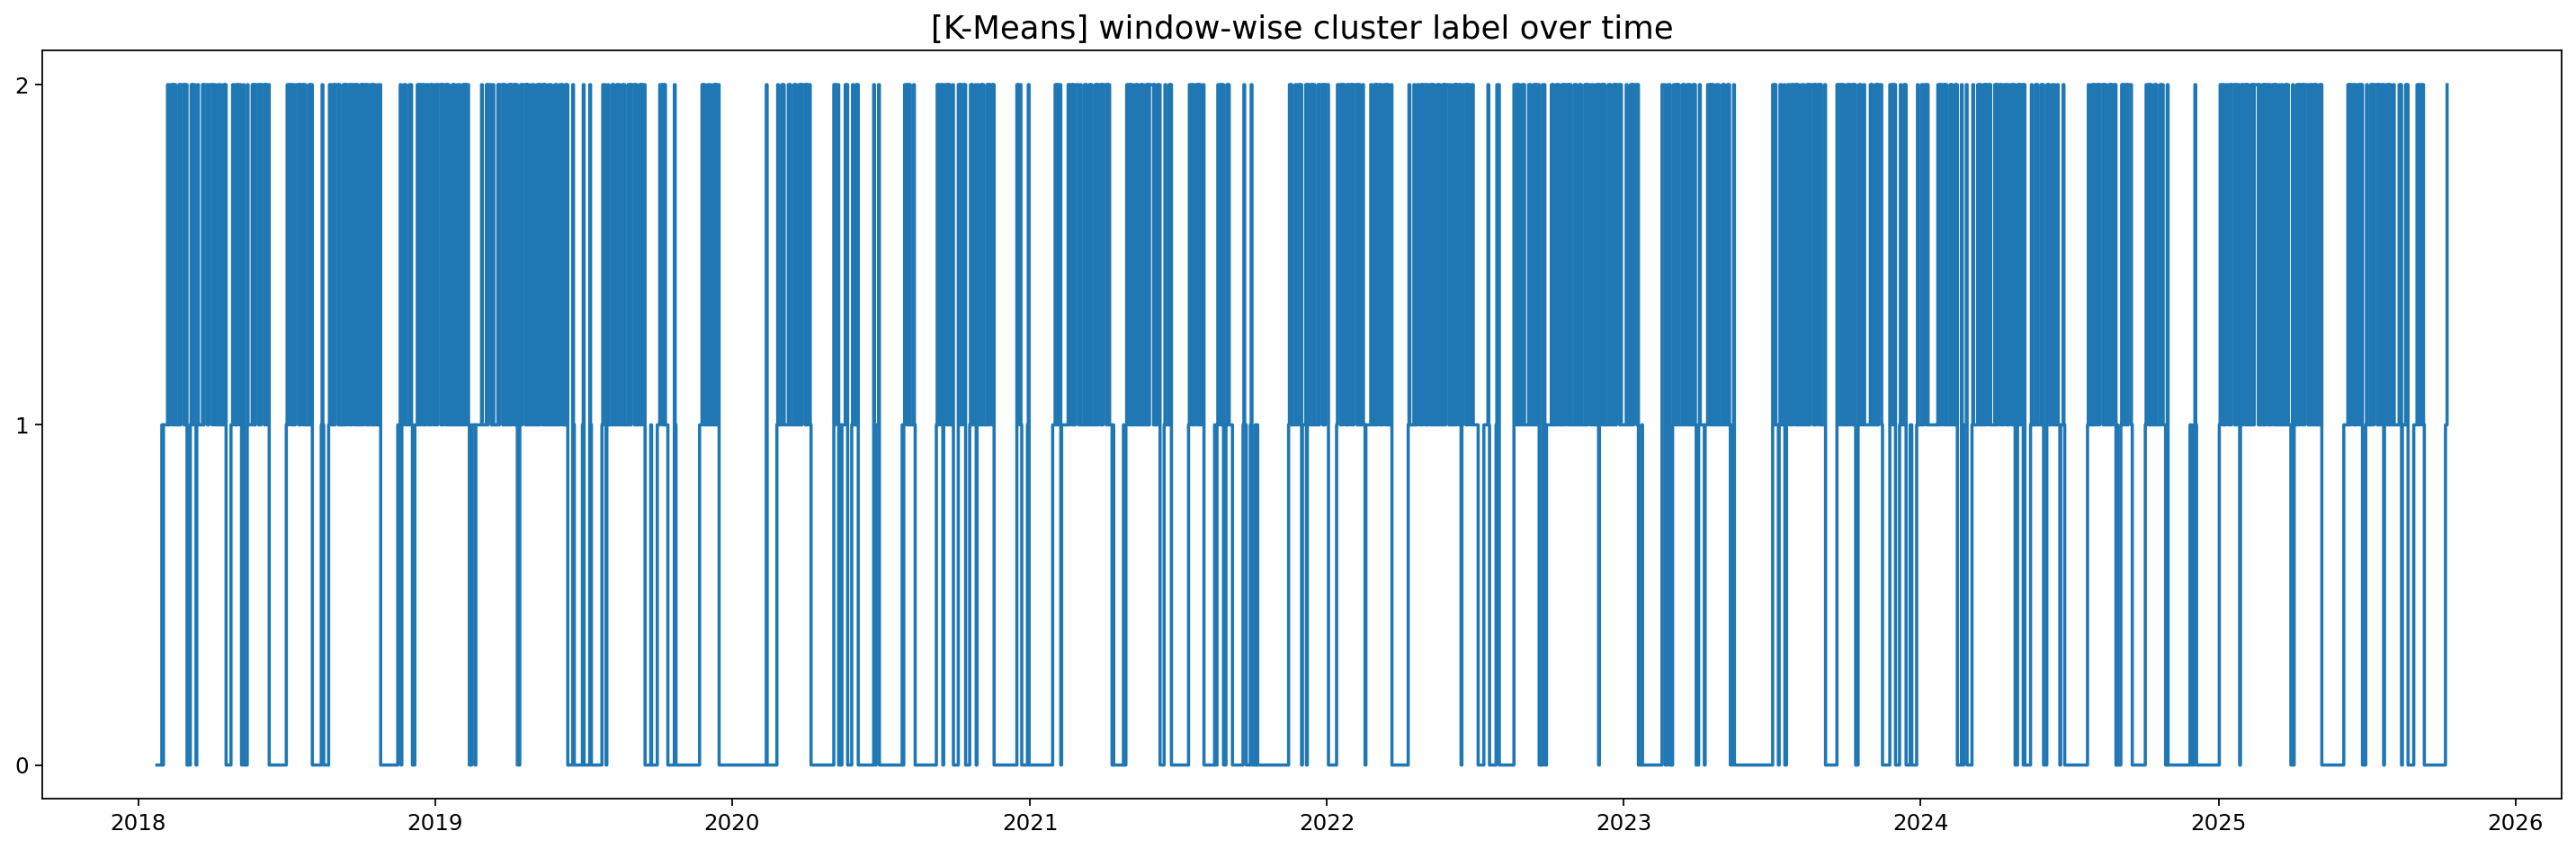

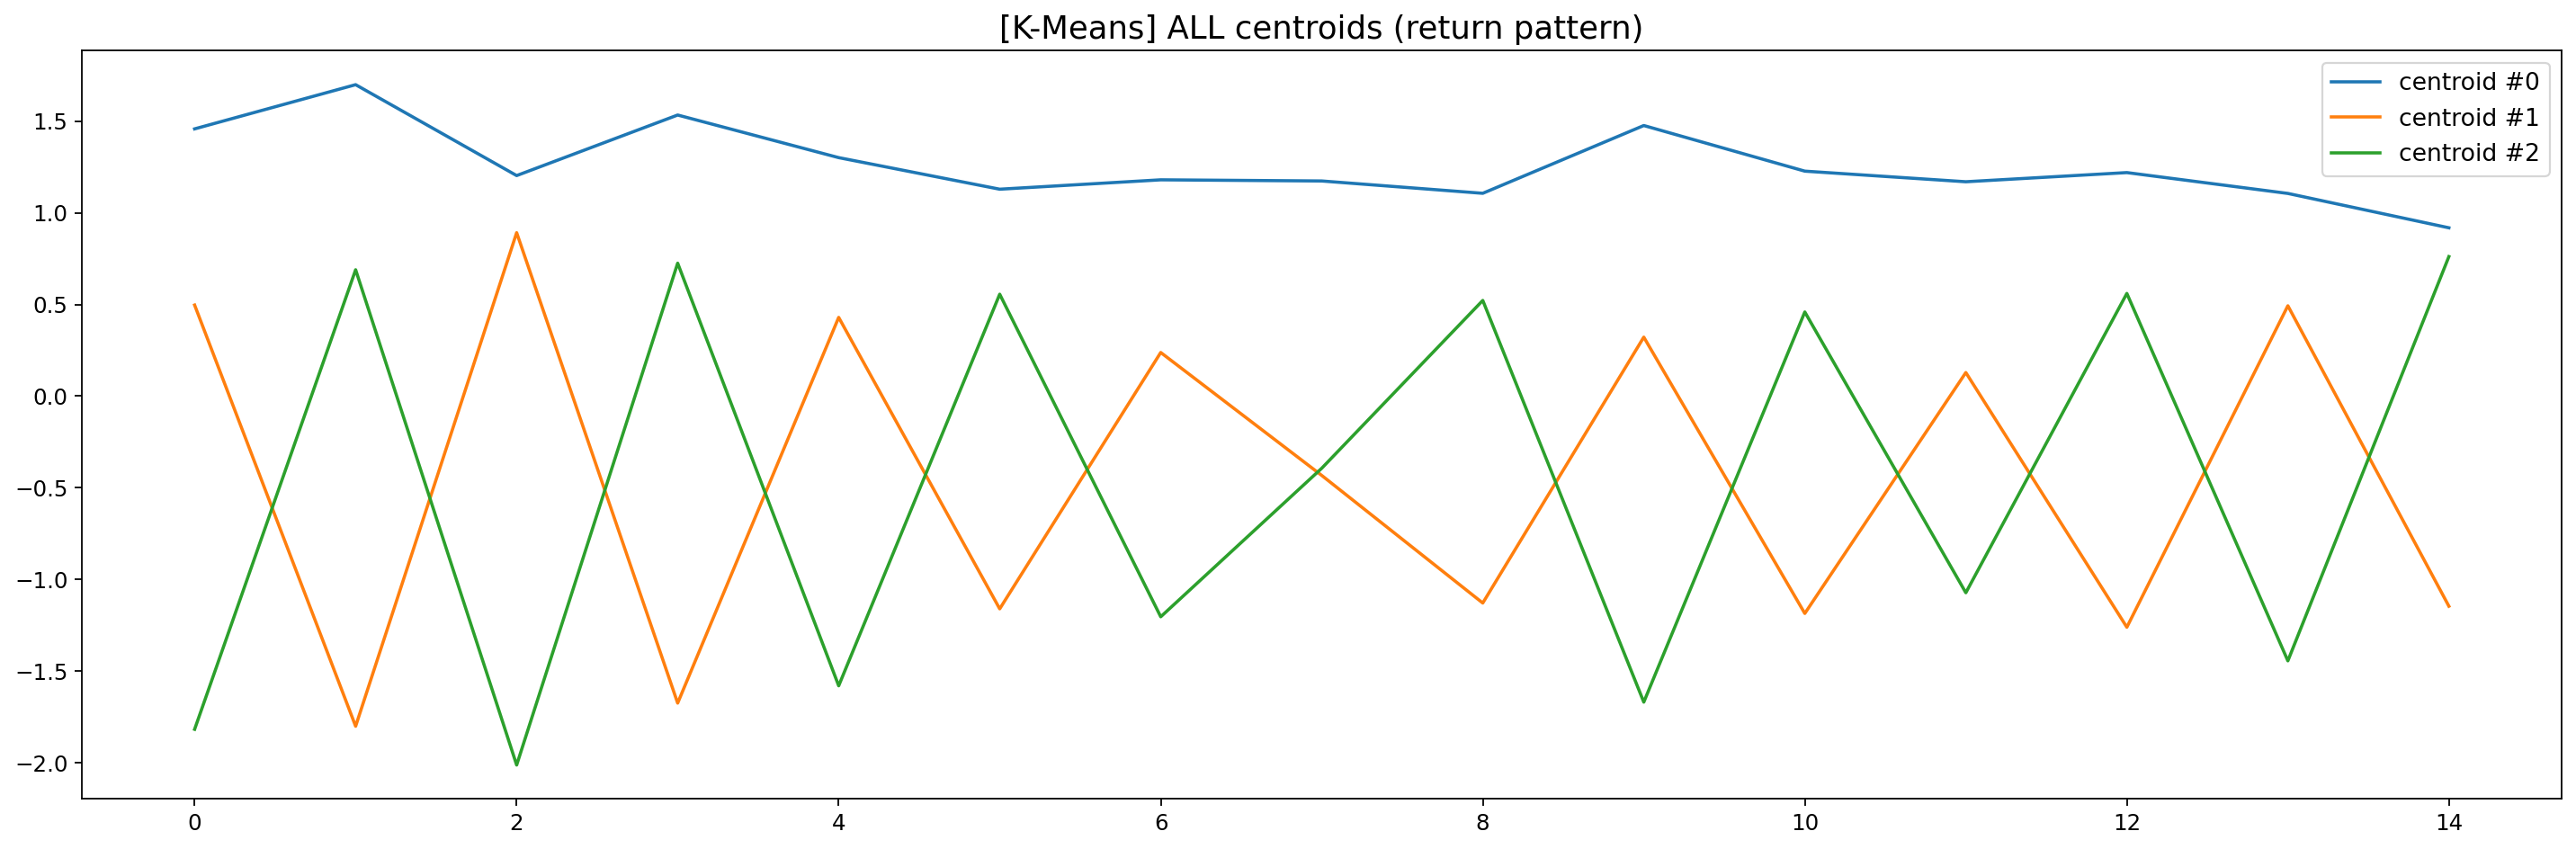

In [12]:
# timeseries_10_algos_tsla_fixed.py
# -----------------------------------------------------------
# TSLA: 회귀 5종(다음날 수익률→가격 복원), 이상치 탐지 4종, KMeans 1종
# 각 모델 개별 그래프 + 모든 모델 합친 그래프 출력
# -----------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.neural_network import MLPRegressor
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans

import yfinance as yf

# -----------------------------
# 전역 그림(크게)
# -----------------------------
mpl.rcParams.update({
    "figure.figsize": (18, 6),
    "figure.dpi": 160,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,
    "lines.linewidth": 1.6,
})

# -----------------------------
# 유틸
# -----------------------------
def _to_series_1d(v, idx=None, name="y"):
    """입력이 Series/1컬럼 DataFrame/배열 무엇이든 1D Series로 정규화"""
    if isinstance(v, pd.Series):
        s = v.copy()
        s.name = name
        return s
    if isinstance(v, pd.DataFrame):
        if v.shape[1] != 1:
            raise ValueError(f"Expected 1 column, got {v.shape[1]}")
        s = v.iloc[:, 0].copy()
        s.name = name
        return s
    arr = np.asarray(v).reshape(-1)   # (N,1) -> (N,)
    return pd.Series(arr, index=idx, name=name)

def make_lag_df(s, L: int = 10, horizon: int = 1) -> pd.DataFrame:
    """시리즈 s(예: 수익률)로 랙 특징과 horizon-step 앞 값을 생성"""
    s = _to_series_1d(s, name="y")           # ★ 1D Series 보장
    df = pd.DataFrame({"y": s})
    for i in range(1, L + 1):
        df[f"lag{i}"] = s.shift(i)
    df["y_next"] = s.shift(-horizon)
    return df.dropna()

def price_path_from_returns(p0: float, rets: np.ndarray) -> np.ndarray:
    """p0에서 시작해 로그수익률(%) 시퀀스로 가격 경로 복원"""
    cum = np.cumsum(rets / 100.0)     # % → log-return 누적
    return p0 * np.exp(cum)

rmse = lambda a, b: float(np.sqrt(mean_squared_error(a, b)))
mae  = lambda a, b: float(mean_absolute_error(a, b))

# -----------------------------
# 1) 데이터: TSLA 조정종가 → 로그수익률(%)
# -----------------------------
start, end = "2018-01-01", None
tsla = yf.download("TSLA", start=start, end=end, auto_adjust=True)[["Close"]].dropna()
price = tsla["Close"].astype(float)                      # <-- 한 컬럼 Series

ret = np.log(price).diff().mul(100).dropna()            # % 수익률 (Series)
ret = ret.squeeze()
if isinstance(ret, pd.DataFrame):                       # (예방) 1컬럼 DF면 Series로
    ret = ret.iloc[:, 0]
ret.name = "ret"

print(f"TSLA: {len(price)} prices | {price.index[0].date()} ~ {price.index[-1].date()}")

# -----------------------------
# 2) 회귀 5종: 다음날 수익률 예측 -> 가격 복원
# -----------------------------
L = 10
reg_df = make_lag_df(ret, L=L, horizon=1)      # y=ret_t, y_next=ret_{t+1}
X = reg_df[[f"lag{i}" for i in range(1, L + 1)]].values
y_next = reg_df["y_next"].values
dates = reg_df.index

# 시간순 분할
split_idx = int(0.8 * len(X))
X_tr, X_te = X[:split_idx], X[split_idx:]
y_tr, y_te = y_next[:split_idx], y_next[split_idx:]
dates_te = dates[split_idx:]

# 테스트 시작 직전의 실제 가격(복원 시작점) — 가장 가까운 과거 시점 사용
p0 = float(price.loc[:dates_te[0]].iloc[-1])   # ★ 스칼라로 안전 추출 (FutureWarning 회피)
true_price_te = price.loc[dates_te[0]:]

reg_models = {
    "Linear Regression": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Decision Tree": DecisionTreeRegressor(random_state=0, min_samples_leaf=5),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=0, min_samples_leaf=3, n_jobs=-1),
    "Neural Net (MLPRegressor)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(
            hidden_layer_sizes=(64, 32),
            max_iter=2000,              # 수렴 여유
            early_stopping=True,        # 조기 종료로 ConvergenceWarning 완화
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=0
        ))
    ]),
    "GBM (GradientBoostingRegressor)": GradientBoostingRegressor(random_state=0),
}

reg_metrics, preds_ret, preds_price = [], {}, {}
for name, mdl in reg_models.items():
    mdl.fit(X_tr, y_tr)
    yhat_ret = mdl.predict(X_te)                        # 예측 수익률(%)
    preds_ret[name] = yhat_ret

    # 가격 경로 복원
    price_pred = price_path_from_returns(p0, yhat_ret)  # ★ 이미 스칼라, float() 불필요
    preds_price[name] = price_pred

    # 수익률 기준 지표
    reg_metrics.append({
        "Model": name,
        "RMSE(ret%)": rmse(y_te, yhat_ret),
        "MAE(ret%)": mae(y_te, yhat_ret),
        "R2(ret%)": float(r2_score(y_te, yhat_ret)),
        # 가격 기준 보조 지표(스케일 영향 큼)
        "Price RMSE": rmse(true_price_te.values[:len(price_pred)], price_pred),
        "Price MAE": mae(true_price_te.values[:len(price_pred)], price_pred),
    })

reg_table = pd.DataFrame(reg_metrics).sort_values("RMSE(ret%)").reset_index(drop=True)
print("\n[Regression] Metrics (return % and price)")
print(reg_table.to_string(index=False))

# -----------------------------
# 3) 이상치 탐지 4종 (분류 대신)
# -----------------------------
X_anom = reg_df[[f"lag{i}" for i in range(1, L + 1)]].values
dates_anom = reg_df.index
split_idx_anom = int(0.8 * len(X_anom))
X_anom_tr, X_anom_te = X_anom[:split_idx_anom], X_anom[split_idx_anom:]
dates_anom_te = dates_anom[split_idx_anom:]

anom_models = {
    "IsolationForest": IsolationForest(
        n_estimators=300, contamination="auto", random_state=0
    ),
    "OneClassSVM": OneClassSVM(kernel="rbf", gamma="scale", nu=0.03),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=35, novelty=True),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.03, random_state=0),
}

anom_labels = {}
for name, mdl in anom_models.items():
    mdl.fit(X_anom_tr)
    # 예측: 1(정상), -1(이상)
    yhat = mdl.predict(X_anom_te)
    anom_labels[name] = (yhat == -1)

# -----------------------------
# 4) KMeans (패턴 클러스터링)
# -----------------------------
win = 15
X_pat = np.array([ret.values[i:i + win] for i in range(len(ret) - win + 1)])
dates_pat = ret.index[win - 1:]
split_pat = int(0.8 * len(X_pat))
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(X_pat[:split_pat])
labels_all = kmeans.predict(X_pat)
cluster_counts = pd.Series(labels_all).value_counts().sort_index()
print("\n[KMeans] Cluster counts:", dict(cluster_counts))

# -----------------------------
# 5) 시각화: 개별 + 합쳐서
# -----------------------------
lookback = 250

# (A) 회귀 — 각 모델별 가격 예측(개별)
for name, path in preds_price.items():
    plt.figure()
    plt.plot(true_price_te.index[-lookback:], true_price_te.values[-lookback:], label="Actual Price", alpha=0.9)
    plt.plot(true_price_te.index[-lookback:], path[-lookback:], label=f"Pred Price — {name}", linestyle="--")
    plt.title(f"[TSLA] Price backtest — {name}")
    plt.legend(); plt.tight_layout(); plt.show()

# (B) 회귀 — 모든 모델 한 장
plt.figure()
plt.plot(true_price_te.index[-lookback:], true_price_te.values[-lookback:], label="Actual Price", color="black")
for name, path in preds_price.items():
    plt.plot(true_price_te.index[-lookback:], path[-lookback:], label=name, linestyle="--")
plt.title("[TSLA] Price backtest — ALL regression models")
plt.legend(ncol=2); plt.tight_layout(); plt.show()

# (C) 이상치 탐지 — 모델별로 테스트 구간에 이상치 포인트 표시
for name, mask in anom_labels.items():
    plt.figure()
    series_te = ret.loc[dates_anom_te]
    plt.plot(series_te.index, series_te.values, label="Return (%)")
    plt.scatter(series_te.index[mask], series_te.values[mask], marker="x", s=40, label="Anomaly")
    plt.title(f"[Anomaly Detection] {name} on returns (test)")
    plt.legend(); plt.tight_layout(); plt.show()

# (D) KMeans — 시간별 라벨, 센트로이드
plt.figure()
plt.step(dates_pat, labels_all, where="post")
plt.yticks(sorted(np.unique(labels_all)))
plt.title("[K-Means] window-wise cluster label over time")
plt.tight_layout(); plt.show()

plt.figure()
for i, c in enumerate(kmeans.cluster_centers_):
    plt.plot(range(win), c, label=f"centroid #{i}")
plt.title("[K-Means] ALL centroids (return pattern)")
plt.legend(); plt.tight_layout(); plt.show()
